<a href="https://colab.research.google.com/github/FrankGangWang/AppliedML_Python_Coursera/blob/master/Pipelined_Interview_for_DataScience_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Interview questions to test data science skills**

---




# Let's load the data from public GitHub account

In [2]:
#!pip install --upgrade scikit-learn
import sklearn
print(sklearn.__version__)
print(__doc__)
if 0:
  from sklearn import set_config
  set_config(display='diagram')


0.22.2.post1
Automatically created module for IPython interactive environment


In [3]:
# RUN: declare constants
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Constants
ADD_TIME_FEATURES = False 
SYSTEM_ID_SELECTED = [1] 
#SYSTEM_ID_SELECTED = ['All']

TEST_SIZE = 0.2
TARGET_FEATURE = 'cpu_utilization'

In [4]:
# functions to load data and preprocess
def load_data():
  # load data
  df = pd.read_pickle("https://github.com/manjiler/interview_for_datascience/raw/master/interview_storage.pkl")
  return df

# RUN: add and sort by datetime index
def set_index_sort(df):
  df['timestamp_seconds'] = df.pop('timestamp')/1000
  df['Datetime'] = pd.to_datetime(df['timestamp_seconds'], unit='s', origin='unix')
  df.set_index(df['Datetime'], inplace=True)
  df.sort_index(inplace=True)
  
# RUN to add some artificial features maybe useful
# add sin/cos for day/hour
def add_time_features(df):
  hour = 60*60
  day = 24*hour
  week = 7*day
  df['Hour_Sin'] = np.sin(df['timestamp_seconds'] * (2 * np.pi / hour))
  df['Hour_Cos'] = np.cos(df['timestamp_seconds'] * (2 * np.pi / hour))
  df['Day_Sin'] = np.sin(df['timestamp_seconds'] * (2 * np.pi / day))
  df['Day_Cos'] = np.cos(df['timestamp_seconds'] * (2 * np.pi / day))
  week_offset = 3*day # as epoch 0 is Thursday 1970-01-01, and leap seconds 23:59:60
  df['Week_Sin'] = np.sin((df['timestamp_seconds']+week_offset) * (2 * np.pi / week))
  df['Week_Cos'] = np.cos((df['timestamp_seconds']+week_offset) * (2 * np.pi / week))

  df['Hours_Of_Datetime'] = df['Datetime'].dt.hour #The hours of the datetime
  df['Minutes_Of_Datetime'] = df['Datetime'].dt.minute #The minutes of the datetime

  # The day of the week with Monday=0, Sunday=6
  # TODO: convert the dayofweek into a categorical variable via one-hot encoding
  df['Day_Of_Week'] = df['Datetime'].dt.dayofweek  
  #df.pop('Datetime')

def set_systemId_number(df):
  import re
  systemId_list = df.systemId.unique()
  systemId_num = [{ax : int(re.findall(r'[\d]+', ax)[0])} for ax in systemId_list]
  systemId_lookup = {}
  for x in systemId_num:
    for key, val in x.items():
      systemId_lookup[key] = val
  df["systemId"] = df.systemId.replace(systemId_lookup).values
  print(systemId_lookup)
  return systemId_lookup


def set_model_type_number(df):
  import re
  model_list = df.model_type.unique()
  model_type_lookup = dict(zip(model_list, range(1, 1+len(model_list))))
  df["model_type"] = df.model_type.replace(model_type_lookup).values
  return model_type_lookup
  print(model_type_lookup)

# Summary of data: 
# -- Number of missing values; 
# -- Number of numerical/category features

def summary_print(df):
  # Checking whether there are any missing values
  print(f'*** INFO: Number of NA values: {np.sum(df.isna().sum())}')
  print(f"df shape: {df.shape}")

  # -- Number of numerical/category features
  category_features = tuple(df.columns[(df.dtypes == 'category') | (df.dtypes == 'object')])
  numerical_features = tuple(df.columns[(df.dtypes == 'float') | (df.dtypes == 'int')])
  print(f'There are {len(category_features)} category_features = {category_features}')
  print(f'There are {len(numerical_features)} numerical_features = {numerical_features}')
  return category_features, numerical_features


In [5]:
# RUN: load data, add index, sort by time , add transformed time features 
df = load_data()
print(f' *** After load_data: df shape = {df.shape}; {df.columns}')

set_index_sort(df)
print(f' *** After set_index_sort : df shape = {df.shape}; {df.columns}')

if ADD_TIME_FEATURES:
  add_time_features(df)
#else:
#  df.pop('Datetime')

category_features, numerical_features = summary_print(df)
dtypes_all = np.unique(df.dtypes)
print(dtypes_all, '\n', df.dtypes)

systemId_lookup = set_systemId_number(df)
model_type_lookup = set_model_type_number(df)
print(f' *** Finally: df shape = {df.shape}; {df.columns}')
print(f' *** model_type_lookup = {model_type_lookup}; \n  systemId_lookup = {systemId_lookup}')
print(f' *** category_features = {category_features}; \n  numerical_features = {numerical_features}')


 *** After load_data: df shape = (175505, 12); Index(['systemId', 'timestamp', 'model_type', 'cpu_utilization',
       'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops',
       'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz'],
      dtype='object')
 *** After set_index_sort : df shape = (175505, 13); Index(['systemId', 'model_type', 'cpu_utilization', 'read_cache_miss',
       'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput',
       'write_throughput', 'read_iosz', 'write_iosz', 'timestamp_seconds',
       'Datetime'],
      dtype='object')
*** INFO: Number of NA values: 0
df shape: (175505, 13)
There are 2 category_features = ('systemId', 'model_type')
There are 10 numerical_features = ('cpu_utilization', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz', 'timestamp_seconds')
[dtype('float64') dtype('<M8[ns]') dtype('O')] 
 systemId                     objec

Note: 
 

*   'systemId', 'model_type' are encoded into integers for easy to use;
*   use category_features for indexing categorical features, e.g. for OneHotEncoder 




In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175505 entries, 2019-11-01 00:00:00 to 2019-11-30 23:55:00
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   systemId           175505 non-null  int64         
 1   model_type         175505 non-null  int64         
 2   cpu_utilization    175505 non-null  float64       
 3   read_cache_miss    175505 non-null  float64       
 4   write_cache_miss   175505 non-null  float64       
 5   read_iops          175505 non-null  float64       
 6   write_iops         175505 non-null  float64       
 7   read_throughput    175505 non-null  float64       
 8   write_throughput   175505 non-null  float64       
 9   read_iosz          175505 non-null  float64       
 10  write_iosz         175505 non-null  float64       
 11  timestamp_seconds  175505 non-null  float64       
 12  Datetime           175505 non-null  datetime64[ns]
dtypes: datetim

In [7]:
print(df[['systemId', 'model_type', 'cpu_utilization']].head(),'\n', df[['systemId', 'model_type', 'cpu_utilization']].tail())


                     systemId  model_type  cpu_utilization
Datetime                                                  
2019-11-01 00:00:00        26           1         3.616431
2019-11-01 00:00:00        27           1         5.736682
2019-11-01 00:05:00        27           1         6.346371
2019-11-01 00:05:00        26           1         3.311307
2019-11-01 00:10:00        27           1         6.086861 
                      systemId  model_type  cpu_utilization
Datetime                                                  
2019-11-30 23:55:00         3           2         7.895631
2019-11-30 23:55:00         1           1        18.350607
2019-11-30 23:55:00        13           2         7.414141
2019-11-30 23:55:00        21           1        26.925968
2019-11-30 23:55:00        11           1         5.612619


In [8]:
print(df.isna().sum())

systemId             0
model_type           0
cpu_utilization      0
read_cache_miss      0
write_cache_miss     0
read_iops            0
write_iops           0
read_throughput      0
write_throughput     0
read_iosz            0
write_iosz           0
timestamp_seconds    0
Datetime             0
dtype: int64


In [9]:
df.describe()


systemId     model_type  ...     write_iosz  timestamp_seconds
count  175505.000000  175505.000000  ...  175505.000000       1.755050e+05
mean       13.060870       1.368092  ...      22.532924       1.573716e+09
std         7.263499       0.677033  ...      11.064237       7.187668e+05
min         1.000000       1.000000  ...       7.251837       1.572566e+09
25%         7.000000       1.000000  ...      15.661556       1.573096e+09
50%        13.000000       1.000000  ...      20.490950       1.573658e+09
75%        19.000000       2.000000  ...      26.844345       1.574304e+09
max        27.000000       3.000000  ...     191.323959       1.575158e+09

[8 rows x 12 columns]

## Now that the data is loaded. let's begin!!!

# **About the data**

---
This is time series data for one month collected for N number of devices

12 Columns

systemId - Device name

timestamp_seconds - epoch time when the sensor data was collected

model_type - Different versions/release/model of the device (similar to mobile models)

cpu_utilization - this percentage of how much the CPU is used on the device.

read_cache_miss - Percentage of read that were not present in the Cache

write_cache_miss - Percentage of write that were not present in the Cache

read_iops -  Number of read IOs per second (Input/Output)

write_iops -  Nummber of write IOs per second (Input/Output)

read_throughput - the read bandwidth per second (Units kbps)

write_throughput - the write bandwidth per second (Units kbps)

read_iosz - the block size for read Input/Output operations

write_iosz - the block size for write Input/Output operations


y -> cpu_utilization



## Q1. Do an EDA on the data, correlation plots, features that might be important for the modeling. Share your observations. Comment on how the data looks from modeling perspective

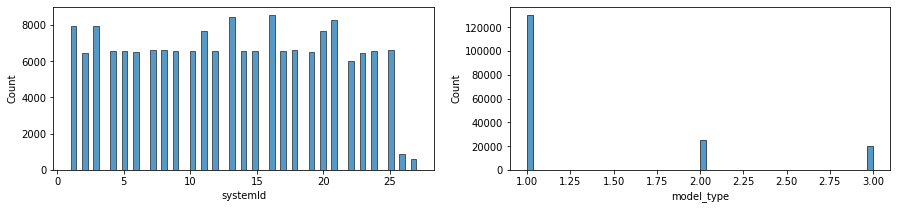

In [10]:
fig, axes = plt.subplots(1,2, figsize=(15,3))
sns.histplot(df, x='systemId', ax=axes[0])
sns.histplot(df, x='model_type', ax=axes[1])


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff02968e410>,
      dtype=object)

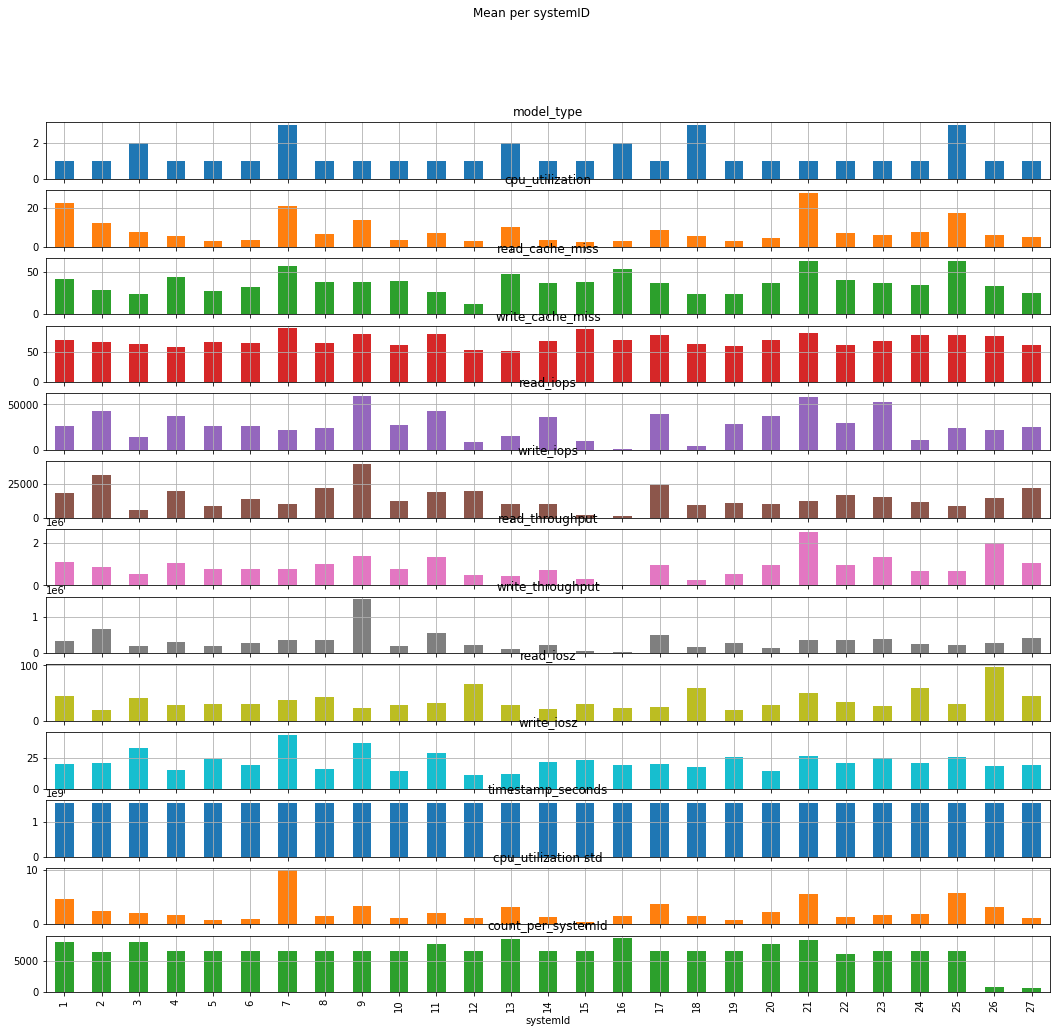

In [11]:
df_mean = df.groupby(['systemId']).mean()
df_mean['cpu_utilization std'] = df.groupby(['systemId'])[['cpu_utilization']].std()
df_mean['count_per_systemId'] = df.groupby(['systemId'])[['cpu_utilization']].count()

#df_mean.sort_values(by=['cpu_utilization'], ascending=False, inplace=True)
df_mean.sort_index()
df_mean.plot(kind='bar', subplots=True, figsize=(18, 16), grid=True, title='Mean per systemID', sort_columns=True, legend=False)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff029b6e710>,
      dtype=object)

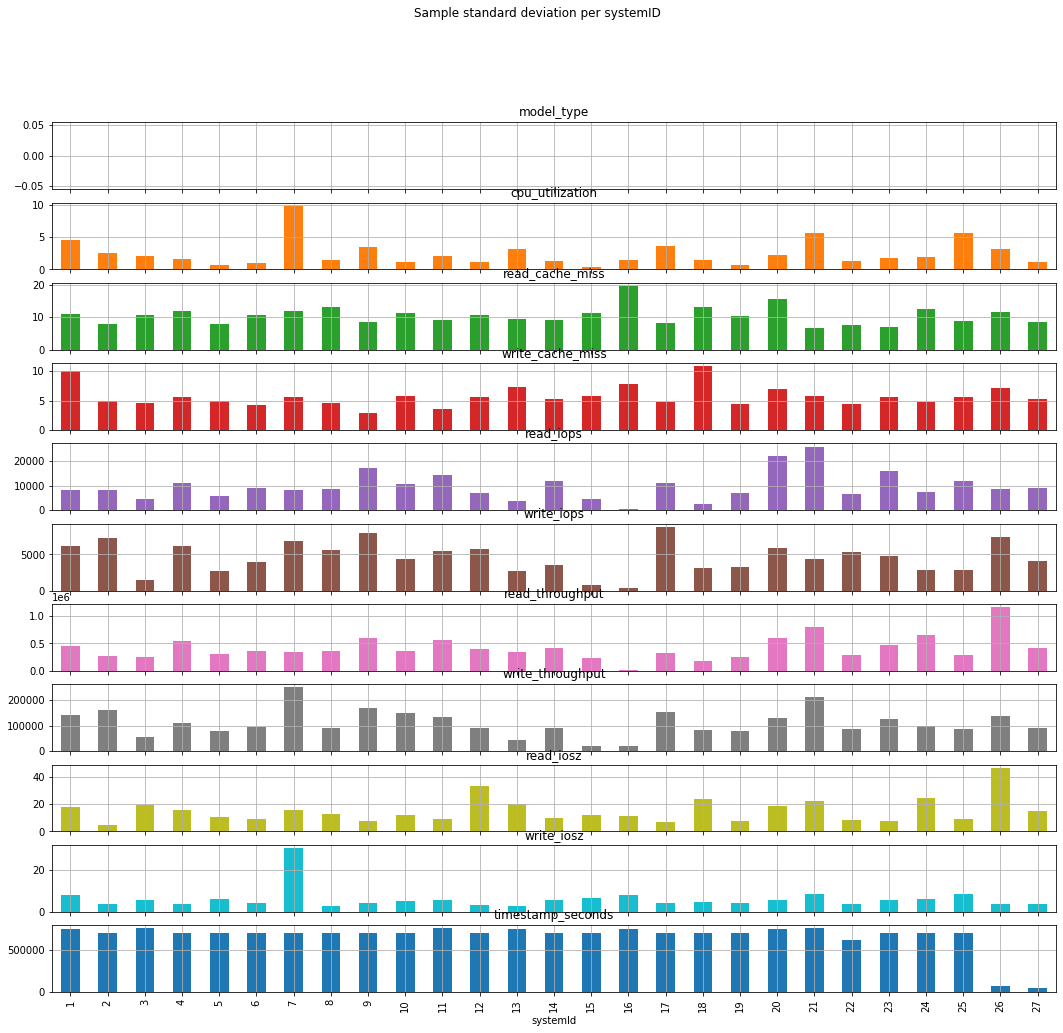

In [12]:
df_std = df.groupby(['systemId']).std()
#df_std.sort_values(by=['cpu_utilization'], ascending=False, inplace=True)
df_std.sort_index()
df_std.plot(kind='bar', subplots=True, figsize=(18, 16), grid=True, legend=False, title='Sample standard deviation per systemID')


In [13]:
def plot_averaged(diff_period, df, systemId, zoom_percent, window_span, title):
  features_cols = ['cpu_utilization', 'write_throughput', 'read_throughput']
  rows = 3
  cols = 1 # zoomed and full
  fig, axes = plt.subplots(rows, cols, figsize=(18, 3*rows))
  dfx = df[df['systemId']==systemId][features_cols]

  # TODO:$$$$$$$ keep datetime index of dfx

  # simple preprocessing for plotting
  dfx = df[df['systemId']==systemId][features_cols]
  if diff_period > 0:
    #dfx = dfx.diff(diff_period)
    dfx = dfx.diff(diff_period)

  from sklearn.preprocessing import MinMaxScaler
  encoder = MinMaxScaler()
  if 1:
    dfx['write_throughput'] = encoder.fit_transform(dfx['write_throughput'][:, np.newaxis])
    dfx['read_throughput'] = encoder.fit_transform(dfx['read_throughput'][:, np.newaxis])
    dfx['cpu_utilization'] = dfx['cpu_utilization']/100.0
  else:  
    dfx = encoder.fit_transform(dfx)
    dfx = pd.DataFrame(dfx, columns=features_cols)

  span = int(len(dfx)*zoom_percent)
  dfx = dfx[0:span]
  dfx.plot(ax=axes[0], subplots=False, sharex=True, grid=True)

  #dfx = dfx.ewm(span=span).mean()
  dfx_avg = dfx.rolling(window=window_span).mean()
  dfx_avg.plot(ax=axes[1], subplots=False, sharex=True, grid=True, logy=False)

  dfx_avg['cpu_writetput_ratio'] = dfx_avg['cpu_utilization'].values/dfx_avg['write_throughput'].values
  dfx_avg.cpu_writetput_ratio.plot(ax=axes[2], subplots=False, sharex=True, grid=True)

  fig.suptitle(title)
  plt.tight_layout()
  fig.subplots_adjust(top=0.95) # last in fig setting
  plt.show()

  fig, axes = plt.subplots(1, 2, figsize=(18, 3))
  dfx.plot(ax=axes[0], sharex=False, y='cpu_utilization', x='write_throughput', kind='scatter', grid=True)
  dfx_avg.plot(ax=axes[1], sharex=False, y='cpu_utilization', x='write_throughput', kind='scatter', grid=True)
  fig.tight_layout()

 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


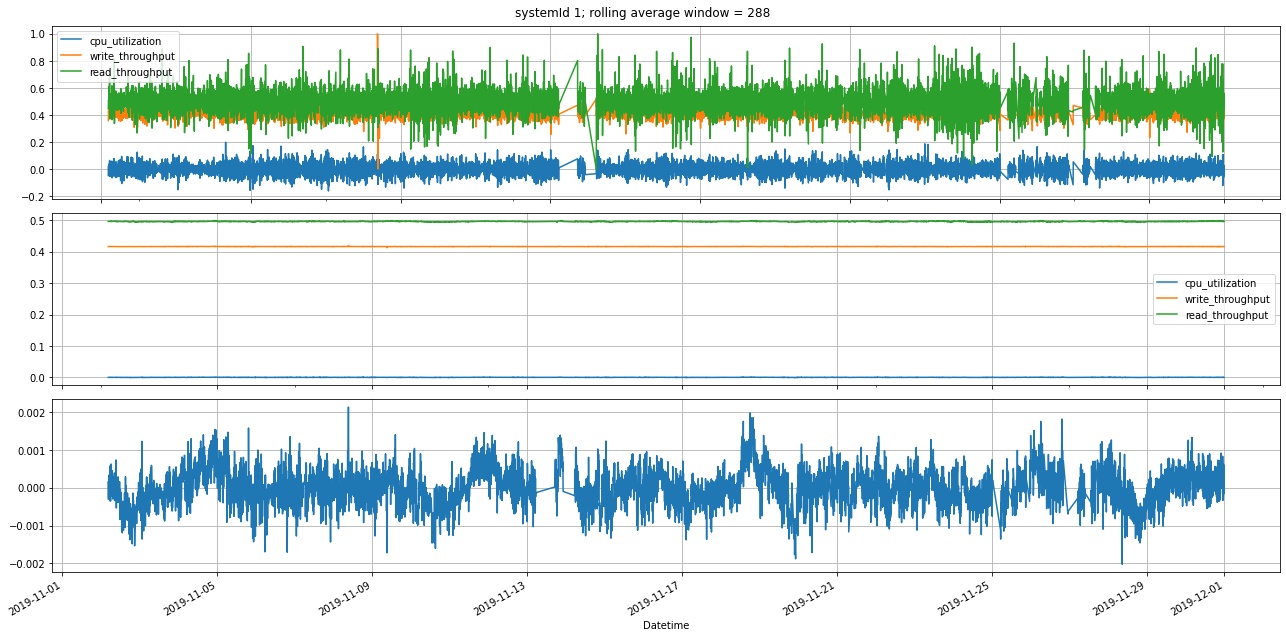

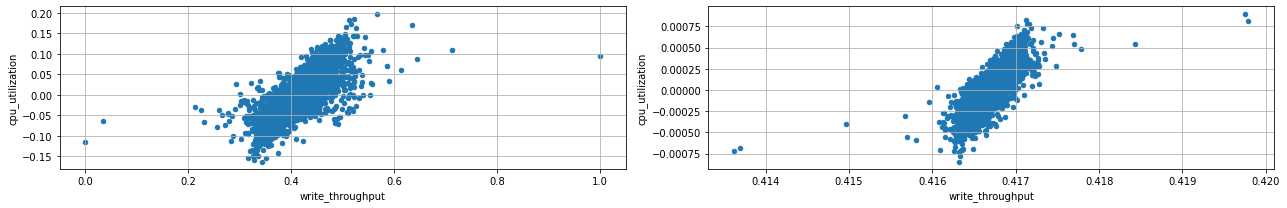

In [14]:
# diff(diff_period)
diff_period = 1
zoom_percent = 1
systemId_list = [1] # 7, 21,25, 26, 27]
average_span = 12*24

for systemId in systemId_list:
  title = f'systemId {systemId}; rolling average window = {average_span}'
  plot_averaged(diff_period, df, systemId, zoom_percent, average_span, title)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


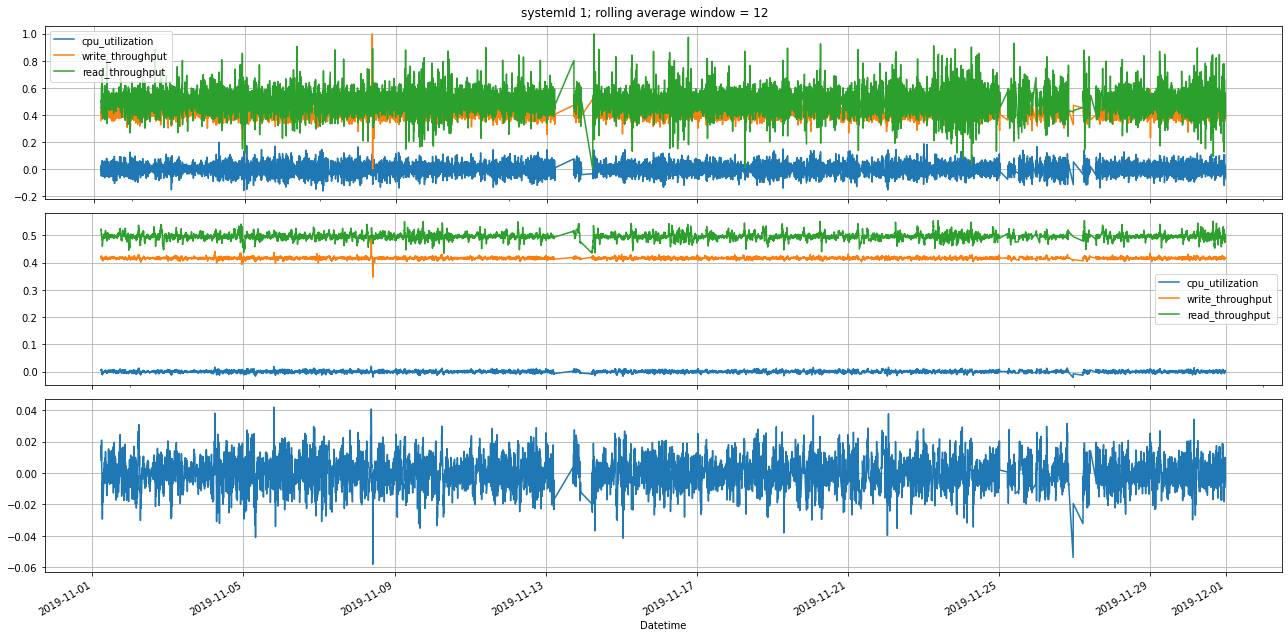

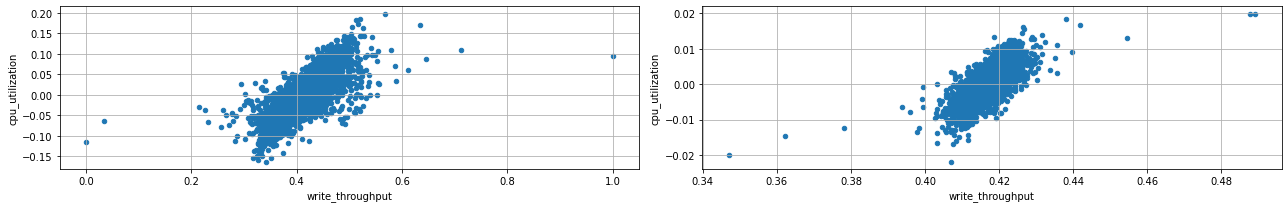

In [15]:
diff_period = 1
zoom_percent = 1
systemId_list = [1] # 7, 21,25, 26, 27]
average_span = 12

for systemId in systemId_list:
  title = f'systemId {systemId}; rolling average window = {average_span}'
  plot_averaged(diff_period, df, systemId, zoom_percent, average_span, title)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


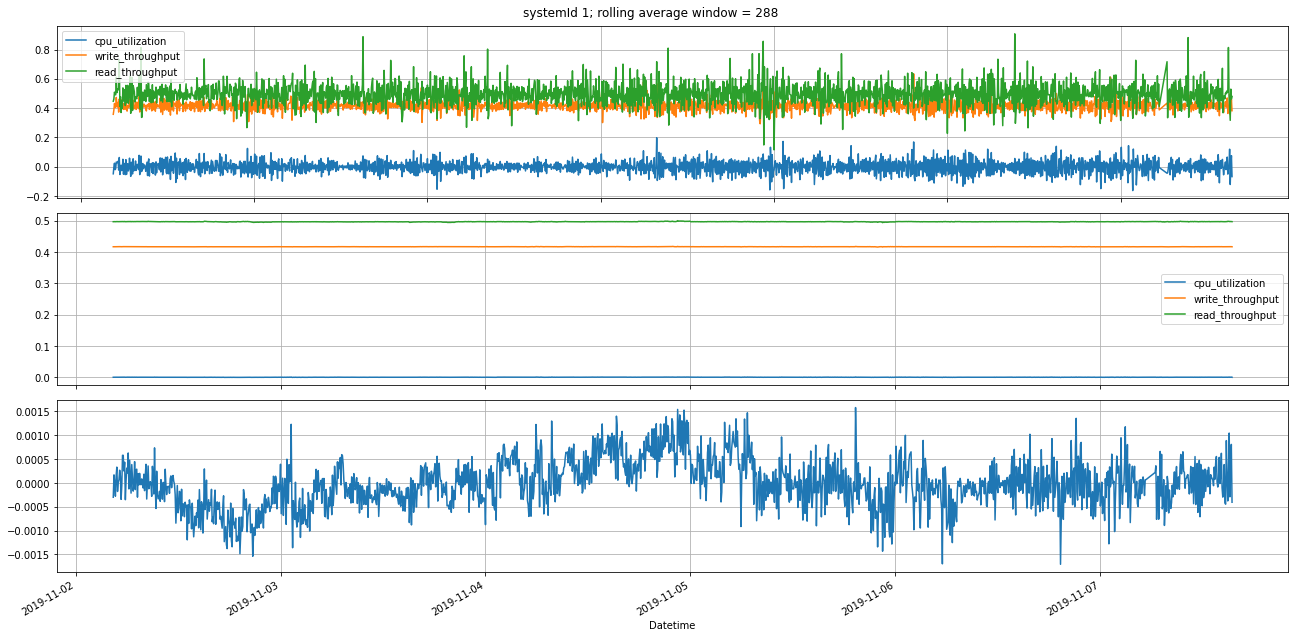

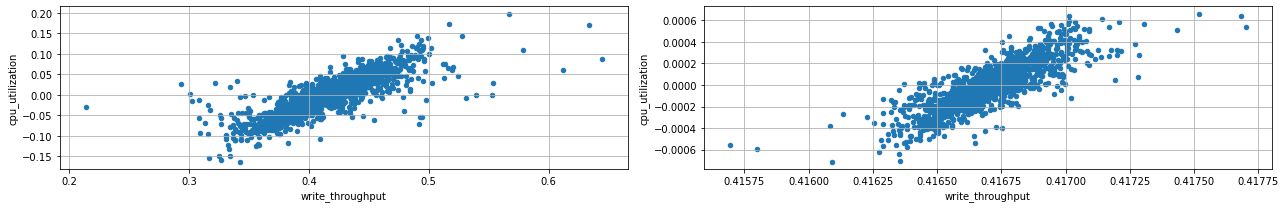

In [16]:
diff_period = 1
zoom_percent = 7/30.0
systemId_list = [1]
average_span = 12*24 # 1 day window is 12*24*period as period is 5 mninutes
for systemId in systemId_list:
  title = f'systemId {systemId}; rolling average window = {average_span}'
  plot_averaged(diff_period, df, systemId, zoom_percent, average_span, title)


                     cpu_utilization  write_throughput
Datetime                                              
2019-11-01 04:25:00        23.083557      643395.06250
2019-11-01 04:30:00        18.258795      452817.37500
2019-11-01 04:35:00        17.899469      354100.65625
2019-11-01 04:40:00        20.296371      402049.09375
2019-11-01 04:45:00        18.300312      375960.68750                      cpu_utilization  write_throughput
Datetime                                              
2019-11-01 04:25:00              NaN               NaN
2019-11-01 04:30:00        20.671176     548106.218750
2019-11-01 04:35:00        18.079132     403459.015625
2019-11-01 04:40:00        19.097920     378074.875000
2019-11-01 04:45:00        19.298342     389004.890625


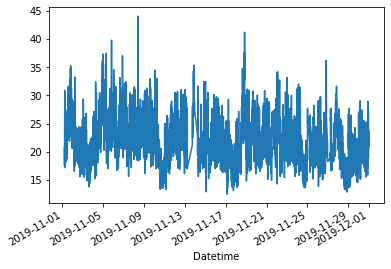

In [17]:
dfx = df[df['systemId']==1][['cpu_utilization', 'write_throughput']]
dfx1 = dfx.rolling(window=2).mean()
dfx1.cpu_utilization.plot()

print(dfx.head(), dfx1.head())


In [18]:
int(0.1*111)

11

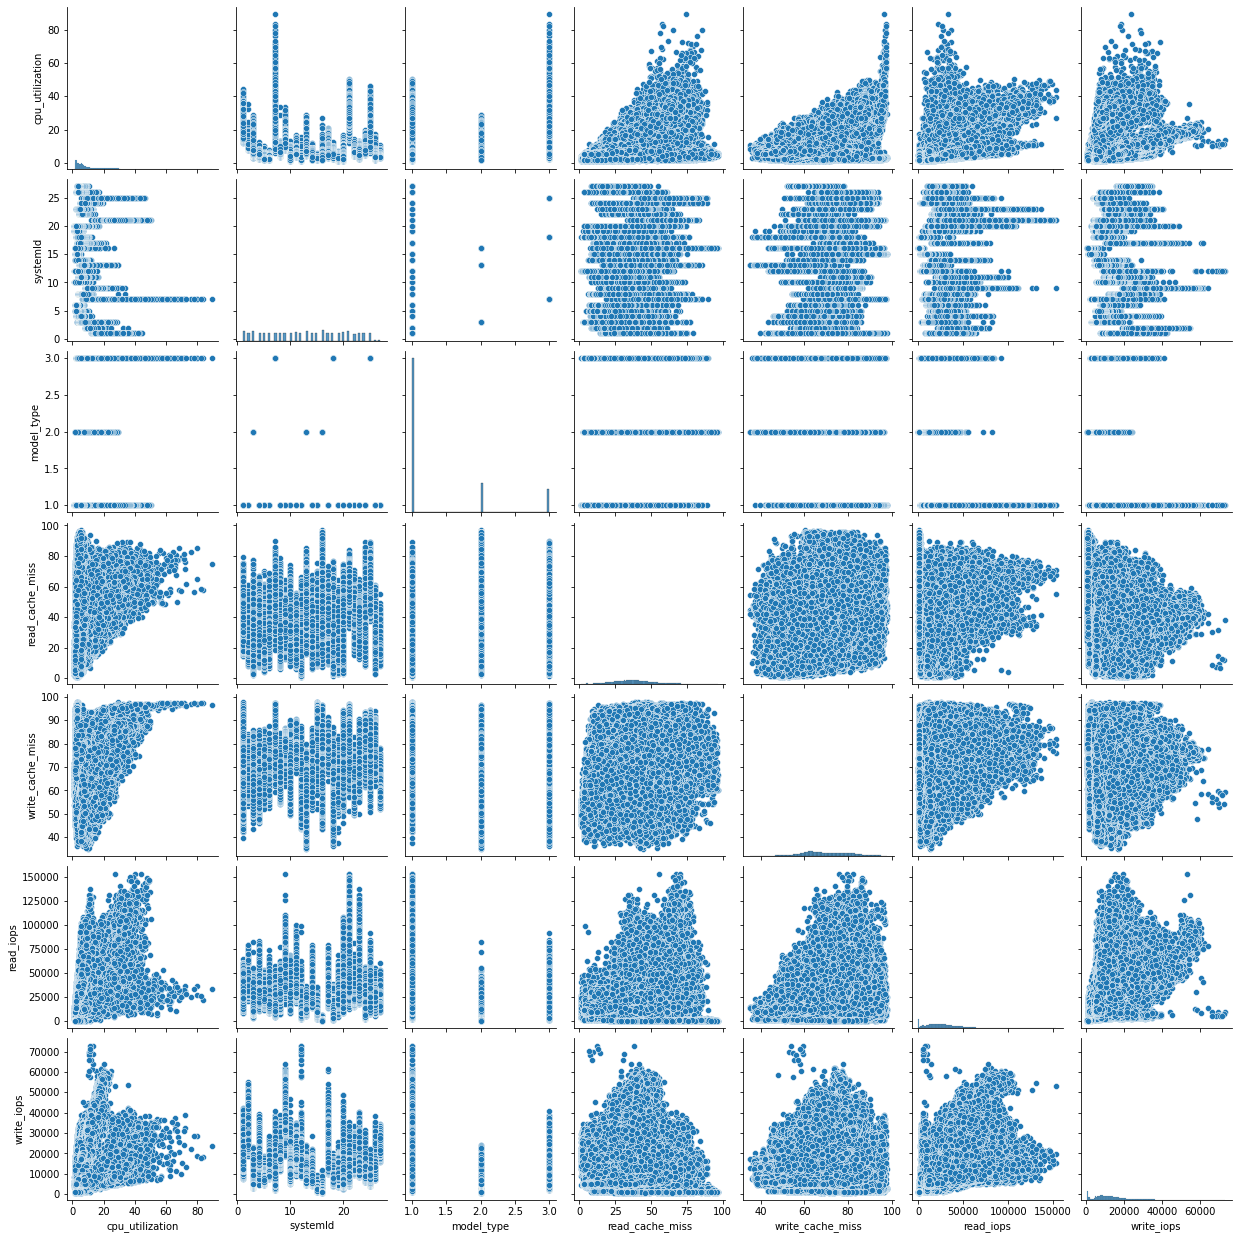

In [19]:
cols = ['cpu_utilization', 'systemId', 'model_type', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops']
sns.pairplot(df[cols])


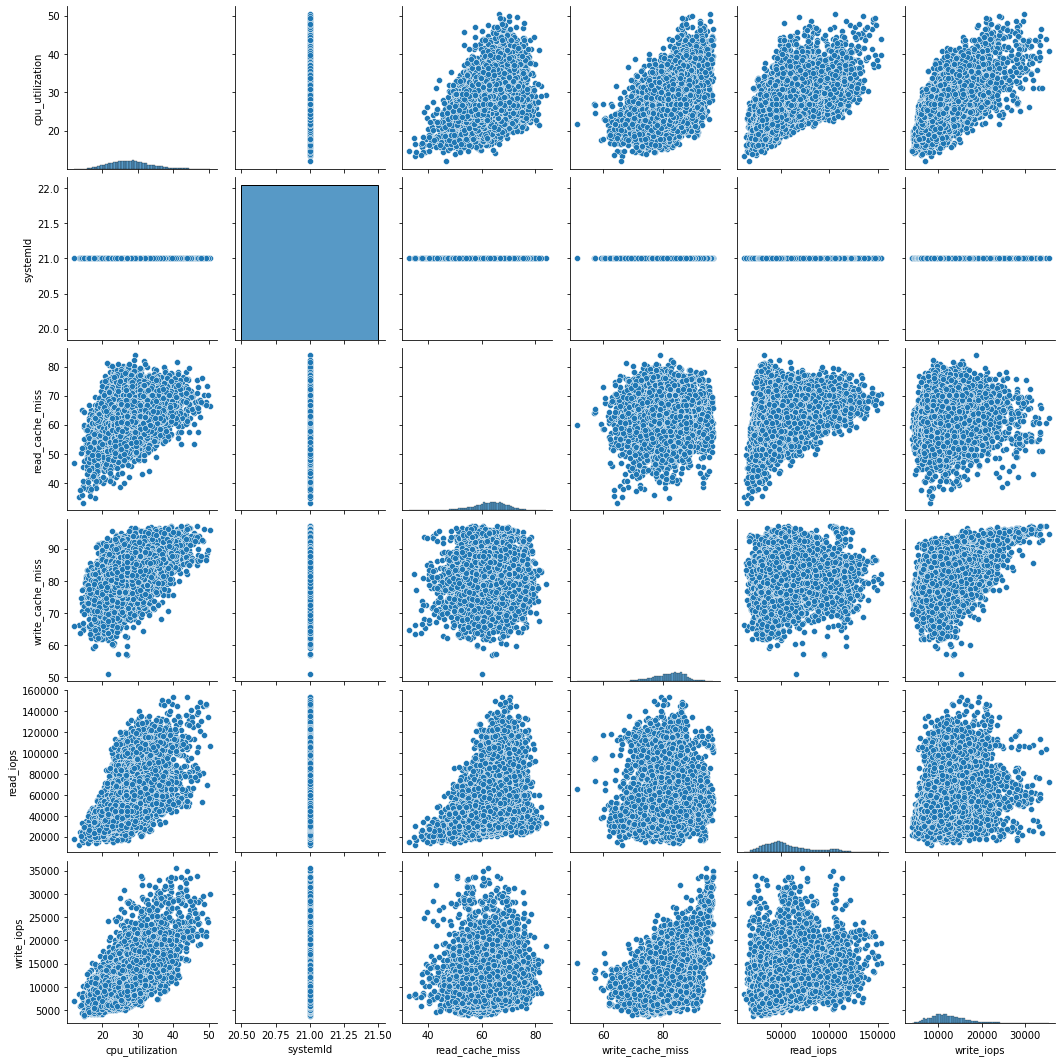

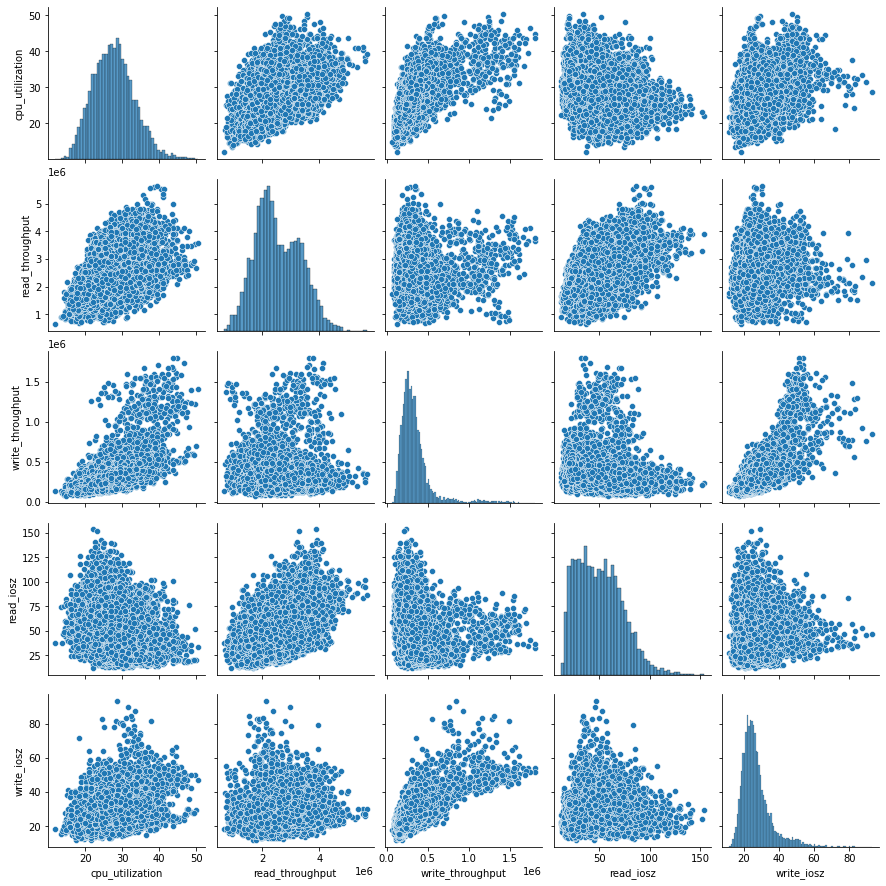

In [20]:
def pair_plot(df, systemId_to_plot):
  df16 = df[df['systemId']==systemId_to_plot]

  cols = ['cpu_utilization', 'systemId', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops']
  sns.pairplot(df16[cols])

  cols = ['cpu_utilization', 'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz']
  sns.pairplot(df16[cols])

systemId_to_plot = 21
pair_plot(df, systemId_to_plot)

In [21]:
# Find the categorical columns that have levels in train data set but not in test/validation dataset
# Either write a custome encoder to deal with these missing levels OR drop them?

# All categorical columns
from sklearn.model_selection import train_test_split
X_train, X_valid = train_test_split(df, test_size=TEST_SIZE/1000, shuffle=True)

object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

# Columns that can be safely label encoded
good_label_cols = [col for col in object_cols if 
                   set(X_train[col]) == set(X_valid[col])]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))
        
print(X_train.shape, X_train.columns)
print(X_valid.shape, X_valid.columns)
print('Categorical columns that will be label encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)


(175469, 13) Index(['systemId', 'model_type', 'cpu_utilization', 'read_cache_miss',
       'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput',
       'write_throughput', 'read_iosz', 'write_iosz', 'timestamp_seconds',
       'Datetime'],
      dtype='object')
(36, 13) Index(['systemId', 'model_type', 'cpu_utilization', 'read_cache_miss',
       'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput',
       'write_throughput', 'read_iosz', 'write_iosz', 'timestamp_seconds',
       'Datetime'],
      dtype='object')
Categorical columns that will be label encoded: []

Categorical columns that will be dropped from the dataset: []


In [22]:
print(X_train.shape, X_valid.shape)


(175469, 13) (36, 13)


In [23]:
def check_dataframe(df, systemId_selected):
  if systemId_selected[0] != 'All':
    df = df[df['systemId']==systemId_selected[0]]

  print(f'For systemId of {systemId_selected}:')
  print(f' df shape = {df.shape}, df.index.shape = {df.index.shape}')
  print(f' df.columns.shape = {df.columns.shape}')
  print(f' df.columns = {df.columns}')
  print(f' \n *** df head *** \n {df.head()}')
  print(f' \n ***df tail *** \n {df.tail()}')
  print(f' \n ***df.describe *** \n {df.describe().T}')
  print(f' \n ***df.info *** \n')
  print(f'{df.info()}')


In [24]:
check_dataframe(df, ['All'])

For systemId of ['All']:
 df shape = (175505, 13), df.index.shape = (175505,)
 df.columns.shape = (13,)
 df.columns = Index(['systemId', 'model_type', 'cpu_utilization', 'read_cache_miss',
       'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput',
       'write_throughput', 'read_iosz', 'write_iosz', 'timestamp_seconds',
       'Datetime'],
      dtype='object')
 
 *** df head *** 
                      systemId  ...            Datetime
Datetime                       ...                    
2019-11-01 00:00:00        26  ... 2019-11-01 00:00:00
2019-11-01 00:00:00        27  ... 2019-11-01 00:00:00
2019-11-01 00:05:00        27  ... 2019-11-01 00:05:00
2019-11-01 00:05:00        26  ... 2019-11-01 00:05:00
2019-11-01 00:10:00        27  ... 2019-11-01 00:10:00

[5 rows x 13 columns]
 
 ***df tail *** 
                      systemId  ...            Datetime
Datetime                       ...                    
2019-11-30 23:55:00         3  ... 2019-11-30 23:55:00
2019-11

In [25]:
check_dataframe(df, SYSTEM_ID_SELECTED)

For systemId of [1]:
 df shape = (7926, 13), df.index.shape = (7926,)
 df.columns.shape = (13,)
 df.columns = Index(['systemId', 'model_type', 'cpu_utilization', 'read_cache_miss',
       'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput',
       'write_throughput', 'read_iosz', 'write_iosz', 'timestamp_seconds',
       'Datetime'],
      dtype='object')
 
 *** df head *** 
                      systemId  ...            Datetime
Datetime                       ...                    
2019-11-01 04:25:00         1  ... 2019-11-01 04:25:00
2019-11-01 04:30:00         1  ... 2019-11-01 04:30:00
2019-11-01 04:35:00         1  ... 2019-11-01 04:35:00
2019-11-01 04:40:00         1  ... 2019-11-01 04:40:00
2019-11-01 04:45:00         1  ... 2019-11-01 04:45:00

[5 rows x 13 columns]
 
 ***df tail *** 
                      systemId  ...            Datetime
Datetime                       ...                    
2019-11-30 23:35:00         1  ... 2019-11-30 23:35:00
2019-11-30 23:4

In [26]:
dtypes_all = np.unique(df.dtypes)
print(dtypes_all, '\n', df.dtypes)

[dtype('int64') dtype('float64') dtype('<M8[ns]')] 
 systemId                      int64
model_type                    int64
cpu_utilization             float64
read_cache_miss             float64
write_cache_miss            float64
read_iops                   float64
write_iops                  float64
read_throughput             float64
write_throughput            float64
read_iosz                   float64
write_iosz                  float64
timestamp_seconds           float64
Datetime             datetime64[ns]
dtype: object


In [27]:
unique_counts = pd.DataFrame.from_records([(col, df[col].nunique()) for col in df.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
print(unique_counts)

          Column_Name  Num_Unique
1          model_type           3
0            systemId          27
11  timestamp_seconds        8640
12           Datetime        8640
4    write_cache_miss      172915
3     read_cache_miss      173966
10         write_iosz      174532
9           read_iosz      174789
6          write_iops      174958
5           read_iops      174970
7     read_throughput      175024
8    write_throughput      175028
2     cpu_utilization      175040


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175505 entries, 2019-11-01 00:00:00 to 2019-11-30 23:55:00
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   systemId           175505 non-null  int64         
 1   model_type         175505 non-null  int64         
 2   cpu_utilization    175505 non-null  float64       
 3   read_cache_miss    175505 non-null  float64       
 4   write_cache_miss   175505 non-null  float64       
 5   read_iops          175505 non-null  float64       
 6   write_iops         175505 non-null  float64       
 7   read_throughput    175505 non-null  float64       
 8   write_throughput   175505 non-null  float64       
 9   read_iosz          175505 non-null  float64       
 10  write_iosz         175505 non-null  float64       
 11  timestamp_seconds  175505 non-null  float64       
 12  Datetime           175505 non-null  datetime64[ns]
dtypes: datetim

In [29]:
def plot_num_systems_per_model(df):
  # count number of model_types for each level of systemId
  #for systemId in np.unique(df['systemId']):
  sns.set(rc={'figure.figsize':(19,3)})
  df_groupby_moddel_type = pd.DataFrame()
  df_groupby_moddel_type['systemId_list'] = df.groupby(['model_type'])['systemId'].unique()
  df_groupby_moddel_type['num_systemIds'] = [len(x) for x in df_groupby_moddel_type['systemId_list']]
  ax = sns.barplot(data=df_groupby_moddel_type, y='num_systemIds', x=df_groupby_moddel_type.index )
  sys = df_groupby_moddel_type.systemId_list

  legend = df_groupby_moddel_type['systemId_list']
  #legend = legend.apply(lambda x: ','.join(x))
  ax.legend(legend.values)      
  plt.title('number of systemIds per model_type')
  print(df_groupby_moddel_type, df_groupby_moddel_type.index)


# hist of categorical regressors
def hist_categorical_allSystems(df):
  sns.set(rc={'figure.figsize':(16,3)})

  plt.figure()
  sns.histplot(data=df, x="model_type", hue="systemId", multiple="stack", shrink=5, legend=False)
  _ = plt.xticks(rotation=90)
  # {“layer”, “dodge”, “stack”, “fill”}

  plt.figure()
  sns.histplot(data=df, x="systemId", hue="model_type", multiple="stack", shrink=1)
  _ = plt.xticks(rotation=90)




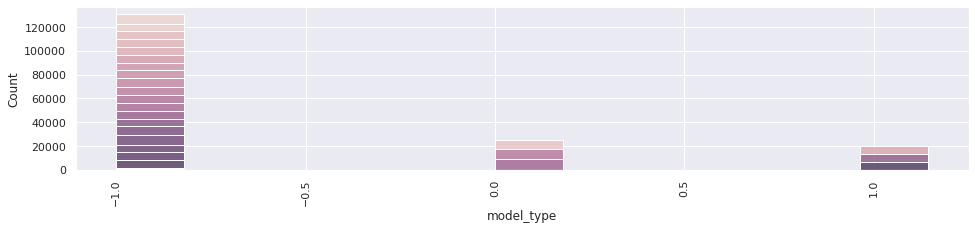

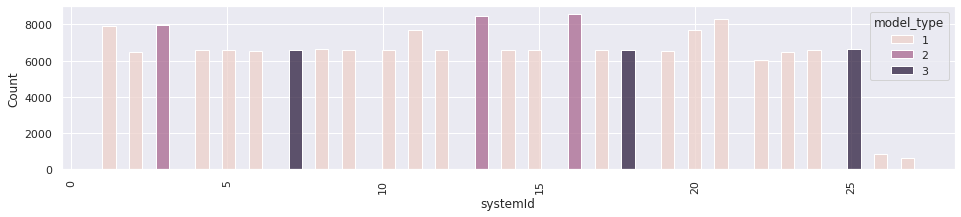

In [30]:
hist_categorical_allSystems(df)


                                                systemId_list  num_systemIds
model_type                                                                  
1           [26, 27, 20, 17, 10, 24, 9, 14, 2, 1, 15, 4, 6...             21
2                                                 [16, 13, 3]              3
3                                                 [18, 7, 25]              3 Int64Index([1, 2, 3], dtype='int64', name='model_type')


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


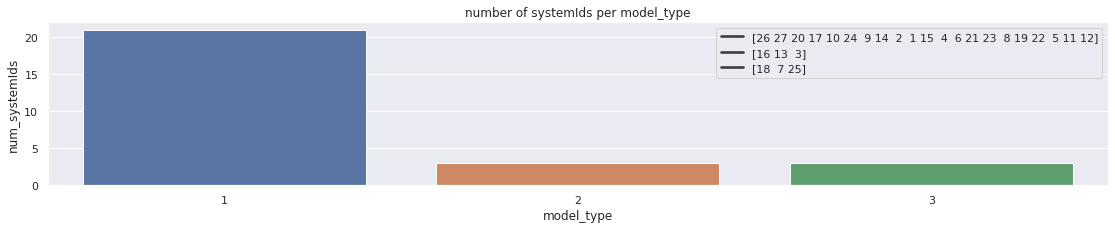

In [31]:
plot_num_systems_per_model(df)


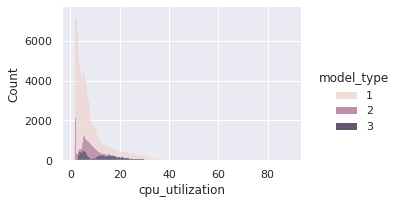

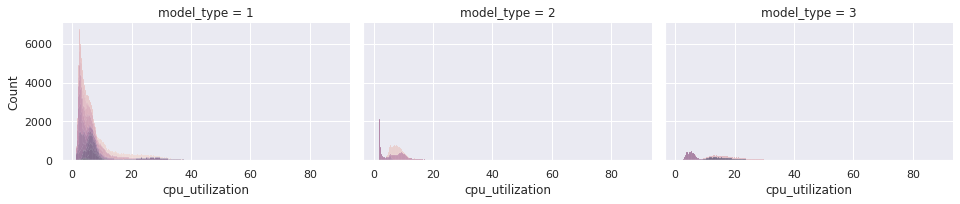

In [32]:
sns.displot(data=df, x=TARGET_FEATURE, hue='model_type', multiple='stack',height=3, aspect=1.5 )
# hist of target separated per model_type, each is stacked color coded by systemId
# histogram as default of displot
sns.displot(data=df, x=TARGET_FEATURE, hue="systemId", multiple='stack', col="model_type", legend=False, height=3, aspect=1.5)

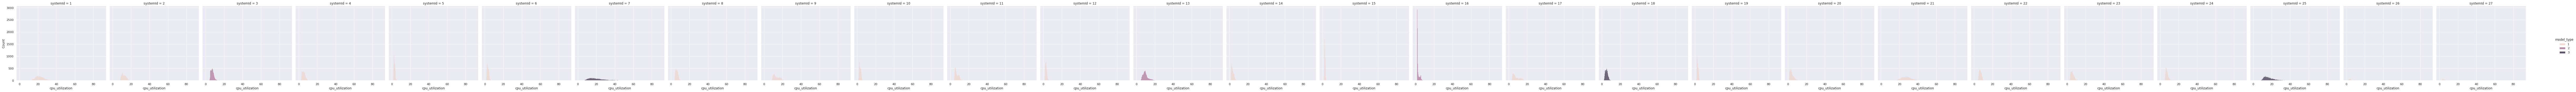

In [33]:
# hist of target separated per systemId, each hist is stacked color coded by model_type A/B/C
sns.displot(data=df, x=TARGET_FEATURE, hue="model_type", multiple='stack', col="systemId", )


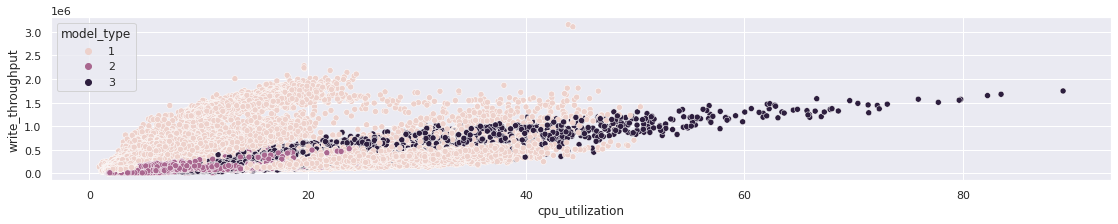

In [34]:
sns.scatterplot(data=df, x=TARGET_FEATURE, y="write_throughput", hue="model_type")


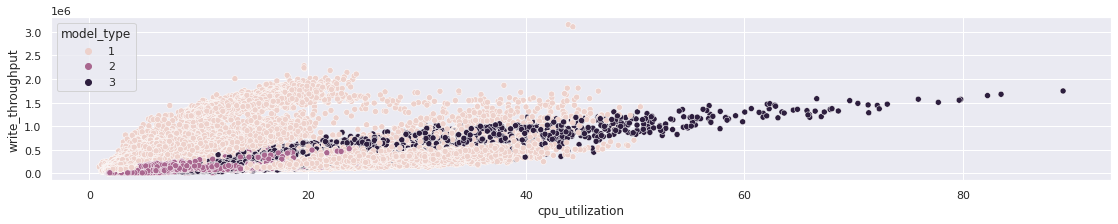

In [35]:
sns.scatterplot(data=df, x=TARGET_FEATURE, y="write_throughput", hue="model_type")


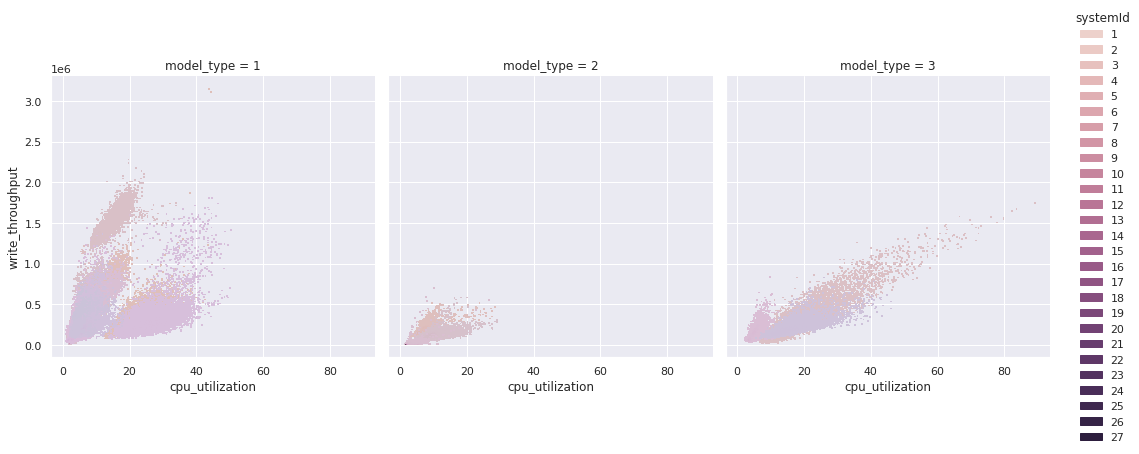

In [36]:
sns.displot(data=df, x=TARGET_FEATURE, y="write_throughput", hue='systemId', col="model_type")


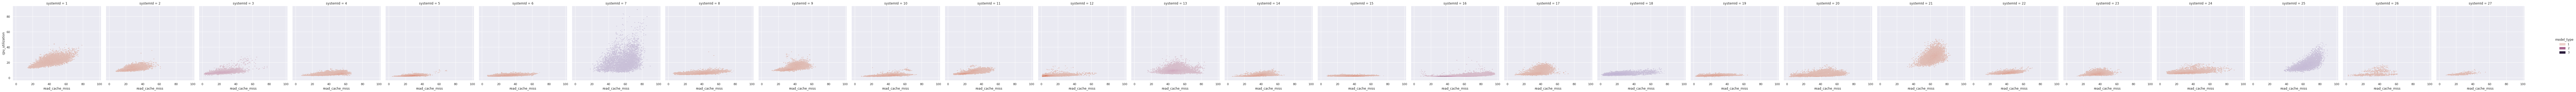

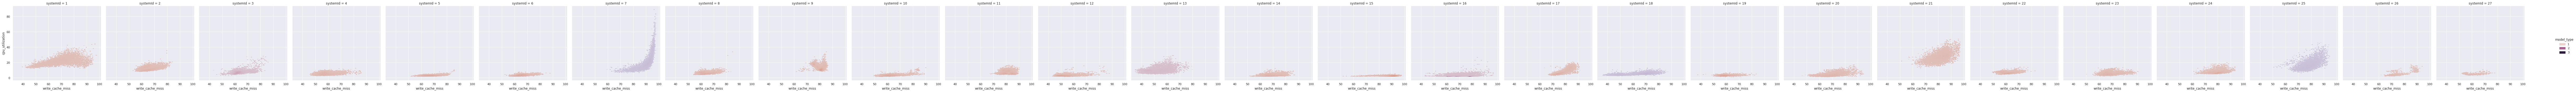

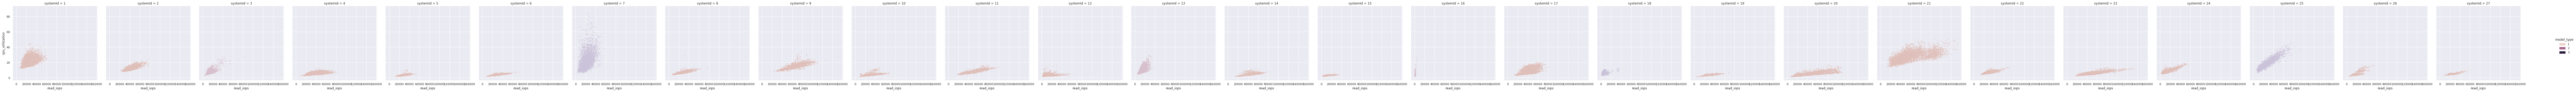

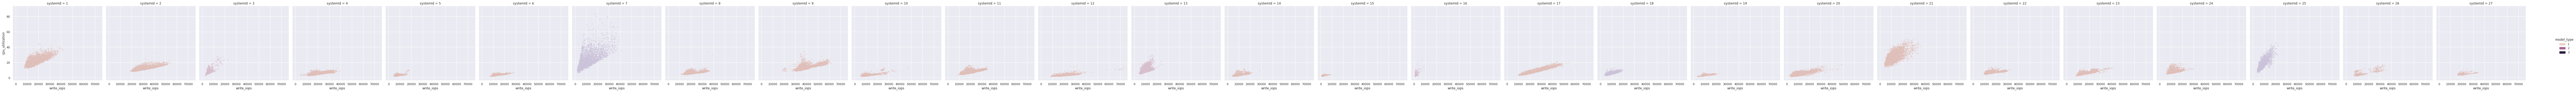

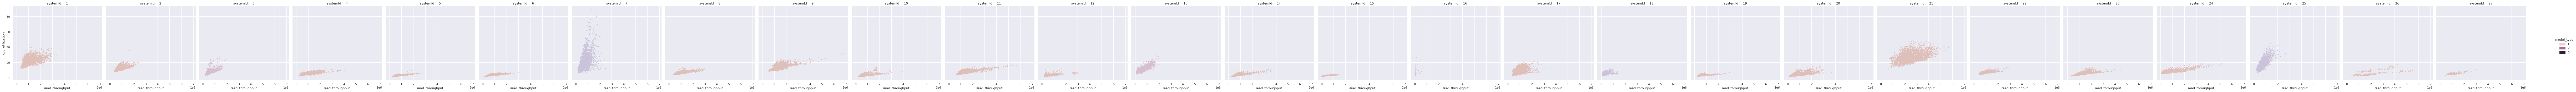

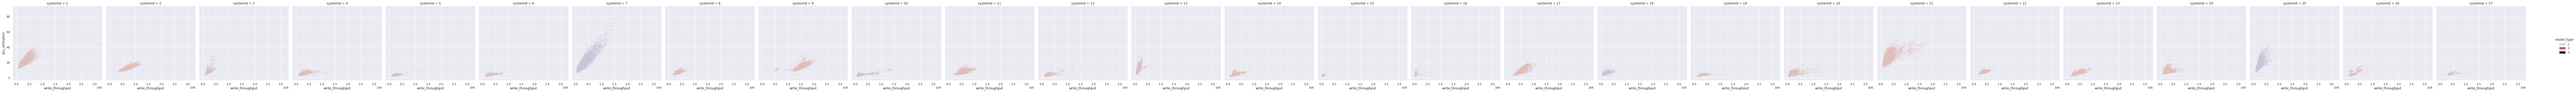

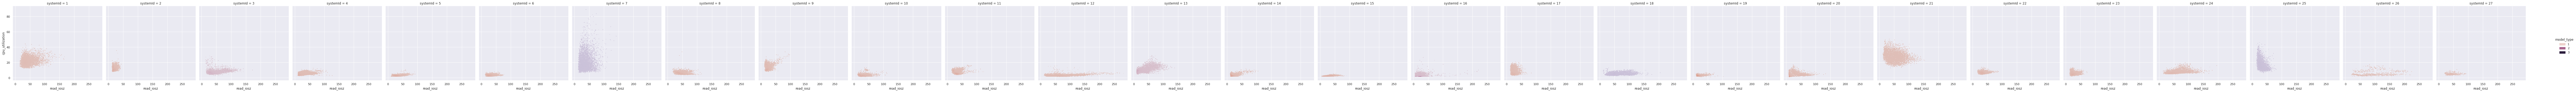

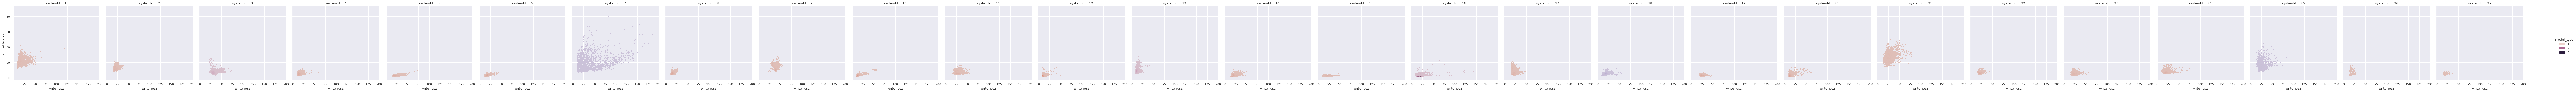

In [37]:
x_cols = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput',
       'write_throughput', 'read_iosz', 'write_iosz']
for col in x_cols:       
  sns.displot(data=df, x=col, y=TARGET_FEATURE, hue='model_type', col="systemId")


In [38]:
def scatter_plot_per_systemId(df):
  model_types = np.unique(df['model_type'])
  for model_type in model_types:
    df_tmp = df[df['model_type']==model_type]

    g = sns.displot(data=df_tmp, x=TARGET_FEATURE, y="write_throughput", col="systemId")
    g.set_titles("systemId {col_name}") # trick: as above has col='systemId'


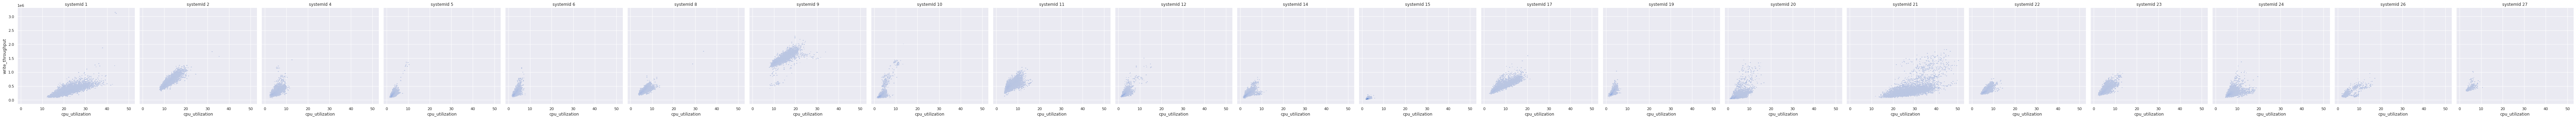

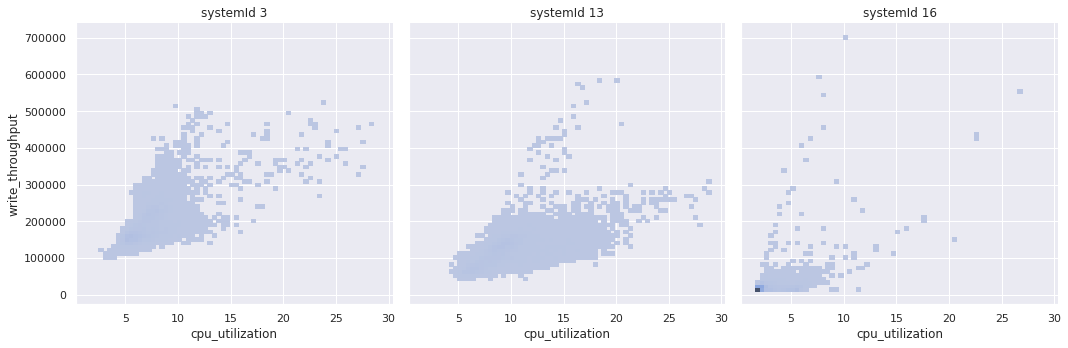

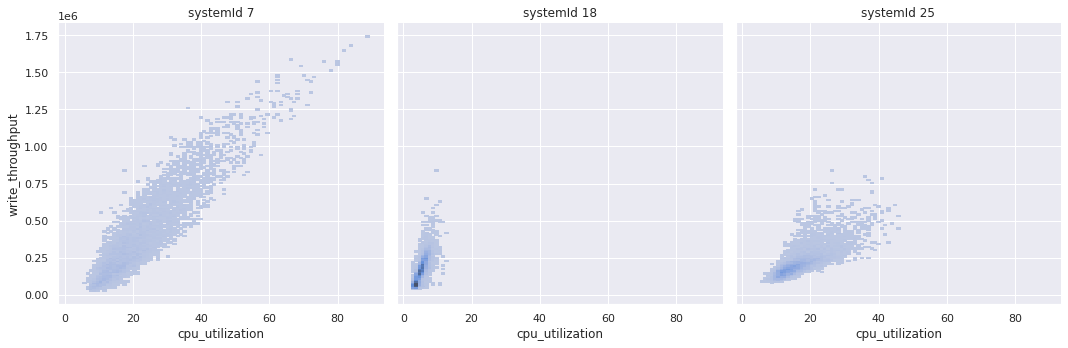

In [39]:
scatter_plot_per_systemId(df)

Scatter plot of y vs write_throughput shows:
1. For model_type B and C, write_throughput is strongly corelated with cpu_utilization
This can be explained by the fact that there are only 3 of systemIds in A and B.

2.


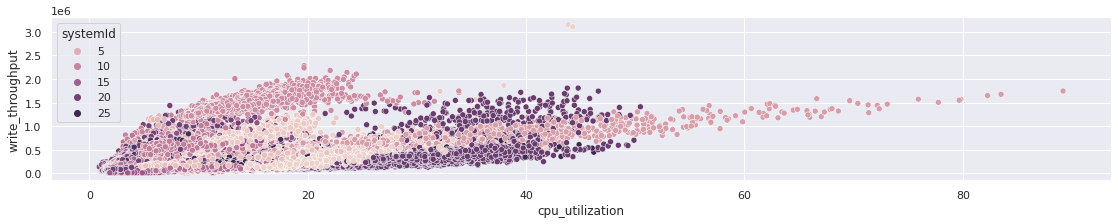

In [40]:
sns.scatterplot(data=df, x=TARGET_FEATURE, y="write_throughput", hue="systemId")


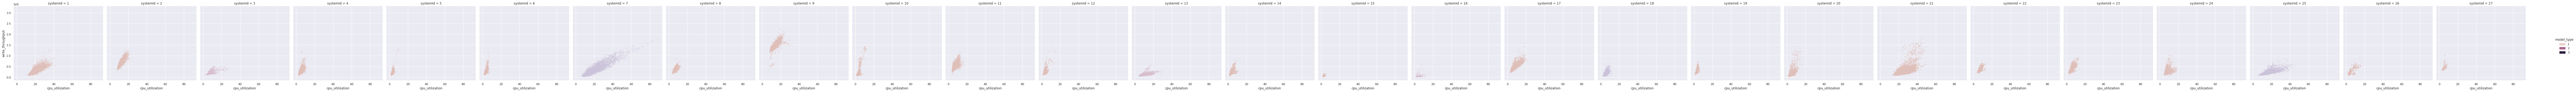

In [41]:
sns.displot(data=df, x=TARGET_FEATURE, y="write_throughput", col="systemId", hue="model_type")


In [42]:
df.columns

Index(['systemId', 'model_type', 'cpu_utilization', 'read_cache_miss',
       'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput',
       'write_throughput', 'read_iosz', 'write_iosz', 'timestamp_seconds',
       'Datetime'],
      dtype='object')

In [43]:
def plot_y_x(df, X_features, target_feature, hist, univariate, title):
  from math import ceil
  X_features.remove(target_feature)
  num_figs = len(X_features)
  cols = 4
  rows = ceil(num_figs/cols)

  sns.set(rc={'figure.figsize':(18,4*rows)})
  for fig_idx, col in enumerate(X_features):
    plt.subplot(rows, cols, fig_idx+1)
    if hist:
      if univariate:
        sns.histplot(data=df, x=col,  hue="model_type", multiple="layer")
      else:
        sns.histplot(data=df, x=col, y=target_feature, cbar=True)
    else:
      sns.scatterplot(data=df, x=col, y=target_feature)

  fig = plt.gcf()
  fig.suptitle(title)
  plt.tight_layout()
  fig.subplots_adjust(top=0.95) # last in fig setting
  plt.show()


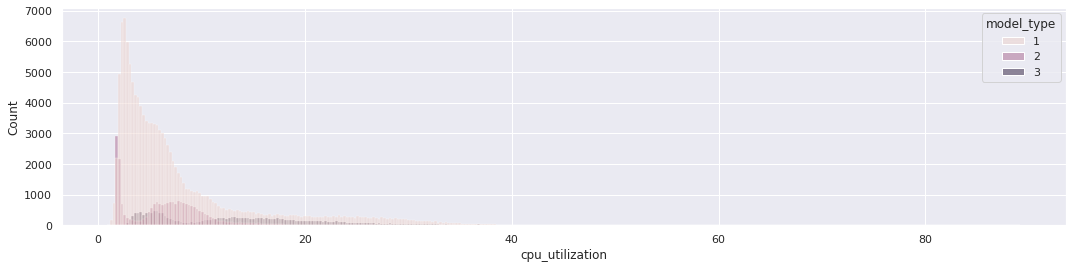

In [44]:
# Hist plot  of y
sns.set(rc={'figure.figsize':(18,4)})
sns.histplot(data=df, x=TARGET_FEATURE,  hue="model_type", multiple="layer")


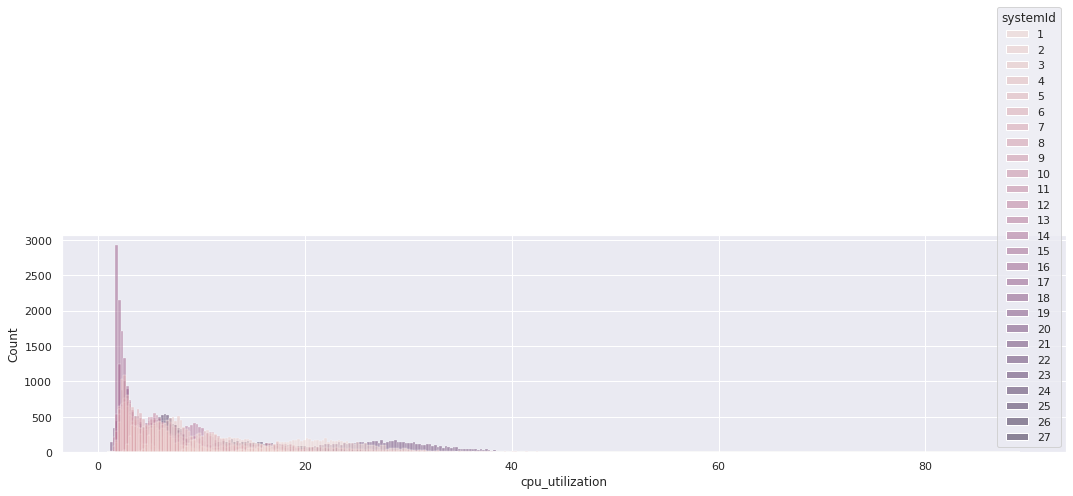

In [45]:
# layered Hist plot  of y 
#multiple{“layer”, “dodge”, “stack”, “fill”}
sns.set(rc={'figure.figsize':(18,4)})
sns.histplot(data=df, x=TARGET_FEATURE,  hue='systemId', multiple="layer")


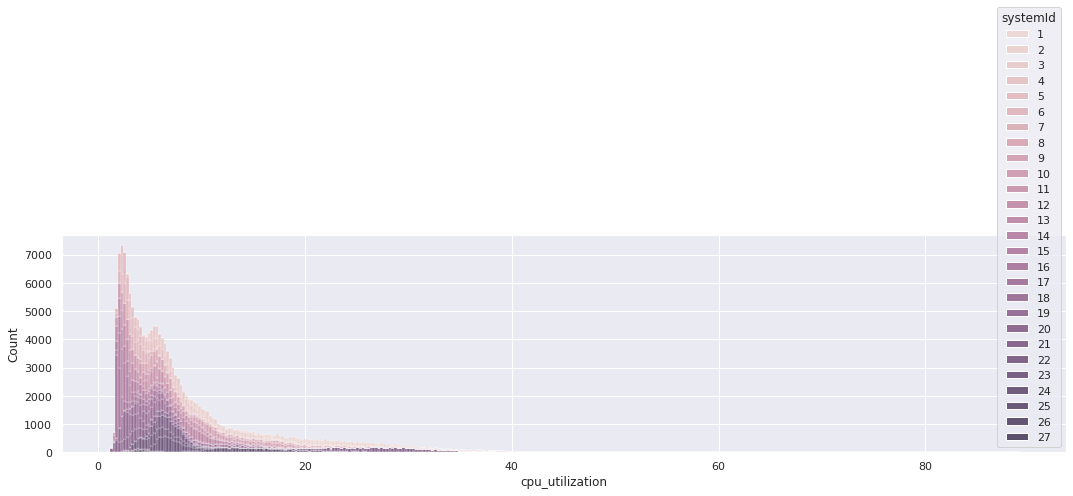

In [46]:
# stacked Hist plot  of y 
sns.set(rc={'figure.figsize':(18,4)})
sns.histplot(data=df, x=TARGET_FEATURE,  hue='systemId', multiple="stack")


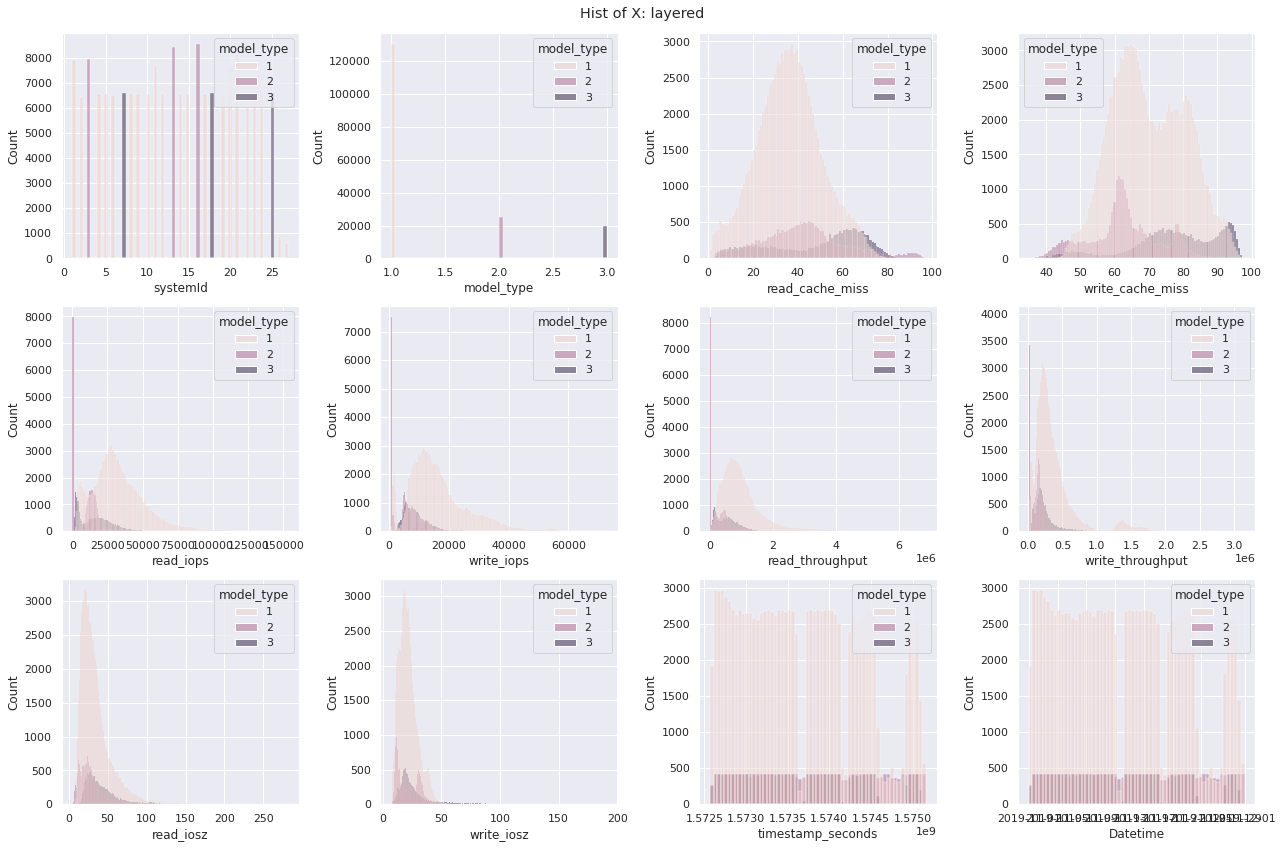

In [47]:
# Hist plot  of X
hist_plot = True
univariate = True
title = 'Hist of X: layered'
X_features = list(df.columns)
y_feature = TARGET_FEATURE
plot_y_x(df, X_features, y_feature, hist_plot, univariate, title)


In [48]:
df.columns

Index(['systemId', 'model_type', 'cpu_utilization', 'read_cache_miss',
       'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput',
       'write_throughput', 'read_iosz', 'write_iosz', 'timestamp_seconds',
       'Datetime'],
      dtype='object')

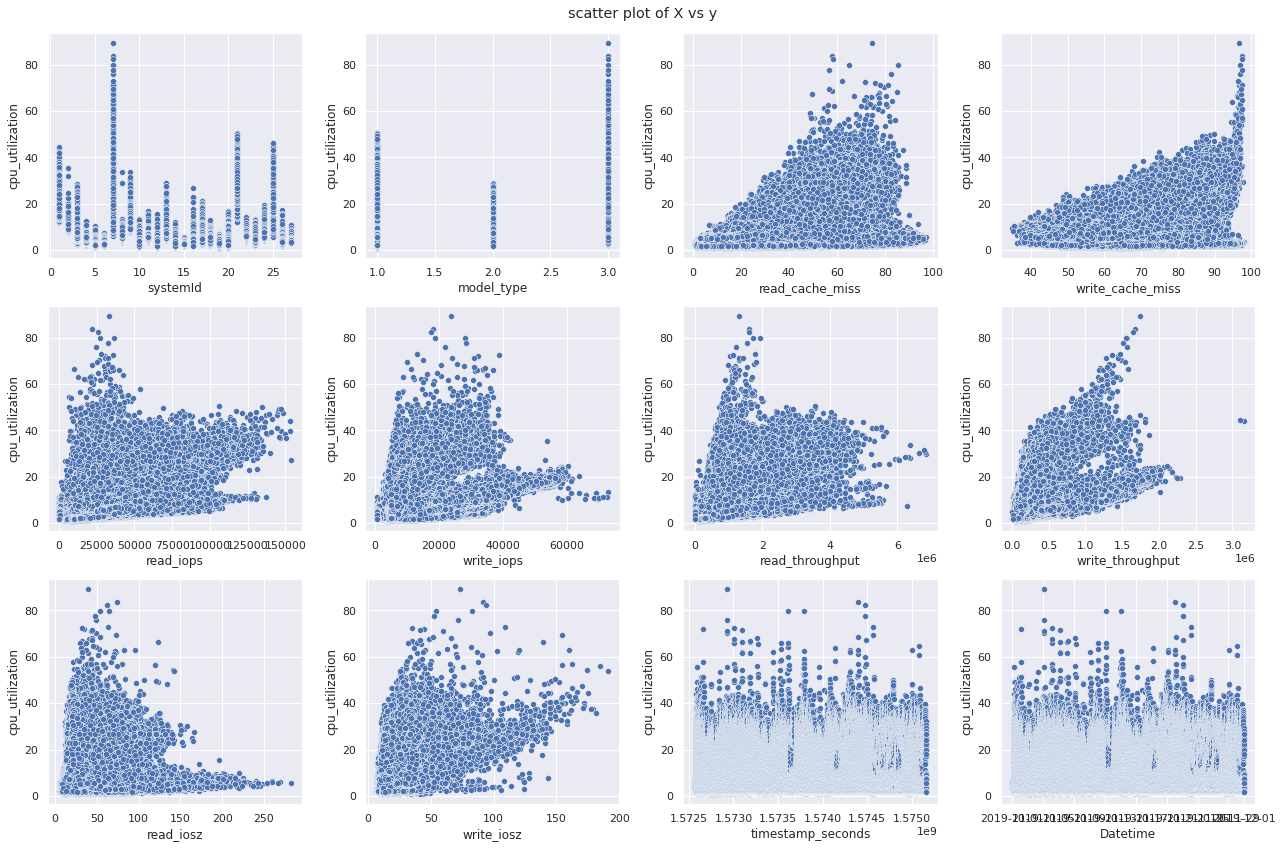

In [49]:
# scatter plot  of X and y
hist_plot = False
univariate = False
title = 'scatter plot of X vs y'
X_features = list(df.columns)
y_feature = TARGET_FEATURE
plot_y_x(df, X_features, y_feature, hist_plot, univariate, title)


In [50]:
# bi-variate hist of X and y
hist_plot = True
title = 'Hist of X vs y'
X_features = list(df.columns)
y_feature = TARGET_FEATURE

plot_y_x(df, X_features, y_feature, hist_plot, title)


TypeError: ignored

In [ ]:
# inspect joint distribution of df's features
# The top 2 important regressors rated by both methods are: ['write_iops', 'write_throughput']

def plot_pair(df, title):
  cols = ['cpu_utilization', 'read_throughput', 'write_throughput'] 
  g = sns.pairplot(df[cols])
  g.fig.suptitle(title, y=1.02) # y= some height>1

  cols = ['cpu_utilization', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', ] 
  g = sns.pairplot(df[cols])
  g.fig.suptitle(title, y=1.02) # y= some height>1

  cols = ['cpu_utilization', 'systemId', 'timestamp_seconds', 'model_type', 'read_iops', 'write_iops']
  g = sns.pairplot(df[cols])
  g.fig.suptitle(title, y=1.02) # y= some height>1



In [ ]:
# inspect joint distribution of between y and the predictors for all systemIds altogether
title = f"pairwise relationships of all systemIds" 
plot_pair(df, title)


In [ ]:
# Plot a joint distribution of target and regressors for a single systemId level
df_tmp = df[df['systemId']==SYSTEM_ID_SELECTED[0]]
title = f"pairwise relationships of {SYSTEM_ID_SELECTED[0]}" 
plot_pair(df_tmp, title)


# Observations:


*   The target y and most of predictors are skewed and are not close to normal distributed.
Thus power transform will be needed.
*   The y row shows that the y is a function of all the other parameters except for timestamp. Looking at the other rows it should be clear that they are functions of each other except for timestamp.




In [ ]:
df.describe().transpose()


# The overall statistics show:

*   feature covers a very different range, thus need standarization;
*   no clear outliers as 75 percentiles are close to max for all





In [ ]:
df_groupby_systemId = pd.DataFrame()
df_groupby_systemId['model_type_list'] = df.groupby(['systemId'])['model_type'].unique()
df_groupby_systemId['num_model_type'] = [len(x) for x in df_groupby_systemId['model_type_list']]
df_groupby_systemId.plot(kind='bar')
fig = plt.gcf()
fig.set_size_inches(15, 3)
#print(df_groupby_systemId)

In [ ]:
# Check count of samples per level of categorical features
for idx_fig, cat in enumerate(category_features):  
  grouped = df.groupby([cat])[TARGET_FEATURE].count()
  print(f'y_group_count: type={type(grouped)}, shape={grouped.shape}')
  grouped.plot(kind='bar', subplots=True, fontsize=20, grid=True, title=f'Count of samples per level of {cat}')

  fig = plt.gcf()
  fig.set_size_inches(18.5, 5)
  plt.tight_layout()
  fig.subplots_adjust(top=0.8) # last in fig setting
  plt.show()


In [ ]:
# Check mean of samples per level of categorical features
for idx_fig, cat in enumerate(category_features):  
  grouped = df.groupby([cat]).mean([TARGET_FEATURE])

  print(f'y_group_count: type={type(grouped)}, shape={grouped.shape}')
  grouped.plot(kind='bar', subplots=True, fontsize=20, grid=True, title=f'mean of samples per level of {cat}')

  fig = plt.gcf()
  fig.set_size_inches(18.5, 16)
  plt.tight_layout()
  fig.subplots_adjust(top=0.9) # last in fig setting
  plt.show()

# Observation of categorical features:


*   Each systemId level has a single model_type level
*   model_type A, B, C have [21,3,3] systemIds
*   model_type A, B, C have [120k,22k,20k] samples
*   model_type A, B, C have different mean of target roughly [8, 6, 15]

More systems are using modell_type A;
Higher cpu utilization is for modell_type C;



# Observations:
*   The number of levels of systemId is 27 which is large when OneHotEncode is used and will have problem when Tree based model is used;
This is heteroskedastic as each systemId has different variance.

*  Therefore, it is better to apply a separate model for each systemId thus avoiding the need of OneHotEncodeing for large number of levels 27 here.
*  Not using OneHotEncoder also avoids the complication caused when new systemId level appaears in future in test/product stage. This problem can be sovled by detecting new systemId level at top level design.

> The number of samples of sys26 and sys27 are about 1/8 of the rest systemIds.

* The number of samples of model_type B and C are about 1/6 of that of A.

  > The Train/Test split MUST consider the different size of samples for each systemID and model_type7


# Initial estimation of feature importance using Tree-based models to avoid the need of encoders for categorical features.



In [ ]:
df.columns

In [ ]:
# get X and y from df
def get_X_y(df, features_not_X, systemId_selected):
  if systemId_selected[0] != 'All':
    df = df[df['systemId']==systemId_selected[0]]
  X_features = list(df.columns)
  for col in features_not_X:
    X_features.remove(col)
  df_X = df[X_features]
  df_y = df[TARGET_FEATURE]
  return df_X, df_y

In [ ]:
# plot univariate f_regression and mutual_info_regression results
def plot_feature_score(df_X, df_y, systemId):
  from sklearn.feature_selection import f_regression, mutual_info_regression
  from sklearn.pipeline import make_pipeline
  from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PowerTransformer

  X_cols = df_X.columns

  if 0:
    pipeline = make_pipeline(
      PowerTransformer(method='yeo-johnson', standardize=False, copy=True), 
      MinMaxScaler()  
    )

    df_X = pipeline.fit_transform(df_X)
    y_pipeline = make_pipeline(
      PowerTransformer(method='cox-box', standardize=False, copy=True), 
      MinMaxScaler()  
    )
    df_y = df_y.values
    df_y = df_y.reshape(df_y.shape[0],1)
    df_y = pipeline.fit_transform(df_y)

  f_test, _ = f_regression(df_X, df_y)
  f_test /= np.max(f_test)

  plt.figure(figsize=(18, 3*2))
  ax1 = plt.subplot(2,1,1)
  plt.bar(X_cols, f_test, width=.2, label='f_test from f_regression')
  plt.xticks(rotation=90); plt.legend(fontsize='large'); plt.grid()
  plt.setp(ax1.get_xticklabels(), visible=False)
  plt.title(f' F-test of Features with {TARGET_FEATURE} for systemId of {systemId}')

  if systemId_selected[0] != 'All':
    mi = mutual_info_regression(df_X, df_y)
    mi /= np.max(mi)

    ax2 = plt.subplot(2,1,2, sharex=ax1, sharey=ax1)
    plt.bar(X_cols, mi, width=.2, label='mi from mutual_info_regression')
    plt.xticks(rotation=60); plt.legend(fontsize='large'); plt.grid()
    plt.title(f' mutual information of Features with {TARGET_FEATURE} for systemId of {systemId}')

  fig = plt.gcf()
  fig.set_size_inches(18.5, 6)
  plt.tight_layout()
  fig.subplots_adjust(top=0.8) # last in fig setting
  plt.show()

  print(f'f_test={f_test}\n mi={f_test}' )




In [ ]:
print(__doc__)

from sklearn import set_config
set_config(display='diagram')

In [ ]:
# Feature importance of a SINGLE systemId SYSTEM_ID_SELECTED: F-test and mutual_info_regression 
systemId_selected = SYSTEM_ID_SELECTED 
features_not_X = [TARGET_FEATURE] + ['systemId',  'model_type'] + ['Datetime'] # 'timestamp',
df_X, df_y = get_X_y(df, features_not_X, systemId_selected)
from sklearn.feature_selection import mutual_info_regression
plot_feature_score(df_X, df_y, systemId_selected)

In [ ]:
# DO NOT RUN this as RAM hungary and crash
# Feature importance of all systemIds: F-test and mutual_info_regression 
systemId_selected = ['All'] 
features_not_X = [TARGET_FEATURE] + ['systemId',  'model_type'] + ['Datetime'] # 'timestamp',
df_X, df_y = get_X_y(df, features_not_X, systemId_selected)
from sklearn.feature_selection import mutual_info_regression
plot_feature_score(df_X, df_y, systemId_selected)

# Feature Importance Rating by F-test and mutual information

*   As F-test captures only linear dependency, it rates more features as less important than discriminative feature;

* The top 2 important regressors rated by both methods are: 
['write_iops', 'write_throughput']

*   Both F-test and mutual information rate the first 6 features ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops',
       'read_throughput', 'write_throughput'] as important

*   F-test only rates ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput'] as important;

*   [ 'read_iosz', 'Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos' ]  are rated as not important by both methods;

*   Compared with F-test results, mutual information method found these medium-level important features: 
['write_iosz', 'timestamp_seconds', 'Week_Sin', 'Week_Cos', 'Hours_Of_Datetime', 'Minutes_Of_Datetime', 'Day_Of_Week'],




In [ ]:
df.columns

Base on regression model's permutation importance, the top 5 featurs are:
1. write_throughput, 
2. write_iops, 
3. read_throughput, 
4. read_cache_miss,
5. read_iops

Base on calssification model's permutation importance, the top 5 featurs are:
 1. write_iops,   
 2. write_throughput, 
 3. read_throughput, 
 4. read_cache_miss,
 5. read_iops

Based on correlation with target cpu_utilization:
(run: plot_corr(df, SYSTEM_ID_SELECTED))
1. write_throughput     0.774564
2. write_iops           0.758773
3. read_cache_miss      0.620105
4. read_throughput      0.483752
5. write_cache_miss     0.453977
6. read_iops            0.356857








In [ ]:
print(type(Y_cat), Y_cat.shape)


Permutation Importance


In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
selector_f_regression = SelectKBest(f_regression, k=4)
title = 'Result of SelectKBest(f_regression, k=4)'
feature_importance_plot(selector_f_regression, df_X, df_y, title)

In [ ]:
df_X.columns

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
selector_f_regression = SelectKBest(f_regression, k=4)
title = 'Result of SelectKBest(f_regression, k=4)'
plot_feature_score(selector_f_regression, df_X, df_y, title)

In [ ]:
def plot_feature_importance_treebased(pipeline, title):
  pipeline.fit(df_X, df_y)

  print('Regression score without selecting features: {:.3f}'
        .format(pipeline.score(df_X, df_y)))

  feature_importances = pipeline[-1].feature_importances_
  plt.figure(figsize=(18, 3))
  plt.bar(df_X.columns, feature_importances, width=.2)
  plt.title(title)
  plt.grid()



In [ ]:
def plot_feature_importance_linear_regression(pipeline, title):
  pipeline.fit(df_X, df_y)

  print('Regression score without selecting features: {:.3f}'
        .format(pipeline.score(df_X, df_y)))

  feature_importances = np.abs(pipeline[-1].coef_)
  plt.figure(figsize=(18, 3))
  plt.bar(df_X.columns, feature_importances, width=.2)
  plt.title(title)
  plt.grid()


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PowerTransformer
from sklearn.model_selection import train_test_split

# #############################################################################
# Compare to the weights of an DecisionTreeRegressor
pipeline = make_pipeline(
    PowerTransformer(method='box-cox', standardize=True, copy=True), 
    MinMaxScaler(), 
    DecisionTreeRegressor())

title = 'DecisionTreeRegressor based feature importance'
plot_feature_importance_treebased(pipeline, title)


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PowerTransformer
from sklearn.model_selection import train_test_split

# #############################################################################
# Compare to the weights of an DecisionTreeRegressor
pipeline = make_pipeline(
    PowerTransformer(method='box-cox', standardize=True, copy=True), 
    MinMaxScaler(), 
    RandomForestRegressor())

title = 'RandomForestRegressor based feature importance'
plot_feature_importance_treebased(pipeline, title)


In [ ]:
# LinearRegression based feature importance:
# Not work now with plot_feature_importance_treebased which uses feature_importance_ attributes not coef_ 
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PowerTransformer
from sklearn.model_selection import train_test_split

# #############################################################################
# Compare to the weights of an DecisionTreeRegressor
pipeline = make_pipeline(
    PowerTransformer(method='box-cox', standardize=True, copy=True), 
    MinMaxScaler(), 
    LinearRegression())

title = 'LinearRegression based feature importance'
plot_feature_importance_linear_regression(pipeline, title)


Permutation based feature importance


# Observation on feature importance
1. timestamp is least important
2. This implies there is no clear trend/seasonality/periodicity in time;
3. Thus no need to use TimeSeriesSplit
4. We still need to keep the time order when select Train/Test
so as not to train with future samples? 

In [ ]:

clf_selected = make_pipeline(
        SelectKBest(f_classif, k=4), MinMaxScaler(), LinearSVC()
)
clf_selected.fit(X_train, y_train)
print('Classification accuracy after univariate feature selection: {:.3f}'
      .format(clf_selected.score(X_test, y_test)))

svm_weights_selected = np.abs(clf_selected[-1].coef_).sum(axis=0)
svm_weights_selected /= svm_weights_selected.sum()

plt.bar(X_indices[selector.get_support()] - .05, svm_weights_selected,
        width=.2, label='SVM weights after selection')


plt.title("Comparing feature selection")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()



In [ ]:


f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

num_figs = len(X_features)
plt.figure(figsize=(15, 6*num_figs))
for i in range(num_figs):
    plt.subplot(num_figs, 1, i + 1)
    plt.scatter(X[:, i], y, edgecolor='black', s=20)
    plt.xlabel(f'{X_features[i]}', fontsize=14)
    if i == 0:
        plt.ylabel("$y$", fontsize=14)
    plt.title("F-test={:.2f}, MI={:.2f}".format(f_test[i], mi[i]),
              fontsize=12, loc='right')
plt.show()

# Train/Test split with stratification by systemId to ensure each level of systemId has the specified split ratio

In [ ]:
# Important: split train/test carefully with stratification by systemId
# NOTE: As we need stratify thus shuffle must be True;
# Shuffle will break time order and we must sort_index again;

from sklearn.model_selection import train_test_split
#StratifiedKFold, StratifiedShuffleSplit,
df_train, df_test = train_test_split(
    df, 
    stratify=df.systemId, 
    shuffle = True,
    test_size = TEST_SIZE)
df_train.sort_index(inplace=True)
df_test.sort_index(inplace=True)

In [ ]:
df_train_set = {}
df_test_set = {}
SYSTEM_ID = np.unique(df.systemId)

for systemId in SYSTEM_ID:
  df_train_set[systemId] = df_train[df_train.systemId==systemId]
  df_test_set[systemId] = df_test[df_test.systemId==systemId]


In [ ]:
df_test_set['sys1'].index

In [ ]:
df_train_set['sys1'].index

In [ ]:
#type(df_train_set['sys1'].index)
plt.figure()
plt.hist(df_train_set['sys1']['timestamp_seconds'])
plt.figure()
plt.hist(df_test_set['sys1']['timestamp_seconds'])



In [ ]:
#type(df_train_set['sys1'].index)
plt.figure()
t = df_train_set['sys1']['timestamp_seconds'].values/60 # in minutes
plt.plot(t[1:] - t[:-1])

plt.figure()
t = df_test_set['sys1']['timestamp_seconds'].values/60
plt.plot(t[1:] - t[:-1])


In [ ]:
print(df_train_set['sys1']['timestamp_seconds'].shape, df_test_set['sys1']['timestamp_seconds'].shape)


In [ ]:
from sklearn.preprocessing import OneHotEncoder
# OneHotEncoder: do not drop first level when use penalized linear classification or regression models.
# Only drop first when feed the resulting data into a neural network or an unregularized regression

enc = OneHotEncoder(handle_unknown='ignore', 
                    drop = 'first', 
                    categories = [np.unique(df['systemId']), np.unique(df['model_type'])],
                    sparse=False)
categorical_features = ['systemId', 'model_type']



In [ ]:
dfx = enc.fit_transform(df[:5][categorical_features])


In [ ]:
enc.categories_


In [ ]:
enc.transform(df[:7][categorical_features])


In [ ]:
x=enc.get_feature_names(['gender', 'group'])


In [ ]:
print(len(np.unique(df['systemId'])), len(np.unique(df['model_type'])))




In [ ]:
sorted_x = sorted(sys_size.items(), key=lambda kv: kv[1])


In [ ]:
sorted_x

In [ ]:
df.columns

In [ ]:
plt.subplot(2,1,1)
plt.plot(df.systemId.value_counts(), '+')
plt.title('count of systemId')

plt.subplot(2,1,2)
plt.plot(df.model_type.value_counts(), '+')
plt.title('count of model_type')

fig = plt.gcf()
fig.set_size_inches(18.5, 6)
plt.tight_layout()
fig.subplots_adjust(top=0.8) # last in fig setting
plt.show()


In [ ]:
df.cpu_utilization.hist(bins=100)

In [ ]:
df.groupby(['model_type']).mean().sort_values('cpu_utilization', ascending=False)

In [ ]:
df.groupby(['systemId']).mean().sort_values('cpu_utilization', ascending=False)

In [ ]:
df.groupby(['model_type','systemId']).mean()
#sort_values('cpu_utilization', ascending=False)

In [ ]:
df.tail()

In [ ]:
# RUN: add features
print(df.shape, df.index.shape, df.columns)
add_features(df)
print(df.shape, df.index.shape, df.columns)


In [ ]:
# RUN: extract X and y from df
y_column = ['cpu_utilization']

X_columns = list(df.columns.values)
X_columns.remove(y_column[0])

# get X and y
if MODEL_SINGLE_SYSTEM:
  dftmp = df[df['systemId']==SYSTEM_ID_USED[0]]
  X = dftmp[X_columns].copy()
  y = dftmp[y_column].copy()
else: 
  X = df[X_columns].copy()
  y = df[y_column].copy()

y = y/100.0
print(f' X.shape = {X.shape}, \n X.columns={X.columns}, \n y.shape={y.shape}')


In [ ]:
# DEBUG only: y's hist before transformer
y.hist(bins=100)
fig = plt.gcf()
fig.set_size_inches(18.5, 3)
fig.suptitle(f' hist of y before transformers')
plt.tight_layout()
fig.subplots_adjust(top=0.8) # last in fig setting
plt.show()

In [ ]:
# DEBUG only: X's hist before transformer
X.hist(bins=100)
fig = plt.gcf()
fig.set_size_inches(18.5, 8)
fig.suptitle(f' hist of X before transformers')
plt.tight_layout()
fig.subplots_adjust(top=0.88) # last in fig setting
plt.show()


In [ ]:
# RUN: train_test_split: fit with train data set, and then transform test data set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size = TEST_SIZE,
    shuffle = False, 
    random_state = 0
)

print(f'df.shape = {df.shape}')
print(f'  X.shape = {X.shape}, X_train.shape = {X_train.shape}, X_test.shape = {X_test.shape}')
print(f'  y.shape = {y.shape}, y_train.shape = {y_train.shape}, y_test.shape = {y_test.shape}')
#print(f' X.columns={X.columns},\n X_train.columns={X_train.columns},\n X_test.columns={X_test.columns}')


In [ ]:
print(X_train.index.min(), X_train.index.max(), X_test.index.min(), X_test.index.max())
print(y_train.index.min(), y_train.index.max(), y_test.index.min(), y_test.index.max())
(X.describe().T)

In [ ]:
#LogitRegression
# Numerical problem TO SOLVE
from scipy.special import expit, logit
from sklearn.linear_model import LinearRegression
class LogitRegression(LinearRegression):
    def fit(self, x, p):
        p = np.asarray(p)
        #y = np.log(p / (1 - p))
        y = logit(p)
        return super().fit(x, y)

    def predict(self, x):
        y = super().predict(x)
        return expit(y) # 1 / (np.exp(-y) + 1)

In [ ]:
X.columns

In [ ]:
# RUN: define pipeline of preprocessing and estimator
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso 
#from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

#Define preprocessor for X in sequential 3 steps:
#1. numeric_features
#2. time_features
#3. categorical_features
numeric_features = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 
                    'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz']

time_features = ['timestamp_seconds', 'Hour_Sin', 'Hour_Cos', 
                 'Day_Sin', 'Day_Cos', 'Week_Sin', 'Week_Cos']

time_features = time_features + ['Hours_Of_Datetime', 'Minutes_Of_Datetime', 'Day_Of_Week']

categorical_features = ['systemId', 'model_type']

numeric_transformer = Pipeline(
  steps = [
    #('scaler', StandardScaler()),
    ('power_transformer', PowerTransformer(method='box-cox', standardize=True, copy=True)), 
    ('poly', PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)),
    #('power_transformer', PowerTransformer(method='yeo-johnson', standardize=True, copy=True)), 
  ]
)

time_transformer = Pipeline(
  steps = [
    ('scaler', MinMaxScaler()),
    #('poly', PolynomialFeatures(degree=2)),
  ]
)

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# preprocessor for X
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric_transformer', numeric_transformer, numeric_features),
        ('time_transformer', time_transformer, time_features),
        ('categorical_transformer', categorical_transformer, categorical_features)
    ],
    remainder='drop', 
    verbose=False
)

# Append estimator to preprocessing pipeline.
# Now we have a full prediction pipeline.
pipeline_core = Pipeline(
    steps=[
      ('preprocessor', preprocessor),
      ('ridge_regressor', Ridge(alpha=100))
      #('lasso_regressor', Lasso(alpha=0.01))
      #('linear_regressor', LinearRegression())
      #('PoissonRegressor', PoissonRegressor())
      #('LogitRegression', LogitRegression())
    ]
)


#RUN: transform y
# ???? Transform y
# If transform y as percentage, the y in test can be out of range of (0,1) which will be problem????
# Use PoissonRegressor etc w/o transform y

# Note: 'yeo-johnson' causes numerical problems
y_transformer = Pipeline(
  steps = [
    #('power_transformer', PowerTransformer(method='yeo-johnson', standardize=False, copy=True)), 
    ('power_transformer', PowerTransformer(method='box-cox', standardize=False, copy=True)), 
    ('scaler', MinMaxScaler())
  ]
)

# NOTICE: after fit/transform datatype is changed from DataFrame to ndarray
# MUST only train with y_train
#y_train_transformed = y_transformer.fit_transform(y_train)
#y_test_transformed = y_transformer.transform(y_test)

from sklearn.compose import TransformedTargetRegressor

regressor_pipeline = TransformedTargetRegressor(regressor=pipeline_core, transformer=y_transformer)


In [ ]:
regressor_pipeline.fit(X_train, y_train)
print("model score: %.3f" % regressor_pipeline.score(X_test, y_test))


In [ ]:
# grid search for Ridge alpha AND polynomial degree:
# Parameters of pipelines can be set using ‘__’ separated parameter names:
pipeline_core = Pipeline(
    steps=[
      ('preprocessor', preprocessor),
      #('regressor', LinearRegression()),
      #('lasso_regressor', Lasso())
      ('regressor', Ridge())
      #('LogitRegression', LogitRegression())
    ]
)

from sklearn.model_selection import TimeSeriesSplit
#cv = KFold(n_splits=10, shuffle=False, random_state=1)
# a large n_splits for TimeSeriesSplit can cause insufficient number of training samples for initial splits
cv = TimeSeriesSplit(n_splits=5)
     
param_grid = {
    #'lasso_regressor__alpha': [1e-3, 1e-4, 1e-5],
    'regressor__alpha': [100, 10, 1, 0.1],
    'preprocessor__numeric_transformer__poly__degree': [2, 3, 4 ]
}

# scores = ['precision', 'recall']
# scoring='%s_macro' % score
# For LinearRegression the score is R2 the coefficient of determination  of the prediction
grid_search = GridSearchCV(
    pipeline_core, 
    param_grid, 
    cv=cv, 
    scoring=['neg_mean_squared_error', 'r2'],
    refit='r2',
    n_jobs=-1)

grid_search.fit(X_train, y_train)
# use best_estimator_ as we set GridSearchCV to refit='r2' to fit the an estimator 
# using the best params on the whole dataset

In [ ]:
import pprint as pp
def print_gridsearch_results(search, mean_score, std_score):
  pp.pprint("*** Best parameter (CV score=%0.3f):" % search.best_score_)
  pp.pprint(search.best_params_)

  means = search.cv_results_[mean_score]
  stds = search.cv_results_[std_score]
  print("\n*** Grid scores on development set:")
  for mean, std, params in zip(means, stds, search.cv_results_['params']):
      print("%0.3f (+/-%0.03f) for %r"
            % (mean, std * 2, params))

  print("\n***Grid search cv_results_ :")
  pp.pprint(search.cv_results_)
  #pp.pprint(search.scorer_)

In [ ]:
#grid_search.cv_results_
grid_search.best_estimator_

In [ ]:
mean_scores = ['mean_test_neg_mean_squared_error', 'mean_test_r2']
std_scores = ['std_test_neg_mean_squared_error', 'std_test_r2']
print_gridsearch_results(grid_search, mean_scores[1], std_scores[1])


1. With applying ('poly', PolynomialFeatures(degree=2)) to numerical features, score is improved from 0.89 to 0.94;
2. degree 2: score=0.94
3. degree 3: score=0.963



2. Applying polynomial to time features has no effect as expected, still score 0.94;

3. No use all time features gives score 0.94.

4. Not use categorical features give score 0.422, BIG drop.


In [ ]:
def plot_predicted_real_allIDs(y_test, y_train):
  num_rows = 2
  num_cols = 2
  y_train = y_train.values
  y_test = y_test.values

  plt.subplot(num_rows, num_cols, 1)
  plt.plot(y_train, y_train_pred, '+')
  plt.xlabel('y_train'); plt.ylabel('y_train_pred'); plt.grid()

  plt.subplot(num_rows, num_cols, 2)
  plt.hist(np.abs(y_train - y_train_pred)/y_train, bins=100)
  plt.xlabel('error/real of y_train_pred')
  plt.grid(); plt.xlim(0, 2)

  plt.subplot(num_rows, num_cols, 3)
  plt.plot(y_test, y_test_pred, '+')
  plt.xlabel('y_test'); plt.ylabel('y_test_pred'); plt.grid()

  plt.subplot(num_rows, num_cols, 4)
  plt.hist(np.abs(y_test - y_test_pred)/y_test, bins=100)
  plt.xlabel('error/real of y_test_pred')
  plt.grid(); plt.xlim(0, 2)

  fig=plt.gcf()
  fig.set_size_inches(16, 2*3)
  fig.suptitle(f' real vs predicted')
  plt.tight_layout()
  fig.subplots_adjust(top=0.88) # last in fig setting
  plt.show()



In [ ]:
def plot_single_predicted_real(systemID_selected_list, y_test, y_train):

  num_cols = 4
  num_rows = len(systemID_selected_list)
  # get values for easy use
  y_train = y_train.values
  y_test = y_test.values
  fig_idx = 0
  for systemID_selected in systemID_selected_list:
    fig_idx += 1
    plt.subplot(num_rows, num_cols, fig_idx)
    selected_idx = X_train['systemId'] == systemID_selected
    plt.plot(y_train[selected_idx], y_train_pred[selected_idx], '+', label=f'{len(selected_idx)} samples')
    plt.xlabel('y_train '+systemID_selected)
    plt.ylabel('y_train_pred '+systemID_selected)
    plt.grid(); plt.legend()

    fig_idx +=1
    plt.subplot(num_rows, num_cols, fig_idx)
    selected_idx = X_test['systemId'] == systemID_selected
    plt.plot(y_test[selected_idx], y_test_pred[selected_idx], '+', label=f'{len(selected_idx)} samples')
    plt.xlabel('y_test ' + systemID_selected)
    plt.ylabel('y_test_pred '+systemID_selected)
    plt.grid(); plt.legend()
    #print(y_test[selected_idx], y_test_pred[selected_idx])

    fig_idx +=1
    selected_idx = X_train['systemId'] == systemID_selected
    plt.subplot(num_rows, num_cols, fig_idx)
    plt.hist(np.abs(y_train[selected_idx] - y_train_pred[selected_idx])/y_train[selected_idx], bins=100)
    plt.xlabel('error/real of y_train_pred '+systemID_selected)
    plt.grid(); plt.xlim(0, 2)


    fig_idx +=1
    plt.subplot(num_rows, num_cols, fig_idx)
    selected_idx = X_test['systemId'] == systemID_selected
    plt.hist(np.abs(y_test[selected_idx] - y_test_pred[selected_idx])/y_test[selected_idx], bins=100)
    plt.xlabel('error/real of y_test_pred '+systemID_selected)
    plt.grid(); plt.xlim(0, 2)


  fig=plt.gcf()
  fig.set_size_inches(18, 2*num_rows)
  fig.suptitle(f' real vs predicted')
  plt.tight_layout()
  fig.subplots_adjust(top=0.95) # last in fig setting
  plt.show()



In [ ]:
# Skip Grid Search AND directly use its optimum params 
regressor_pipeline = Pipeline(
    steps=[
      ('preprocessor', preprocessor),
      ('regressor', LinearRegression()),
      #('lasso_regressor', Lasso())
      #('regressor', Ridge())
      #('LogitRegression', LogitRegression())
    ]
)
regressor_pipeline.set_params(preprocessor__numeric_transformer__poly__degree=1)
regressor_pipeline.fit(X_train, y_train)



In [ ]:
coef = regressor_pipeline.named_steps['regressor'].coef_
plt.plot(coef.reshape(coef.shape[1]))


In [ ]:
# MSE and r2_score
from sklearn.metrics import mean_squared_error, r2_score
y_test_pred = regressor_pipeline.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred, squared=False)
r2_test = r2_score(y_test, y_test_pred)

y_train_pred = regressor_pipeline.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred, squared=False)
r2_train = r2_score(y_train, y_train_pred)

print(f'mse_test={mse_test}, r2_test={r2_test}')
print("model score: %.3f" % regressor_pipeline.score(X_test, y_test))


print(f'mse_train={mse_train}, r2_train={r2_train}')
print("model score: %.3f" % regressor_pipeline.score(X_train, y_train))


In [ ]:
print(type(regressor_pipeline.named_steps['regressor'].coef_))
print(regressor_pipeline.named_steps['regressor'].coef_.shape)


In [ ]:
best_estimator.fit(X_train, y_train)

In [ ]:
best_estimator


In [ ]:
X_train_processed = best_estimator.named_steps.preprocessor.fit_transform(X_train)
print(X_train.shape, y_train.shape, X_train_processed.shape)


In [ ]:
# RFE: Feature Selection: cleaned one
# grid_search.best_estimator_: PolynomialFeatures degree=4, Ridge alpha=10
# Tricks applied: iso directly use best_estimator we use only the regressor step
# which has the scoring method, so we do not need to specify the scoring by the getter_call

from sklearn.feature_selection import RFE
from sklearn.model_selection import RepeatedKFold, KFold, TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from numpy import std, mean

num_features_kept = 10
n_splits = 5

best_estimator = grid_search.best_estimator_
model = best_estimator.named_steps.regressor
rfe = RFE(
    model, 
    num_features_kept,
    #best_estimator.named_steps.regressor.coef_
)
# named_steps.clf.feature_importances_ in case of class:~sklearn.pipeline.Pipeline
# with its last step named clf
# regressor.LinearRegression.feature_importances_

pipeline = Pipeline(steps=[('s',rfe),('m',model)])

# evaluate model
#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
cv = TimeSeriesSplit(n_splits=n_splits)

X_train_processed = best_estimator.named_steps.preprocessor.fit_transform(X_train)

n_scores = cross_val_score(
    pipeline, 
    X_train_processed, 
    y_train, 
    #scoring='neg_mean_absolute_error', 
    scoring='r2', 
    cv=cv, 
    n_jobs=-1, 
    error_score='raise'
)
# report performance
print('r2 score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
print(f'n_scores={n_scores}')


In [ ]:
#x1, y1 = 
rfe.fit(X_train_processed, y_train)



# grid_search.best_estimator_: PolynomialFeatures degree=4, Ridge alpha=10

1. KFold: n_splits=2, 10 features: 
  r2=0.856 std=0.003

1. TimeSeriesSplit: n_splits=5, 10 features: 
r2 score: 0.859 (0.008)
n_scores=[0.85209424 0.86243478 0.86114214 0.84916012 0.87104996]


2. TimeSeriesSplit: n_splits=5, 20 features: 
  r2 score: 0.914 (0.006)
n_scores=[0.91801578 0.91629245 0.90874749 0.90397424 0.92071314]

3. TimeSeriesSplit: n_splits=5, 30 features: 
r2 score: 0.934 (0.005)
n_scores=[0.92804972 0.9442359  0.93245427 0.93193296 0.9349456 ]

4. TimeSeriesSplit: n_splits=5, 40 features: 
r2 score: 0.951 (0.007)
n_scores=[0.95949739 0.96006878 0.94439724 0.94704492 0.94298526]




In [ ]:
# RFE: Feature Selection: messy one
from sklearn.feature_selection import RFE
from numpy import std, mean

num_features_kept = 10
best_estimator = grid_search.best_estimator_

# ust fit sys1
y_tmp = y_train[X_train['systemId']=='sys1']
X_tmp = X_train[X_train['systemId']=='sys1']


#best_estimator.fit(X_tmp, y_tmp)
#regressor_pipeline

model = best_estimator.named_steps.regressor
rfe = RFE(model, 
          num_features_kept,
          #best_estimator.named_steps.regressor.coef_
          )

# named_steps.clf.feature_importances_ in case of class:~sklearn.pipeline.Pipeline
# with its last step named clf
# regressor.LinearRegression.feature_importances_

X_tmp_processed = best_estimator.named_steps.preprocessor.fit_transform(X_tmp)

pipeline = Pipeline(steps=[('s',rfe),('m',model)])
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

# evaluate model
#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

#fit = rfe.fit(X_tmp_processed, y_tmp)

n_scores = cross_val_score(
    pipeline, 
    X_tmp_processed, 
    y_tmp, 
    scoring='neg_mean_absolute_error', 
    cv=cv, 
    n_jobs=-1, 
    error_score='raise'
)
# report performance




In [ ]:
from numpy import std, mean
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


In [ ]:
print(X_tmp.shape, X_tmp_processed.shape)

In [ ]:
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % np.sum(fit.support_))
print("Feature Ranking: %s" % fit.ranking_.shape)

selected_idx = []
for i, x in enumerate(fit.support_):
  if x:
    selected_idx.append(i)

print(f"Selected Features: {selected_idx}")

plt.plot(fit.ranking_[selected_idx])
max_rank = fit.ranking_.max()
num_ranks = []
for k in range(max_rank):
  num_ranks.append(np.sum(fit.ranking_==k))
plt.plot(num_ranks[:20], 'r-+')

In [ ]:
coef = regressor_pipeline.named_steps['regressor'].coef_
plt.plot(coef.reshape(coef.shape[1]))



In [ ]:
coef = best_estimator.named_steps.regressor.coef_
plt.plot(coef.reshape(coef.shape[1]))
plt.xlim(0,100)


In [ ]:
y_train[X_train['systemId']=='sys1']


In [ ]:
#dir(regressor_pipeline.named_steps['regressor'])
#dir(best_estimator.named_steps['regressor'])
best_estimator



In [ ]:
# create pipeline
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=5)
model = DecisionTreeRegressor()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


In [ ]:
# RUN: get predicted for train and test
regressor_pipeline.fit(X_train, y_train)


In [ ]:
regressor_pipeline = grid_search.best_estimator_
y_test_pred = regressor_pipeline.predict(X_test)
y_train_pred = regressor_pipeline.predict(X_train)
plot_predicted_real_allIDs(y_test, y_train)

In [ ]:
plot_single_predicted_real(list(df['systemId'].unique()), y_test, y_train)

In [ ]:
def get_samples_per_system(df, systemID_selected_list):
  samples_systems = []
  for systemID in systemID_selected_list:
    num = len(df[df['systemId'] == systemID])
    samples_systems.append({systemID: num})
  print(samples_systems)


In [ ]:
get_samples_per_system(df, list(df['systemId'].unique())[:3])
get_samples_per_system(X_train, list(df['systemId'].unique())[:3])
get_samples_per_system(X_test, list(df['systemId'].unique())[:3])

Thres are several reasons for prediction per systemID:
1. each systemId has different number of samples and time span.
Thus a single train/test split will lead to different percent of samples for trains and tests for each system.

2. curse of dimensionality when we encode systemId and model for prediction on all systemId samples


In [ ]:
y.hist(bins=100)
fig = plt.gcf()
fig.set_size_inches(18.5, 7)
fig.suptitle(f' hist of target before transformers')


In [ ]:
print(y_train.shape, type(y_train))
print(y_train_pred.shape, type(y_train_pred))


In [ ]:
#DEBUG only
y_train_t = y_transformer.fit_transform(y_train)
plt.hist(y_train_t)
#y_test_t = y_transformer.transform(y_test)



In [ ]:
# DEBUG only
preprocessor.fit(X_train)
X_train_t = preprocessor.transform(X_train)

# X_train_t generated by preprocessor will have x_num_cols columns
x_num_cols = len(numeric_features) + len(time_features)
for col in categorical_features:
  x_num_cols += len(np.unique(df[col]))

print(type(X_train_t), X_train_t.shape, x_num_cols)
X_train_t = pd.DataFrame(X_train_t)
X_train_t.describe()
X_train_t.hist()

fig = plt.gcf()
fig.set_size_inches(18.5, 7*3)
fig.suptitle(f' hist of X_train after transformers')
plt.tight_layout()
fig.subplots_adjust(top=0.88) # last in fig setting
plt.show()


In [ ]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
# PoissonRegressor is from 0.23


TODO: find outliers characteristics? 
add benchmark model
list scores per systemID
feaure importance
importance of scaling


In [ ]:
print(type(y_train), type(y_train_transformed))
print(f'type(X)={type(X)}, type(y)={type(y)}, type(X_train)={type(X_train)}, type(y_train)={type(y_train)}' )


1. w/o power transformer: model score: 0.934
2. w/ power transformer: model scroe: 0.931
3. w/ power transformer and time_transformer: model scroe: 0.933
4. w/ target y transformed,: model score: 0.970

1. If use single systemID, much better
2. plot transformed data with pipeline


In [ ]:
# RUN: predict
def plot_predicted(y_predicted):

  num_figs = 5
  fig_idx =0

  fig_idx +=1
  plt.subplot(num_figs,1,fig_idx)
  plt.plot(y_test, y_predicted, '+')
  plt.xlabel('y_test_transformed')
  plt.ylabel('y_predicted')
  plt.grid()

  fig_idx +=1
  plt.subplot(num_figs,1,fig_idx)
  plt.plot(y_test.index, np.abs(y_test - y_predicted), '+')
  plt.xlabel('date')
  plt.ylabel('y error')
  plt.grid()

  fig_idx +=1
  plt.subplot(num_figs,1,fig_idx)
  plt.plot(y_test.index, y_test, 'b+', label='y_test')
  plt.plot(y_test.index, y_predicted, 'go', label='y_predicted_inversed')
  plt.xlabel('date')
  plt.ylabel('y')
  plt.grid(); plt.legend()

  # plot time and time distance
  fig_idx +=1
  plt.subplot(num_figs,1,fig_idx)
  t = y_test.index.minute
  dt = (t[1:] - t[:-1])
  print(y_test.index[1:].shape, dt.shape)
  plt.plot(y_test.index[1:], dt, label='delta time')
  plt.xlabel('date')
  plt.ylabel('time')
  plt.grid(); plt.legend()


  fig = plt.gcf()
  fig.set_size_inches(18.5, num_figs*3)
  fig.suptitle(f' regression')
  plt.tight_layout()
  fig.subplots_adjust(top=0.88) # last in fig setting
  plt.show()



In [ ]:
y_predicted = linear_regressor.predict(X_test)
#y_predicted_inversed = y_transformer.inverse_transform(y_predicted)
plot_predicted(y_predicted)


In [ ]:
start_date = '2019-11-25'
stop_date = '2019-11-28'
#df_tmp = df[(df.index > start_date) & (df.index < stop_date) ]
df_tmp = X_test[(X_test.index > start_date) & (X_test.index < stop_date) ]


In [ ]:
df.columns

In [ ]:
print(df_tmp[['systemId', 'model_type']].describe())
print(df[['systemId', 'model_type']].describe())


In [ ]:
import matplotlib.pyplot as plt
plt.plot(y.values, df['cpu_utilization'].values)


To avoid data leakage, split df into train set and test set;
1. train set is used for training and cross validation (TimeSeriesSplit)
2. test set is used for final sanity check of model

Design a pipeline that includes all data preparations including 
-- standarization, transformation, normalization
-- feature selection
-- encoding, feature scaling, dimension reduction





In [ ]:
df[df['systemId']=='sys1'].head()

In [ ]:
# Define Constants
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt

SYSTEM_ID_SELECTED = ['sys1'] # ['sys1'] or ['All']
TEST_SIZE = 0.2 # Not yet used
USE_TIME_TRANSFORMED = True 

# We separately process sub-sets of columns and concatenate them in a numpy array called data 
target_col = ['cpu_utilization']
numerical_transform_cols = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops',
                            'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz']
time_col = ['timestamp_seconds']
time_transformed_cols = ['Week_Sin', 'Week_Cos', 'Day_Sin', 'Day_Cos', 'Hour_Sin', 'Hour_Cos']
cols_to_encode = ['systemId', 'model_type']

#AS timestamp_seconds is appended after numerical_transform_cols are added to data
# As feature selection can be RFE thus standarize/normalize data first;
# Feature selection also cause time poition dymanic thus need be decided after all feature selection
Y_INDEX_DATA = 0 # index of target in data
X_FIRST_INDEX_DATA = 1 # first index in data for X

data_cols = []
df.describe().T

In [ ]:
# Basic checking and basic stats
# check NA for need of imputation
print(f'*** There are {df.isna().sum().sum()} NA data')
print(df.info())
print(df[df['systemId']==SYSTEM_ID_SELECTED[0]].loc[:, ['systemId', 'model_type', 'cpu_utilization']] .tail(5))
print(df[df['systemId']==SYSTEM_ID_SELECTED[0]].loc[:, ['systemId', 'model_type', 'cpu_utilization']] .head(5))


In [ ]:
# Run: check time series's time is continuous or not
# plot timestamp_seconds against target y cpu_utilization;
def plot_time_y(df):
  num_figs= 4
  dftmp = df[df['systemId']==SYSTEM_ID_SELECTED[0]].loc[:, ['timestamp_seconds', 'cpu_utilization']]
  t = df[df['systemId']==SYSTEM_ID_SELECTED[0]].loc[:, ['timestamp_seconds']].values/60
  plt.figure()

  plt.subplot(num_figs,1,1)
  plt.plot( dftmp.index[1:], t[1:], 'g+')
  plt.grid()
  plt.ylabel('time in minutes')

  t = t[1:]- t[0:-1] # time difference
  plt.subplot(num_figs,1,2)
  plt.plot(dftmp.index[1:], t, 'g-+')
  plt.ylabel(f'time interval (minutes)')
  ax = plt.gca()
  ax.legend([f'min={t.min()}, max={t.max()}, mean={t.mean()}'], fontsize='large')
  plt.grid()

  num_days = 7
  stop_index = int(num_days*24*60/5)
  plt.subplot(num_figs,1,3)
  plt.plot(dftmp.index, dftmp['cpu_utilization'].values)
  plt.plot(dftmp.index[:stop_index], dftmp['cpu_utilization'].values[:stop_index], 'g-+')
  plt.ylabel('cpu_utilization')
  plt.grid()

  plt.subplot(num_figs,1,4)
  plt.plot(dftmp.index[:stop_index], dftmp['cpu_utilization'].values[:stop_index], 'g-+')
  plt.ylabel('cpu_utilization')
  ax = plt.gca()
  ax.legend([f'zoomed in above figure'], fontsize='large')
  plt.grid()

  fig = plt.gcf()
  fig.set_size_inches(18.5, num_figs*3)
  fig.suptitle(f'time series check: min interval={t.min()}, max interval={t.max()}')
  plt.tight_layout() # 2nd last step in fig setting
  fig.subplots_adjust(top=0.88) # last in fig setting
  plt.show()


In [ ]:
plot_time_y(df)  

In [ ]:
# plot simple predictor as y[n]=y[n-1] cpu_utilization with decimation by D
def plot_baseline_1step_predictor(D, df, systemId):

  num_figs = 3
  df = df[df['systemId']==systemId[0]].loc[:, ['timestamp_seconds', 'cpu_utilization']]
  L = len(df)

  plt.figure()
  plt.plot( df['cpu_utilization'][0:L-1:D].values, df['cpu_utilization'][1:L:D].values, 'g+')


In [ ]:
plot_baseline_1step_predictor(1, df, SYSTEM_ID_SELECTED)

In [ ]:
# plot y cpu_utilization with decimation by D
def plot_y_decimated(D, df, systemId):
  num_figs = 3
  df = df[df['systemId']==systemId[0]].loc[:, ['timestamp_seconds', 'cpu_utilization']]
  L = len(df)
  plt.figure()
  plt.subplot(num_figs,1,1)
  y_diff = df['cpu_utilization'][1:L:D].values - df['cpu_utilization'][:L-1:D].values

  plt.plot( df.index[1:L:D], df['cpu_utilization'][1:L:D].values, '-+', label='cpu_utilization')
  plt.plot( df.index[1:L:D], y_diff, 'g-+', label='delta cpu_utilization')
  plt.legend()

  plt.subplot(num_figs,1,2)
  plt.plot( df.index[1:L:D], df['cpu_utilization'][0:L-1:D].values, '-+', label='cpu_utilization')
  plt.plot( df.index[1:L:D], df['cpu_utilization'][1:L:D].values, 'g-+', label='lag 1 cpu_utilization')
  plt.legend()

  plt.subplot(num_figs,1,3)
  plt.plot( df.index[1:L:D], 100*y_diff/df['cpu_utilization'][1:L:D].values, '-+', label='cpu_utilization delta in percent')
  plt.legend()

  fig = plt.gcf()
  fig.set_size_inches(18.5, 3*num_figs)
  ax = plt.gca()
  ax.grid()


In [ ]:
D = 1 # decimate by D*5 mins
plot_y_decimated(D, df, SYSTEM_ID_SELECTED)


In [ ]:
df.shape, 

It is not a strict time series data as can be shown with time interval between adjacent samples are not always same (though mostly 5 minutes).
So, it cannot be modelled with ARIMA-like methods.


In [ ]:
# plot utilities
def plot_corr(df_tmp, systemId_selected):
  if systemId_selected[0] != 'All':
    df_tmp = df_tmp[df_tmp['systemId']==systemId_selected[0]]
  sns.set_theme(style="white")
  # Compute the correlation matrix
  corr = df_tmp.corr()
  corr_y = corr['cpu_utilization']
  corr_y = corr_y.sort_values(ascending=False)
  f, ax = plt.subplots(figsize=(15, 5))
  corr_y.plot.bar(rot=60)
  print(corr_y)
  
  # Generate a mask for the upper triangle
  mask = np.triu(np.ones_like(corr, dtype=bool))
  # Set up the matplotlib figure
  f, ax = plt.subplots(figsize=(15, 9))
  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
  f.suptitle(f'systemId {systemId_selected[0]}')

In [ ]:
# RUN: plot hist
# Conclusion: a few columns are far from Gaussian distribution
plot_corr(df, SYSTEM_ID_SELECTED)

In [ ]:
# plot histogram of systemId_selected
def plot_df_hist(df_tmp, systemId_selected, title_str, cols, bins):
  if systemId_selected[0] != 'All':
    df_tmp = df_tmp[df_tmp['systemId']==systemId_selected[0]]
  df_tmp = df_tmp[cols]
  df_tmp.hist(bins=bins)
  fig = plt.gcf()
  fig.set_size_inches(18, 8)
  fig.suptitle(f'{title_str}, systemId {systemId_selected[0]}')
  plt.tight_layout()
  fig.subplots_adjust(top=0.9)

# utility hist2d plot xcols against target ycol
def hist2d_plot(df_temp, systemId, xcols, ycol, xbins, ybins, vmax):
  print(f"hist2d_plot 1 Initial address of df_temp: {id(df_temp)}, shape={df_temp.shape}")
  if systemId != 'All': 
    df_temp = df[df['systemId']==systemId[0]]
  print(f"hist2d_plot 2 Initial address of df_temp: {id(df_temp)}, shape={df_temp.shape}")
  print(df_temp.shape)
  len_x = len(xcols)
  num_rows = math.ceil(math.sqrt(len_x))
  num_cols = math.ceil(len_x/num_rows)
  x_index = 0
  for row in range(num_rows):
    for col in range(num_cols):
      if x_index == len_x:
        break
      plt.subplot(num_rows, num_cols, x_index+1)
      plt.hist2d(df_temp[xcols[x_index]], df_temp[ycol], bins=[xbins, ybins], vmax=vmax) #
      plt.colorbar()
      plt.xlabel(xcols[x_index])
      plt.ylabel(ycol)
      x_index = x_index + 1
  fig = plt.gcf()
  fig.set_size_inches(18.5, 3*num_rows)
  fig.suptitle(f'systemId={systemId}')
  plt.tight_layout() # 2nd last step in fig setting
  fig.subplots_adjust(top=0.88) # last in fig setting
  plt.show()


In [ ]:

title_str = 'Before transformation!'
plot_df_hist(df, SYSTEM_ID_SELECTED, title_str, df.columns, 30)
#NOTE: Hour_Sin AND Hour_Cos have only 7 distinct bins at [0, 30, 60, 90, -30, -60, -90] degress as 
# as sampling perid=5 minutes, thus 2pi*5min/60min=pi/6=30degree

The histograms show that we need apply normalization and power transformation


In [ ]:
#Plot hist2d: xcols against target ycol
vmax = 100; xbins = 50; ybins = 50
ycol = 'cpu_utilization'
xcols_group = [
  ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops'],
  ['read_throughput', 'write_throughput', 'read_iosz', 'write_iosz'],
  ['Week_Sin', 'Week_Cos', 'Day_Sin', 'Day_Cos', 'Hour_Sin', 'Hour_Cos']]
for xcols in xcols_group:
  hist2d_plot(df, SYSTEM_ID_SELECTED, xcols, ycol, xbins, ybins, vmax)

# Start preprocessing data: transform to Gaussian, scale, label ategorical featurures and one-hot encode;




In [ ]:
# All pre-processing functions
# Transform to make data more Gaussian-like 
# Standarize to make close Norml(0, 1)
# Only to numerical_transform_cols, not for timestamp, categoricals
def get_target_for_transform(df, systemId_selected, numerical_transform_cols, print_flag=False):
  from sklearn.preprocessing import PowerTransformer
  #from sklearn.preprocessing import QuantileTransformer
  if systemId_selected[0] == 'All':
    df_tmp = df[numerical_transform_cols]
  else:  
    df_tmp = df[df['systemId']==systemId_selected[0]][numerical_transform_cols]
  if print_flag:
    print(f'*** Inside get_target_for_transform(): df_tmp.shape={df_tmp.shape}')
  # Start Transformation
  data = df_tmp.values
  return data

# Transform to make data more Gaussian-like 
# Standarize to make close Norml(0, 1)
# Only to numerical_transform_cols, not for timestamp, categoricals
def transform_features(df, systemId_selected, numerical_transform_cols, print_flag=False):
  from sklearn.preprocessing import PowerTransformer
  #from sklearn.preprocessing import QuantileTransformer
  if systemId_selected[0] == 'All':
    df_tmp = df[numerical_transform_cols]
  else:  
    df_tmp = df[df['systemId']==systemId_selected[0]][numerical_transform_cols]
  # Start Transformation
  data = df_tmp.values
  power = PowerTransformer(method='box-cox', standardize=True)
  data = power.fit_transform(data)
  if print_flag:
    print(f'*** Inside transform_features(): df_tmp.shape={df_tmp.shape}')
    print(f'  transform_features: {power.get_params(deep=True)}')
    print(f'  power.lambdas_: {power.lambdas_}')
  return data, power

# RUN: LabelEncoder + OneHotEncoder for categorical columns
# return np.array oflabel encoded data and encoders
def label_encode(df_in, systemId_selected, cols_to_encode, print_flag=False):
  from sklearn.preprocessing import LabelEncoder
  from sklearn.preprocessing import OneHotEncoder
  if systemId_selected[0] == 'All':
    df = df_in
  else:  
    df = df_in[df_in['systemId']==systemId_selected[0]]
  print(f'inside label_encode: systemId={systemId_selected}, df shape={df.shape}')
  first_col = True
  label_encoders = []
  my_onehot_encoders = []
  for col in cols_to_encode:
    label_encoder = LabelEncoder()
    X = df[col].values
    X = label_encoder.fit_transform(X)
    label_encoders.append({col:label_encoder})
    X = X.reshape(X.shape[0], 1)
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    X = onehot_encoder.fit_transform(X)
    if print_flag:
      print(f'******Inside label_encode: just after my_OneHotEncoder: col={col}, X.shape={X.shape}')
      print(f'******Inside label_encode: just after my_OneHotEncoder: col={col}, onehot_encoder={onehot_encoder}')
    if first_col:
      data = X
      #print(f'first_col={first_col}, col={col}, X.shape={X.shape}, data.shape={data.shape}')
      first_col = False
    else:        
      data = np.concatenate((data, X), axis=1)
      #print(f'first_col={first_col}, col={col}, X.shape={X.shape}, data.shape={data.shape}')
  return data, label_encoders, my_onehot_encoders 

def minmax_scaler_time(df, systemId_selected, cols):
  from sklearn.preprocessing import MinMaxScaler
  if systemId_selected[0] == 'All':
    df_tmp = df[cols].values
  else:  
    df_tmp = df[df['systemId']==systemId_selected[0]][cols].values
  minmax_scaler = MinMaxScaler()
  df_tmp = minmax_scaler.fit_transform(df_tmp)
  return df_tmp

Compare hists of each single systemId ('sys1' vs 'sys2', etc) and single systemId with hist of all systemIds 'All' case:
1. each systemId has different hist patterns
2. Hour_Sin and Hour_Cos show a pattern at certain times per hour


# Apply transforms and extract X, Y, x_cols;


In [ ]:
# RUN: apply transforms to df and extract X, Y, x_cols;

# Step 1: transform AND standarization FOR numerical_transform_cols
# Step 1.1: transform target Y
# MUST first use numerical_transform_cols THEN use cols_to_encode
# MUST NOT transform timestamp_seconds !!! 
from sklearn.preprocessing import PowerTransformer

data_cols = []
data = get_target_for_transform(df, SYSTEM_ID_SELECTED, target_col)
target_transformer = PowerTransformer(method='box-cox', standardize=True)
data = target_transformer.fit_transform(data)
data_cols = data_cols + target_col

print(f'After Y PowerTransformer, data shape={data.shape}, target_col len = {len(target_col)}, data_cols={len(data_cols)}')
print(f'  target_transformer.get_params = : {target_transformer.get_params(deep=True)}')
print(f'  target_transformer.lambdas_= {target_transformer.lambdas_}')

# Step 1.2: transform AND standarization FOR numerical_transform_cols
# MUST first use numerical_transform_cols THEN use cols_to_encode
# MUST NOT transform timestamp_seconds !!! 

print(f'Before X numericals transformation:')
print(f'  data shape = {data.shape}')
print(f'  len of numerical_transform_cols = {len(numerical_transform_cols)}')
data_new, numerical_X_transformer = transform_features(df, SYSTEM_ID_SELECTED, numerical_transform_cols)
data_cols = data_cols + numerical_transform_cols
data = np.concatenate((data, data_new), axis=1)
print(f'After X numericals transformation:')
print(f'  data shape={data.shape}')
print(f'  data_cols len={len(data_cols)},\n  data_cols={data_cols}')


# process timestamp_seconds
print(f'Before add new column {time_col}:\n  data shape={data.shape},\n  len time_col={len(time_col)}')
data_new = minmax_scaler_time(df, SYSTEM_ID_SELECTED, time_col)
data_cols = data_cols + time_col
data = np.concatenate((data, data_new), axis=1)
print(f'After add {time_col}:\n  data shape={data.shape},\n  len data_cols={len(data_cols)}')

# RUN: MinMax timestamp_seconds, not StandardScaler
# timestamp_seconds will be mapped to data[:,9] AND X[:,8]
if USE_TIME_TRANSFORMED:
  data_cols = data_cols + time_transformed_cols
  data_new = minmax_scaler_time(df, SYSTEM_ID_SELECTED, time_transformed_cols)
  print(f'Before add {len(time_transformed_cols)} columns {time_transformed_cols}:\n  data shape={data.shape},\n  data_new shape={data_new.shape}')
  data = np.concatenate((data, data_new), axis=1)
  print(f'After add time_transformed_cols:\n  data shape={data.shape},\n  data_cols ={data_cols}')


# Add label encoder categorical columns (model_type only) (sysemId)
# Note: This is only useful is model all systemIds together;
# WARNING: only run once to avoid add the same columns more than 1 times

data_new, label_encoders, my_onehot_encoders = label_encode(df, SYSTEM_ID_SELECTED, cols_to_encode)
print(f'Before add {len(cols_to_encode)} columns {cols_to_encode}:\n  data shape={data.shape},\n  data_new shape={data_new.shape}')
data = np.concatenate((data, data_new), axis=1)
data_cols = data_cols + cols_to_encode

print(f'After concatenate:\n  data shape={data.shape}')
print(f'  data_cols len={len(data_cols)},\n  data_cols={data_cols}')

X = data[:, X_FIRST_INDEX_DATA:]
Y = data[:, Y_INDEX_DATA]
x_cols = data_cols[1:]


In [ ]:
# Run to check results in good shape 
def check_data_dims():
  dftemp = df[df['systemId']==SYSTEM_ID_SELECTED[0]]
  print(f' df with {SYSTEM_ID_SELECTED} shape = {dftemp.shape}\n')
  del dftemp
  print(f' data.shape = {data.shape}, len(data_cols) = {len(data_cols)}\n')
  print(f' len(x_cols)={len(x_cols)}, X.shape = {X.shape}, Y.shape = {Y.shape}\n')
  print(f' data_cols = {data_cols}, \n x_cols = {x_cols}\n' )
check_data_dims()

Plot ACF and PACF of target cpu_utilization and all numerical features to check correlation in time lags and decide the need of TimeSeriesSplit for strict time series or KFold for iid samples.

Note: the time steps are not always 5 minutes thus the ACF and PACF results shall be carefully read.
May be need imputation???
 

In [ ]:
def plot_y_lag(df, systemId_selected, numerical_transform_cols):
  if systemId_selected[0] != 'All':
    df = df[df['systemId']==systemId_selected[0]][numerical_transform_cols]
  for col in numerical_transform_cols:
    y = df[col]

    values = pd.DataFrame(y.values)
    dataframe = pd.concat([values.shift(2), values.shift(1), values], axis=1)
    dataframe.columns = ['t-2', 't-1', 't']
    result = dataframe.corr()
    print(result)


    plt.plot(y[1:].values, y[0:-1].values, '.')
    plt.figure()
    plt.plot(y[2:].values, y[0:-2].values, '.')



In [ ]:
plot_y_lag(df, ['All'], target_col)


In [ ]:
plot_y_lag(df, ['sys19'], target_col)


By scatter plot of y[n] and y[n-1] for the case of all systemIds, we can see no correlation there.
The y[n] and y[n-1] relationship varies for individual single systemId, e.g. sys11 has strong correlation, but sys12 has weak correlation.
This justifies the need of separate model for prediction for each sytemId separately.
We can use labellled and one-hot encoded systemId as a model feature but this is a cost and add complexity.





In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
def plot_acf_mine(df, systemId_selected, numerical_transform_cols):
  if systemId_selected[0] != 'All':
    df = df[df['systemId']==systemId_selected[0]][numerical_transform_cols]

  for col in numerical_transform_cols:
    plot_acf(df[col])
    plt.title(f'acf of {col} of systemId {systemId_selected[0]}')

    plot_pacf(df[col])
    plt.title(f'pacf of {col} of systemId {systemId_selected[0]}')

    plt.show()


In [ ]:
plot_acf_mine(df, SYSTEM_ID_SELECTED, target_col)


In [ ]:
plot_acf_mine(df, ['All'], target_col)


In [ ]:
plot_acf_mine(df, SYSTEM_ID_SELECTED, numerical_transform_cols)


In [ ]:
df.head()

In [ ]:
plot_acf_mine(df, ['All'], numerical_transform_cols)


In [ ]:
target_col, data_cols.index(target_col[0])
#data_cols.index(target_col)

In [ ]:
print(f'After add {time_col}:\n  data shape={data.shape},\n  len data_cols={len(data_cols)}')
plt.subplot(2,1,1)
plt.plot(data[:, data_cols.index('timestamp_seconds')])
plt.subplot(2,1,2)
plt.plot(data[:, data_cols.index('timestamp_seconds')], data[:, data_cols.index(target_col[0])])


In [ ]:
# check time transformations are all right
plt.figure()
index_to_plots = [1,3,5,7,8]
L = len(index_to_plots)
for k in range(L):
  plt.subplot(L,1,k+1)
  plt.plot(data[:, data_cols.index('timestamp_seconds')], data[:, data_cols.index('timestamp_seconds') + index_to_plots[k]],)


In [ ]:
# Compare hist before/after transformation/scaling 
# Before transformation: hist
title_str = 'Before transformation!'
plot_df_hist(df, SYSTEM_ID_SELECTED, title_str, df.columns, 30)
#NOTE: Hour_Sin AND Hour_Cos have only 7 distinct bins at [0, 30, 60, 90, -30, -60, -90] degress as 
# as sampling perid=5 minutes, thus 2pi*5min/60min=pi/6=30degree

# After transformation: hist
title_str = 'After transformation!'
data_df = pd.DataFrame(data, columns=data_cols)
plot_df_hist(data_df, ['All'], title_str, data_df.columns, 30)
del data_df

Feature selection:
1. correlation based
2. L1 norm
3. p-value

In [ ]:
# RUN: feature selection based on correlation  
# NOTE: this is done separately for each of systemId, not for all systemIds altogether
#label encoder for model
def select_feature_by_correlation(data, data_cols, target_col, corr_threshold):
  df = pd.DataFrame(data, columns=data_cols)
  corr = df.corr()
  columns = np.full((corr.shape[0],), True, dtype=bool)
  for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
      if corr.iloc[i,j] >= corr_threshold:
        columns[j] = False
  selected_columns = df.columns[columns]
  removed_columns = [x for x in df.columns if x not in selected_columns]

  print(f'df shape={df.shape}; corr shape={corr.shape};')
  print(f'df.columns={df.columns}')
  print(f'columns={columns}')
  print(f'selected_columns={selected_columns}')
  print(f'removed_columns={removed_columns}')
  return selected_columns, removed_columns, corr



In [ ]:
# RUN: feature selection based on correlation  
CORR_THRESHOLD_FEATURE_SELECTION = 0.8;
pd.set_option('display.max_columns', None)

#corr of X
selected_columns, removed_columns, corr_X = select_feature_by_correlation(X, x_cols, target_col, CORR_THRESHOLD_FEATURE_SELECTION)    


In [ ]:
# corr of data
_, _, corr_data = select_feature_by_correlation(data, data_cols, target_col, CORR_THRESHOLD_FEATURE_SELECTION)    

In [ ]:
# plot 'read_throughput', 'read_cache_miss'
cols_correlated = ['read_throughput', 'read_cache_miss', 'read_iops', 'write_iops']
cols_correlated_index = [data_cols.index(x) for x in cols_correlated]

print(len(data_cols), data.shape)
print(cols_correlated_index, data_cols)
plt.figure()
plt.plot(data[:, cols_correlated_index[0]], data[:, cols_correlated_index[1]], '+')

plt.figure()
plt.plot(data[:, cols_correlated_index[0]], data[:, cols_correlated_index[2]], '+')

plt.figure()
plt.plot(data[:, cols_correlated_index[0]], data[:, cols_correlated_index[3]], '+')

plt.figure()
plt.plot(data[:, cols_correlated_index[2]], data[:, cols_correlated_index[3]], '+')


In [ ]:
# make a regression prediction with an RFE pipeline
# Observation: Features are selected almost according to their correlation with target
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
# create pipeline
for num_features in range(2,17):
  rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=num_features)
  #model = DecisionTreeRegressor()
  #pipeline = Pipeline(steps=[('s',rfe),('m',model)])
  # fit the model on all available data
  #pipeline.fit(X, Y)
  rfe.fit(X, Y)
  scores = rfe.score(X, Y)
  selected_features = rfe.get_support(indices=True)
  print(num_features, selected_features, scores)
  selected_feature_str = [x_cols[x] for x in selected_features]
  print(f'  {selected_feature_str}')
  #print(f"  {corr_data.loc[selected_feature_str, target_col[0]]}")


In [ ]:
# Start RFE feature selection; 
# Input: X, Y, num_features_to_select
NUM_SPLITS = 10

num_features_to_select = [12,13]
# evaluate RFE for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(num_features_to_select[0], num_features_to_select[1]):
		rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=i)
		model = DecisionTreeRegressor()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
  #cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  kfold = KFold(n_splits = NUM_SPLITS) # shuffle=False
  scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', 
                           cv=kfold, n_jobs=-1, error_score='raise')
  return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
  scores = evaluate_model(model, X, Y)
  results.append(scores)
  names.append(name)
  print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
  #print(model.support_, model.ranking_)
  print(model)
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()


Observation:
1. read_throughput and read_cache_miss are highly correlated (0.862791);
2. model_type and systemId are unrelated in case of single case systemId
3. timestamps not contribute much
4. transfomred times have some correlation with a few columns



In [ ]:
removed_columns = removed_columns + ['model_type', 'systemId']
removed_columns

In [ ]:
def remove_data_columns(data, data_cols, removed_columns):
  data_index_remove = [data_cols.index(x) for x in removed_columns]
  print(f'data_index_remove = {data_index_remove}')
  data = np.delete(data, data_index_remove, axis=1)
  data_cols_updated = [ x for x in data_cols if x not in removed_columns]
  print(data.shape, len(data_cols_updated), data_cols_updated)
  return data_cols_updated, data  


In [ ]:
# WARNING: only run this ONCE
data_cols, data = remove_data_columns(data, data_cols, removed_columns)


**Observation** 
After comparison Correlation plots of two cases:
-- Case_SINGLE: Only extract a single systemId (here 'sys1') case; 
-- Case_ALL:  Use all systemIds as a whole;

Conclusion:
1. timestamp_seconds has low correlation with all the rest features; and is less useful directly;
2. Day_Cos and Day_Sin have good correlation with a few columns and shall help prediction;


Case_SINGLE clearly exposes a larger nuber of columns having high correlations with the target 'cpu_utilization' than  that of Case_ALL. 

1.1 columns having good correlation with 'cpu_utilization':
Case_SINGLE: ['write_throughput', 'write_iops', 'read_cache_miss', 'read_throughput', 'read_iops', 'write_cache_miss']

Case_ALL: ['read_throughput', 'read_cache_miss'] 
['write_cache_miss',  'read_iops', 'write_throughput', 'write_iosz' ]

1.1 columns having good correlation with Day_sin:  
Case_SINGLE ['write_cache_miss', 'read_iops', 'write_iosz' ]
Case_ALL: None

1.2 Day_Cos has good correlation with 2 columns:
Case_SINGLE: ['write_iops', 'read_iosz']
Case_ALL: None





In [ ]:
# check outliers; conclusion: no apparent outliers
df_stat = df.describe().T
df_stat['50% to 75%'] = (df_stat['50%']/df_stat['75%'])
df_stat['max to 75%'] = (df_stat['max']/df_stat['75%'])


In [ ]:
# RUN: backwardElimination
import statsmodels.api as sm
def backwardElimination(x, Y, sl, columns):
    print(f'x={x[:2,:]}')
    print(f'Y={Y[:2]}')
    print(f'len(x[0]) = {len(x[0])}')
    print(f'x shape = {x.shape}')

    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
        print(f'**** backwardElimination i={i}, p-values={regressor_OLS.pvalues}')
        print(f'inside loop: x shape = {x.shape}')
                    
    print(regressor_OLS.summary())
    return x, columns


In [ ]:
SL = 0.05
data_modeled, selected_columns = backwardElimination(X, Y, SL, selected_columns)

## Q2. Group on systemId and one week's duration and then calculate following custom metrics
- std/median on columns read_iops, read_cache_miss
- rolling mean on columns write_throughput and write_iosz
- exponential moving average on column write_cache_miss and write_iops


In [ ]:
check_data_dims()

In [ ]:
features = [['systemId', 'read_iops', 'read_cache_miss'],
            ['systemId', 'write_throughput', 'write_iosz'],
            ['systemId', 'write_cache_miss', 'write_iops']]



In [ ]:
dftemp = df[['systemId', 'read_iops', 'read_cache_miss']]
metrics = []
metrics_sum = dftemp.groupby('systemId').resample('W').sum()
metrics_std = dftemp.groupby('systemId').resample('W').std()
metrics_std = dftemp.groupby('systemId').resample('W').median()


In [ ]:
type(metrics_sum.index.values)



In [ ]:
print(metrics_sum.index.values.shape)
print(type(metrics_sum.index.values))
print(type(metrics_sum.index.values[0]))
print(type(metrics_sum.index.values[0][0]))

print(metrics_sum.index.values.shape)
print(metrics_sum.index.values[0])
print(metrics_sum.index.values[:10][0])

     


In [ ]:
print(metrics_sum.index.values[:10][:][:][0])


In [ ]:
dftemp = df[['systemId', 'read_iops', 'read_cache_miss']]
metrics = []
metrics.append(dftemp.groupby('systemId').resample('W').sum())
metrics.append(dftemp.groupby('systemId').resample('W').std())
metrics.append(dftemp.groupby('systemId').resample('W').median())


In [ ]:
metrics[2]['read_iops'].plot(subplots=True)

In [ ]:
metrics[2].index.names
 



In [ ]:
metrics_sum

In [ ]:

dftemp = df[['systemId', 'read_iops', 'read_cache_miss']]
df_grouped = dftemp.groupby('systemId')

ct = 0
for group_name, df_group in df_grouped:
  ct = ct + 1
  if ct>5: 
    break

  print(f'\n\n ****** ct={ct}, {group_name} , shape={df_group.shape}****') 
  #print(df_group.index)
  #print(df_group.head())

  stat = df_group.resample('W', origin='start').median()
  # rename columns
  stat.columns = [group_name+'_read_iops_median', group_name+'_read_cache_miss_median']
  #reset index to get grouped columns back
  #stat = stat.reset_index()

  print(f'\n ****** {group_name} mean, shape={stat.shape}, stat type ={type(stat)}****') 
  print(stat)

  if ct==1:
    df_merged = stat
  else:        
    df_merged = pd.concat([df_merged, stat], axis=1) #ignore_index=True, 

  print(f'\n ****** {group_name} mean, df_merged shape={df_merged.shape}, df_merged columns ={df_merged.columns}****') 
  print(f'**************** df_merged=\n{df_merged}')


In [ ]:
features = ['systemId','read_iops', 'read_cache_miss'] #, 'write_throughput', 'write_iosz', 'write_cache_miss', 'write_iops']
dftemp = df[features]
df_grouped = dftemp.groupby('systemId')


In [ ]:
df_grouped.head()

In [ ]:
type(df_grouped)

In [ ]:
df_grouped

In [ ]:
len(df_grouped)


In [ ]:
for x in df_grouped:
  print(x)

In [ ]:
check_data_dims()

In [ ]:
def make_metrics_std_median(X, x_cols, std_median_cols, print_flag=False):
  print(f' *** Inside make_metrics_std_median(): systemId={systemId_selected}, df shape={df.shape}')



  df1[f] = df1[f].rolling(window=Window_Length).mean()

# Run to add metrics
std_median_cols = ['read_iops', 'read_cache_miss']
make_metrics_std_median(X, x_cols, std_median_cols, True)


In [ ]:
features = [['read_iops', 'read_cache_miss'],
            ['write_throughput', 'write_iosz'],
            ['write_cache_miss', 'write_iops']]

for k in range(len(features)):
  print(features[k])
  for x in features[k]:
    print(x)


dftemp = df[['systemId', 'read_iops', 'read_cache_miss']]
df_grouped = dftemp.groupby('systemId')

ct = 0
for group_name, df_group in df_grouped:
  ct = ct + 1
  if ct>2: 
    break
  
  df_group = df_group.sort_index()

  print(f'\n\n ****** {group_name} , shape={df_group.shape}****') 
  print(df_group.head())

  stat = df_group.resample('W', origin='start').sum()
  print(f'\n ****** {group_name} sum, shape={stat.shape}****') 
  print(stat)

  stat = df_group.resample('W', origin='start').median()
  print(f'\n ****** {group_name} median, shape={stat.shape}****') 
  print(stat)
    
  stat = df_group.resample('W', origin='start').std()
  print(f'\n ****** {group_name} std, shape={stat.shape}****') 
  print(stat)

In [ ]:
print(X.shape, len(x_cols))


In [ ]:

# normalize, average, and plot
def plot_columns_average(df, AVERAGE_METHOD, Window_Length):
  df1 = df[df['systemId']=='sys1']

  start_hour = 24*1+15;
  interval_hour= 24*20 + 10
  start = int(start_hour*hour/(5*60))
  stop = int((start_hour + interval_hour)*hour/(5*60))

  for f in cols_to_avg:
    if AVERAGE_METHOD == 'rolling_moving_average':
      df1[f] = df1[f].rolling(window=Window_Length).mean()
    elif AVERAGE_METHOD == 'exponential_moving_average':
      df1[f] = df1[f].ewm(span=Window_Length, adjust=False).mean()
    elif AVERAGE_METHOD == 'cumulative_average': 
      df1[f] = df1[f].expanding(min_periods=Window_Length, adjust=False).mean()
    else:
      raise ValueError(f'AVERAGE_METHOD ={AVERAGE_METHOD} is not implemented!')
        
Window_Length = int(2*60/5) 

AVERAGE_METHOD_LIST = ['rolling_moving_average', 'exponential_moving_average', 'cumulative_average']
AVERAGE_METHOD = AVERAGE_METHOD_LIST[1] 
plot_columns_average(df, AVERAGE_METHOD, Window_Length)


In [ ]:
group = group.sort_values(by='timestamp_seconds')
group.head(8)tmp = group.rolling(2).mean()
tmp.head(8)

group['rmean_write_throughput'] = tmp['write_throughput']
group['rmean_write_iosz'] = tmp['write_iosz']
group.head(8)

In [ ]:
# fft plot TODO: for time ordered and single systemId 
def plot_fft(df_in, col_choice):
  import tensorflow as tf
  df = df_in[df_in['systemId']==SYSTEM_ID_SELECTED[0]]
  fft = tf.signal.rfft(df[col_choice])
  f_per_dataset = np.arange(0, len(fft))
  print(f'df.shape={df.shape}, fft.shape={fft.shape}')
  n_samples_h = len(df[col_choice])
  plt.plot(f_per_dataset, np.abs(fft), '-+')
  #plt.xscale('log')
  plt.ylim(0, np.mean(np.abs(fft))*10)
  plt.xlim([0.1, max(plt.xlim())])
  _ = plt.xlabel('Frequency (log scale)')
  plt.grid()


In [ ]:
plot_fft(df, 'cpu_utilization')


In [ ]:
plot_fft(df, 'read_throughput')

In [ ]:
plot_fft(df, 'write_throughput')

In [ ]:
plot_fft(df, 'Hour_Cos')


In [ ]:
plot_fft(df, 'Day_Cos')
7966/24/12

In [ ]:
plot_fft(df, 'Week_Cos')


In [ ]:

if 0:
  summary = []
  for name, group in group_by_systemId:
    summary.append(
      {
        name : 
          {
            'length': len(group),
            'min': group['read_iops'].min(),
            'max': group['read_iops'].max(),
            'mean': group['read_iops'].mean(),
            'std': group['read_iops'].std(),
            'median': group['read_iops'].median()
          }
      }
    )
  if 0:
    print(f'name={name}, len = {len(group)}\n')
    print('systemId uniques=', np.unique(group['systemId']))
    #print(f'group={group.head(2)}\n')
    print(f'summary={summary}')


## Q3. Generate a random distribution of samples from data such that each day should contain 12 continous samples and start of the sample should be random with that day

In [56]:
dfx = df[df['systemId']==SYSTEM_ID_SELECTED[0]]
#dfx.groupby()
print(df.shape, dfx.shape)
if 1:
  #dfx['DateOfYear'] = dfx['Datetime'].dayofyear
  #  df['Day_Of_Week'] = df['Datetime'].dt.dayofweek  
  dfx = dfx.groupby(pd.Grouper(key='Datetime',freq='D')).sample(12, random_state=1)
  print(dfx.shape)
   
dfx.sort_index(inplace=True)

def custom_resampler_1(df):
    block_size = 12
    print(type(df), df.shape)
    # set the block size and the number of samples
    num_rand = len(df)-block_size
    if num_rand > 0:
      start = np.random.randint()
    else:
      block_size = len(df)
      start = 0

    df1 = df.iloc[start:start+block_size]
    return df1

df_sampled = dfx.groupby(pd.Grouper(key='Datetime',freq='D')).apply(custom_resampler_1)
#df_sampled['count'] = dfx.groupby(pd.Grouper(key='Datetime',freq='D')).count()


(175505, 13) (7926, 13)
(360, 13)
<class 'pandas.core.frame.DataFrame'> (12, 13)
<class 'pandas.core.frame.DataFrame'> (12, 13)
<class 'pandas.core.frame.DataFrame'> (12, 13)
<class 'pandas.core.frame.DataFrame'> (12, 13)
<class 'pandas.core.frame.DataFrame'> (12, 13)
<class 'pandas.core.frame.DataFrame'> (12, 13)
<class 'pandas.core.frame.DataFrame'> (12, 13)
<class 'pandas.core.frame.DataFrame'> (12, 13)
<class 'pandas.core.frame.DataFrame'> (12, 13)
<class 'pandas.core.frame.DataFrame'> (12, 13)
<class 'pandas.core.frame.DataFrame'> (12, 13)
<class 'pandas.core.frame.DataFrame'> (12, 13)
<class 'pandas.core.frame.DataFrame'> (12, 13)
<class 'pandas.core.frame.DataFrame'> (12, 13)
<class 'pandas.core.frame.DataFrame'> (12, 13)
<class 'pandas.core.frame.DataFrame'> (12, 13)
<class 'pandas.core.frame.DataFrame'> (12, 13)
<class 'pandas.core.frame.DataFrame'> (12, 13)
<class 'pandas.core.frame.DataFrame'> (12, 13)
<class 'pandas.core.frame.DataFrame'> (12, 13)
<class 'pandas.core.frame.

In [57]:
df_sampled.head(28)


systemId  ...            Datetime
Datetime   Datetime                       ...                    
2019-11-01 2019-11-01 07:40:00         1  ... 2019-11-01 07:40:00
           2019-11-01 10:00:00         1  ... 2019-11-01 10:00:00
           2019-11-01 10:55:00         1  ... 2019-11-01 10:55:00
           2019-11-01 13:15:00         1  ... 2019-11-01 13:15:00
           2019-11-01 13:55:00         1  ... 2019-11-01 13:55:00
           2019-11-01 14:20:00         1  ... 2019-11-01 14:20:00
           2019-11-01 14:35:00         1  ... 2019-11-01 14:35:00
           2019-11-01 16:45:00         1  ... 2019-11-01 16:45:00
           2019-11-01 18:30:00         1  ... 2019-11-01 18:30:00
           2019-11-01 21:05:00         1  ... 2019-11-01 21:05:00
           2019-11-01 23:45:00         1  ... 2019-11-01 23:45:00
           2019-11-01 23:55:00         1  ... 2019-11-01 23:55:00
2019-11-02 2019-11-02 03:45:00         1  ... 2019-11-02 03:45:00
           2019-11-02 03:55:00         1  ... 2019-11-02 03:55:00
           2019-11-02 07:30:00         1  ... 2019-11-02 07:30:00
           2019-11-02 09:10:00         1  ... 2019-11-02 09:10:00
           2019-11-02 15:50:00         1  ... 2019-11-02 15:50:00
           2019-11-02 17:50:00         1  ... 2019-11-02 17:50:00
           2019-11-02 19:25:00         1  ... 2019-11-02 19:25:00
           2019-11-02 19:45:00         1  ... 2019-11-02 19:45:00
           2019-11-02 20:10:00         1  ... 2019-11-02 20:10:00
           2019-11-02 20:20:00         1  ... 2019-11-02 20:20:00
           2019-11-02 20:50:00         1  ... 2019-11-02 20:50:00
           2019-11-02 23:05:00         1  ... 2019-11-02 23:05:00
2019-11-03 2019-11-03 00:10:00         1  ... 2019-11-03 00:10:00
           2019-11-03 04:35:00         1  ... 2019-11-03 04:35:00
           2019-11-03 06:15:00         1  ... 2019-11-03 06:15:00
           2019-11-03 06:25:00         1  ... 2019-11-03 06:25:00

[28 rows x 13 columns]

In [58]:
dfx.head(50)


systemId  ...            Datetime
Datetime                       ...                    
2019-11-01 07:40:00         1  ... 2019-11-01 07:40:00
2019-11-01 10:00:00         1  ... 2019-11-01 10:00:00
2019-11-01 10:55:00         1  ... 2019-11-01 10:55:00
2019-11-01 13:15:00         1  ... 2019-11-01 13:15:00
2019-11-01 13:55:00         1  ... 2019-11-01 13:55:00
2019-11-01 14:20:00         1  ... 2019-11-01 14:20:00
2019-11-01 14:35:00         1  ... 2019-11-01 14:35:00
2019-11-01 16:45:00         1  ... 2019-11-01 16:45:00
2019-11-01 18:30:00         1  ... 2019-11-01 18:30:00
2019-11-01 21:05:00         1  ... 2019-11-01 21:05:00
2019-11-01 23:45:00         1  ... 2019-11-01 23:45:00
2019-11-01 23:55:00         1  ... 2019-11-01 23:55:00
2019-11-02 03:45:00         1  ... 2019-11-02 03:45:00
2019-11-02 03:55:00         1  ... 2019-11-02 03:55:00
2019-11-02 07:30:00         1  ... 2019-11-02 07:30:00
2019-11-02 09:10:00         1  ... 2019-11-02 09:10:00
2019-11-02 15:50:00         1  ... 2019-11-02 15:50:00
2019-11-02 17:50:00         1  ... 2019-11-02 17:50:00
2019-11-02 19:25:00         1  ... 2019-11-02 19:25:00
2019-11-02 19:45:00         1  ... 2019-11-02 19:45:00
2019-11-02 20:10:00         1  ... 2019-11-02 20:10:00
2019-11-02 20:20:00         1  ... 2019-11-02 20:20:00
2019-11-02 20:50:00         1  ... 2019-11-02 20:50:00
2019-11-02 23:05:00         1  ... 2019-11-02 23:05:00
2019-11-03 00:10:00         1  ... 2019-11-03 00:10:00
2019-11-03 04:35:00         1  ... 2019-11-03 04:35:00
2019-11-03 06:15:00         1  ... 2019-11-03 06:15:00
2019-11-03 06:25:00         1  ... 2019-11-03 06:25:00
2019-11-03 07:00:00         1  ... 2019-11-03 07:00:00
2019-11-03 08:25:00         1  ... 2019-11-03 08:25:00
2019-11-03 11:30:00         1  ... 2019-11-03 11:30:00
2019-11-03 12:20:00         1  ... 2019-11-03 12:20:00
2019-11-03 16:25:00         1  ... 2019-11-03 16:25:00
2019-11-03 22:25:00         1  ... 2019-11-03 22:25:00
2019-11-03 22:35:00         1  ... 2019-11-03 22:35:00
2019-11-03 23:20:00         1  ... 2019-11-03 23:20:00
2019-11-04 04:05:00         1  ... 2019-11-04 04:05:00
2019-11-04 05:55:00         1  ... 2019-11-04 05:55:00
2019-11-04 06:40:00         1  ... 2019-11-04 06:40:00
2019-11-04 09:00:00         1  ... 2019-11-04 09:00:00
2019-11-04 09:25:00         1  ... 2019-11-04 09:25:00
2019-11-04 10:05:00         1  ... 2019-11-04 10:05:00
2019-11-04 15:55:00         1  ... 2019-11-04 15:55:00
2019-11-04 16:00:00         1  ... 2019-11-04 16:00:00
2019-11-04 16:30:00         1  ... 2019-11-04 16:30:00
2019-11-04 17:00:00         1  ... 2019-11-04 17:00:00
2019-11-04 18:25:00         1  ... 2019-11-04 18:25:00
2019-11-04 20:30:00         1  ... 2019-11-04 20:30:00
2019-11-05 01:20:00         1  ... 2019-11-05 01:20:00
2019-11-05 02:05:00         1  ... 2019-11-05 02:05:00

[50 rows x 13 columns]

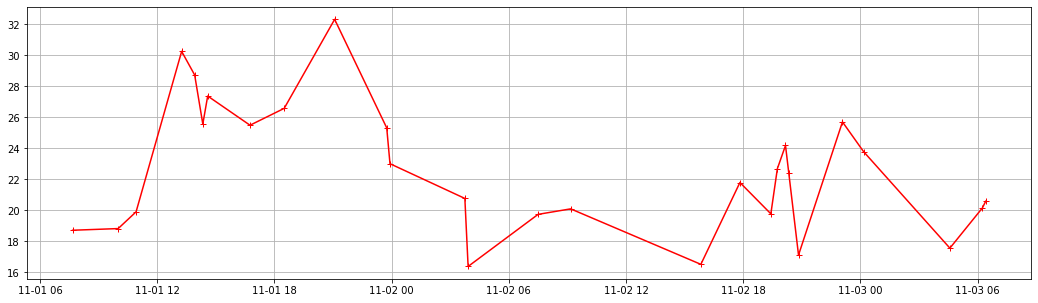

In [70]:
dfx = dfx[:28]
plt.figure(figsize=(18,5))
plt.plot(dfx.index.values, dfx.cpu_utilization.values, 'r-+')
plt.grid()


## Q4. Fit a linear regression to this data with y as "cpu_utilization" column. Comment on the fit of the model

TODO: 
1. reserve a common test set for comparison scores like mse
(time continuity ???)
2. define a baseline model simply y[n]=y[n-1]
3. Linear Regression, Ridge, Lasso with Grid Search
4. GradientBoost, XGBoost


In [ ]:
check_data_dims()

In [ ]:
# First define a baseline prediction model as y[n] = y[n-1];
# There are a few discontinuity points which can be ignored.

# persistence model
def model_persistence(x):
	return x

def baseline_timeseries_predictor_y(Y):
  values = pd.DataFrame(Y)
  from pandas import concat
  from sklearn.metrics import mean_squared_error

  # Create lagged dataset
  dataframe = concat([values.shift(1), values], axis=1)
  dataframe.columns = ['t-1', 't']
  print(dataframe.head(5))

  # time series is split into train and test sets
  X = dataframe.values
  train_size = int(len(X) * 0.66)
  train, test = X[1:train_size], X[train_size:]
  train_X, train_y = train[:,0], train[:,1]
  test_X, test_y = test[:,0], test[:,1]

  # walk-forward validation
  predictions = list()
  for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)

  test_score = mean_squared_error(test_y, predictions)

  print('Test MSE: %.3f' % test_score)

  # plot predictions and expected results
  stop_idx = 100 #len(test_y)
  plt.figure()
  plt.plot(test_y[:stop_idx], 'r-+')
  plt.plot(predictions[:stop_idx], 'g-o')
  fig = plt.gcf()
  fig.set_size_inches(22.5, 3)

  stop_idx = 100 #len(test_y)
  plt.figure()
  plt.plot(test_y[:stop_idx], 'r-+')
  plt.plot(test_y[:stop_idx] - predictions[:stop_idx], 'g-o')
  fig = plt.gcf()
  fig.set_size_inches(22.5, 3)

  plt.figure()
  plt.plot(test_y, predictions, 'r+')
  fig = plt.gcf()
  fig.set_size_inches(10, 10)


In [ ]:
baseline_timeseries_predictor_y(Y)

In [ ]:
def RFE_timelagged_y(dataframe):
  from sklearn.feature_selection import RFE
  from sklearn.ensemble import RandomForestRegressor
  from matplotlib import pyplot
  array = dataframe.values
  X = array[:,0:-1]
  y = array[:,-1]
  # perform feature selection
  rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), n_features_to_select=4)
  fit = rfe.fit(X, y)
  # report selected features
  print('Selected Features:')
  names = dataframe.columns.values[0:-1]
  for i in range(len(fit.support_)):
    if fit.support_[i]:
      print(names[i])
  # plot feature rank
  names = dataframe.columns.values[0:-1]
  ticks = [i for i in range(len(names))]
  pyplot.bar(ticks, fit.ranking_)
  pyplot.xticks(ticks, names)
  pyplot.show()

Selected Features:
t-6
t-3
t-2
t-1

In [ ]:
df.shape

In [ ]:
# create num_lags number of new columns of shifted observations
def baseline_timeseries_multilags_y(Y, num_lags, rolling_window_widths, ewm_alphas):
  from sklearn.linear_model import LinearRegression
  values = pd.DataFrame(Y)
  from sklearn.metrics import mean_squared_error

  # Create lagged dataset
  dataframe = pd.DataFrame()
  for i in range(num_lags+1):
    dataframe['t-'+str(i)] = values.shift(i).values[:,0]

  if len(rolling_window_widths)>0:
    for rolling_window in rolling_window_widths:
      # temp solution: add rolling before target y as rolling mean of t-1 as we extract y as last column later
      dataframe['rolling std '+str(rolling_window)] = dataframe['t-1'].rolling(window=rolling_window).std()
      dataframe['rolling mean '+str(rolling_window)] = dataframe['t-1'].rolling(window=rolling_window).mean()
  if len(ewm_alphas)>0:
    for alpha in ewm_alphas: 
      dataframe['ewm_mean '+str(alpha)] = dataframe['t-1'].ewm(alpha=alpha).mean()
      dataframe['ewm_std '+str(alpha)] = dataframe['t-1'].ewm(alpha=alpha).std()

  #print(dataframe.head(num_lags+1))
  ignored_nans = max(num_lags, len(rolling_window_widths), )
  dataframe = dataframe[ignored_nans+1:]
  dataframe.head(10)
  return dataframe

In [ ]:
def LinearRegression_mse(dataframe):
  from sklearn.metrics import mean_squared_error
  from sklearn.linear_model import LinearRegression 

  #X = dataframe.values
  train_size = int(len(dataframe) * 0.66)
  train_y = dataframe.iloc[:train_size, 0].values
  train_X = dataframe.iloc[:train_size, 1:].values

  test_y = dataframe.iloc[train_size:, 0].values
  test_X = dataframe.iloc[train_size:, 1:].values

  train_y = train_y.reshape(train_y.shape[0], 1)
  test_y = test_y.reshape(test_y.shape[0], 1)

  print(f'**** train_X shape = {train_X.shape}, test_X shape = {test_X.shape}')
  print(f'**** train_y shape = {train_y.shape}, test_y shape = {test_y.shape}')

  model = LinearRegression()
  model.fit(train_X, train_y)
  predictions = model.predict(test_X)
  test_score = mean_squared_error(test_y, predictions)

  if 0:
    print(type(train_X), type(train_y))
    print(train_X.shape, train_y.shape)
    print(test_X.shape, test_y.shape)
    print(f'type model.coef_={type(model.coef_)}')
  
  print(f'model.coef_={model.coef_}')
  print('Test MSE: %.3f' % test_score)  
  print(f'model.coef_ shape={model.coef_.shape}, columns = {dataframe.columns[1:]}')

  plt.figure()
  model.coef_ = model.coef_.reshape(model.coef_.shape[1],)
  plt.plot(dataframe.columns[1:], model.coef_, 'r-o')
  plt.title('model coef')
  plt.xticks(rotation = 60)
  plt.grid()
  fig = plt.gcf()
  fig.set_size_inches(22.5, 3)

  # plot predictions and expected results
  stop_idx = 100 #len(test_y)
  plt.figure()
  plt.plot(test_y[:stop_idx], 'r-+')
  plt.plot(predictions[:stop_idx], 'g-o')
  fig = plt.gcf()
  fig.set_size_inches(22.5, 3)

  stop_idx = 100 #len(test_y)
  plt.figure()
  plt.plot(test_y[:stop_idx], 'r-+')
  plt.plot(test_y[:stop_idx] - predictions[:stop_idx], 'g-o')
  fig = plt.gcf()
  fig.set_size_inches(22.5, 3)

  plt.figure()
  plt.plot(test_y, predictions, 'r+')
  fig = plt.gcf()
  fig.set_size_inches(5, 5)

  return test_score


In [ ]:
num_lags = 1
rolling_window = []
ewm_alphas = []
y_lagged_df = baseline_timeseries_multilags_y(Y, num_lags, rolling_window, ewm_alphas)
#y_lagged_df = y_lagged_df[['t-6', 't-3', 't-2', 't-1', 't']]
(y_lagged_df.head())

In [ ]:
num_lags = 5
rolling_window = [6, 12]
ewm_alphas = [0.75, 0.5, 0.1]
y_lagged_df = baseline_timeseries_multilags_y(Y, num_lags, rolling_window, ewm_alphas)
#y_lagged_df = y_lagged_df[['t-6', 't-3', 't-2', 't-1', 't']]
(y_lagged_df.head())


In [ ]:
mse = LinearRegression_mse(y_lagged_df)

Adding 12 lags of target y yields MSE of 0.5 which is better than mse of 1.0 of naive model of single lag case but still worse;
TODO:
add lags to the feature sets inckuding read_tput etc;



In [ ]:
print(y_lagged_df.shape, type(y_lagged_df))
y_lagged_df.head()

Gradient Boost Regressor mse is 0.04 which is much smaller than mse of baseline mse of 1.02.

In [ ]:
y_lagged_df.iloc[:3,:-1]

In [ ]:
y_lagged_df.iloc[:3,-1]

In [ ]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)


In [ ]:
from sklearn.metrics import mean_squared_error
y_hat = reg.predict(X_test)
mse = mean_squared_error(y_test, y_hat)
print(f'mse={mse}')
plt.plot(y_test, y_hat, '+')

The effect of time in this data set is not clear as shown be correlation of time with target.
Thus we can use KFold for cross-validation.


In [ ]:
# Use LinearRegression for regression, DecisionTreeRegressor for feature selection
# explore the number of selected features for RFE
# Try Ridge, Lasso, ElasticNet for regularization and feature selection
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

n_features_to_select = [2, len(x_cols)]
ridge_alpha = 0.1 # larger alpha stronger regularisation
lasso_alpha = 0.1 # larger alpha stronger regularisation

from enum import Enum
class LRModel(Enum):
   LR = 1
   RIDGE = 2
   LASSO = 3
   ELASTICNET = 4

# get the dataset
def get_dataset(X, Y):
	X, y = X, Y
	return X, y

# get a list of models to evaluate
def get_models(model_choice):
  models = dict()
  for i in range(n_features_to_select[0], n_features_to_select[1]):
    #rfe = RFE(estimator=LinearRegression(), n_features_to_select=i)
    rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=i)
    if model_choice == LRModel.LR:
      model = LinearRegression()
    elif model_choice == LRModel.RIDGE:
      model = Ridge()
    elif model_choice == LRModel.LASSO:
      model = Lasso()
    elif model_choice == LRModel.ELASTICNET:
      model = ElasticNet()
    else:
      print("Unexpected arg for LR model")
      raise
  models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
  return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = KFold(n_splits=10, shuffle=False, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores


# define dataset
X, y = get_dataset(X, Y)


In [ ]:
# RFE + LinearRegression/Ridge/Lasso/ElasticNet + evaluate_model
# get the models to evaluate
models = get_models(LRModel.RIDGE)

# KFOLD Cross-validation
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()


In [ ]:
# Time-series split with time continuity kept
# evaluate the models and store results

TRAIN_FRACTION = 0.7
L_train = int(len(Y)*TRAIN_FRACTION)

X_train = X[:L_train, :]
Y_train = Y[:L_train]
X_test = X[L_train:, :]
Y_test = Y[L_train:]

results, names = list(), list()
model.fit(X_train, Y_train)
predicted = model.predict(X_test, Y_test)

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
# DNN regression
NUM_SPLITS = 5
NUM_EPOCHS = 1
BATCH_SIZE = 10

# Regression
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

Y = data[:, Y_INDEX_DATA]
X = data[:, X_FIRST_INDEX_DATA:]

# define base model
def baseline_model():
	model = Sequential()
	model.add(Dense(18, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
	model.add(Dense(8, kernel_initializer='normal', activation='relu'))
	model.add(Dense(8, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model
  
# Step: evaluate model with standardized dataset
estimators = []
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, verbose=2)))
pipeline = Pipeline(estimators)

kfold = KFold(n_splits = NUM_SPLITS, shuffle=False)
print(f'X shape={X.shape}, Y shape = {Y.shape}')
results = cross_val_score(pipeline, X, Y, cv=kfold)
print(f'results of cross_val_score = {results}')
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))


In [ ]:
# DNN/MLP: get predicted values
from sklearn.model_selection import cross_val_predict
# TRY this also
#from sklearn import linear_model

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
#results = cross_val_score(pipeline, X, Y, cv=kfold)
predicted = cross_val_predict(pipeline, X, Y, cv=kfold)
# method='predict', 
# X: array-like of shape (n_samples, n_features)
# Returns: When method is ‘predict’: (n_samples,)

fig, ax = plt.subplots()
ax.scatter(Y, predicted)
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.grid()
plt.show()

In [ ]:
mse = mean_squared_error(Y, predicted)
print(f'mse={mse}')


# DNN mse 0.06 is worse than GradientBoost 0.04

In [ ]:
# plot against time IN transformed/scaled version
def plot_prediction_time(start, stop, X, Y, predicted):
  num_cols = 3
  plt.subplot(num_cols, 1, 1)
  plt.plot(X[start:stop, x_cols.index('timestamp_seconds')], Y[start:stop], 'b-+', label='rea target')
  #plt.plot(X[start:stop, x_cols.index('timestamp_seconds')], ( predicted[start:stop]), 'g-o', label='predicted target')
  plt.plot(X[start:stop, x_cols.index('timestamp_seconds')], (Y[start:stop] - predicted[start:stop]), 'g-o', label='error')
  plt.ylabel('scaled target')
  plt.xlabel('scaled time')
  plt.grid(True)
  plt.legend()

  plt.subplot(num_cols, 1, 2)
  plt.plot(data[start:stop, data_cols.index('timestamp_seconds')], (Y[start:stop] - predicted[start:stop])/(Y[start:stop]), 'r-*', label='error/real')
  plt.ylim(0, 1)
  plt.ylabel('scaled target')
  plt.xlabel('scaled time')
  plt.grid(True)
  plt.legend()

  plt.subplot(num_cols, 1, 3)
  #plt.plot(X[start:stop, x_cols.index('timestamp_seconds')])
  plt.hist((Y[start:stop] - predicted[start:stop])/(Y[start:stop]), bins=100)
  plt.ylabel('scaled time')

  fig = plt.gcf()
  fig.set_size_inches(22.5, num_cols*3)


# Get orignal target w/o transformation from df
def get_target(df, systemId_selected, numerical_transform_cols):
  if systemId_selected[0] == 'All':
    df_tmp = df[numerical_transform_cols]
  else:  
    df_tmp = df[df['systemId']==systemId_selected[0]][numerical_transform_cols]
  return df_tmp.values


In [ ]:
start= 1000 #int(0*24*60/5)
stop = 1111 #len(Y) #int(1*24*60/5)
plot_prediction_time(start, stop, X, Y, predicted)



In [ ]:
start=100; stop=110
print(Y[start:stop], '\n',predicted[start:stop], '\n',
      Y[start:stop]- predicted[start:stop], '\n', (Y[start:stop]- predicted[start:stop])/Y[start:stop])


In [ ]:
plt.plot(Y, predicted, '+')
plt.grid()
fig = plt.gcf()
fig.set_size_inches(22.5, 5)

In [ ]:
y_real = get_target(df, SYSTEM_ID_SELECTED, 'cpu_utilization' )

# RUN: inverse_transform of predicted target 
y_hat = target_transformer.inverse_transform( predicted.reshape(predicted.shape[0], 1) )
print(predicted.shape, y_hat.shape, type(y_hat))


In [ ]:
# RUN: inverse_transform TRUE target transformed
y_real_inverse_transfomred = target_transformer.inverse_transform( Y.reshape(Y.shape[0], 1) )
print(Y.shape, y_real_inverse_transfomred.shape, type(y_real_inverse_transfomred))


In [ ]:
plt.plot(y_real, y_real_inverse_transfomred, '+')
plt.grid()
fig = plt.gcf()
fig.set_size_inches(22.5, 5)

In [ ]:
plt.plot(y_real_inverse_transfomred, y_hat, '+')
plt.grid()
fig = plt.gcf()
fig.set_size_inches(22.5, 5)


In [ ]:
# TODO: get real time in timedate
#plot inverse transformed y_hat against time
fig, ax = plt.subplots()
start= int(0*24*60/5)
stop = int(0.2*24*60/5)

ax.plot(X[:, x_cols.index('timestamp_seconds')][start:stop], y_real[start:stop], 'b-+', label='real')
ax.plot(X[:, x_cols.index('timestamp_seconds')][start:stop], y_hat[:, 0][start:stop], 'g-o', label='predicted')
ax.set_xlabel('scaled time')
ax.set_ylabel('Predicted')
ax.grid()
ax.legend()
fig = plt.gcf()
fig.set_size_inches(22.5, 3)
plt.show()


In [ ]:
# Run this after Standardarization
# Add nonlinear transformation of features
df['rw_cache_miss_ratio'] = df['read_cache_miss'] / df['write_cache_miss']
df['rw_iops_ratio'] = df['read_iops'] / df['write_iops']
df['rw_throughput_ratio'] = df['read_throughput'] / df['write_throughput']
df['rw_iosz_ratio'] = df['read_iosz'] / df['write_iosz']

df['rw_cache_miss_diff'] = df['read_cache_miss'] - df['write_cache_miss']
df['rw_iops_diff'] = df['read_iops'] - df['write_iops']
df['rw_throughput_diff'] = df['read_throughput'] - df['write_throughput']
df['rw_iosz_diff'] = df['read_iosz'] - df['write_iosz']

In [ ]:
# remove cols_remove from cols;
# divide cols into array of lists of size W 
def split_columns(cols, cols_remove, W):
  for col in cols_remove:
    cols.remove(col)
  L = len(cols)
  R = int(L/W)
  x1 = list(np.array(cols[:R*W]).reshape(R,W))
  x2 = cols[R*W:]
  x1.append(x2)
  return x1

In [ ]:
# RUN: pairplotr VERY SLOW for larger number of features! !!
def pairplot(df, systemId_selected, cols, title_str):
  if len(systemId_selected)>0:
    df = df[df['systemId']==systemId_selected]
  sns.pairplot(df[cols], corner=True)
  fig = plt.gcf()
  fig.set_size_inches(15.5, 3*2)
  fig.suptitle(f'{title_str}, systemId {systemId_selected[0]}')
  plt.show()

In [ ]:
systemId = 'sys1'
cols = list(df.columns.values)
cols_remove = ['timestamp_seconds', 'systemId', 'model_type']
W = 4
cols_groups = split_columns(cols, cols_remove, W)
print(f'cols_groups={cols_groups}')
title_str = 'Before Transformation'

for col_subset in cols_groups:
  pairplot(df, systemId, col_subset, title_str)

In [ ]:
print(f' data.shape={data.shape}, data_cols len={len(data_cols)}\n data_cols={data_cols}')


In [ ]:

fig, ax = plt.subplots()
ax.scatter(y_real, y_hat[:, 0])
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.grid()
fig = plt.gcf()
fig.set_size_inches(18.5, 5)
plt.show()
predicted.shape


Finished regression here

In [ ]:
# Use LinearRegression for regression, LinearRegression for feature selection
# DecisionTreeRegressor for feature selection ??? TODO
# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.pipeline import Pipeline
from matplotlib import pyplot

n_features_to_select = [2, len(x_cols)]

# get the dataset
def get_dataset(X, Y):
	X, y = X, Y
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(n_features_to_select[0], n_features_to_select[1]):
		#rfe = RFE(estimator=LinearRegression(), n_features_to_select=i)
		rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=i)
		model = LinearRegression()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = KFold(n_splits=10, shuffle=False, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores


# define search space
param_space = dict()
param_space['n_estimators'] = [10, 100, 500]
param_space['max_features'] = [2, 4, 6]

def grid_search_regression(model, param_space):
  cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
  # define search
  search = GridSearchCV(model, space, scoring=‘neg_mean_squared_error’, n_jobs=1, cv=cv_inner, refit=True)
  # configure the cross-validation procedure
  cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
  # execute the nested cross-validation
  scores = cross_val_score(search, X, y, scoring='accuracy', cv=cv_outer, n_jobs=-1)
  # report performance
  print('mse: %.3f (%.3f)' % (mean(scores), std(scores)))


# grid search
# define dataset
X, y = get_dataset(X, Y)
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()
pyplot.grid()

In [ ]:
# non grid search:
# define dataset
X, y = get_dataset(X, Y)
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()
pyplot.grid()

## Q5. Create a column where cpu_utilization < 20 is 0 and cpu_utilization >= 20 as 1. Using this newly created column build a logistic regression. Commment on the evaluation of the model.

In [ ]:
check_data_dims()

In [ ]:
target_threshold = target_transformer.transform([[20]])
target_threshold = target_threshold[0]
f = lambda x: x>target_threshold
Y_cat = f(Y)

In [ ]:
# classification_report reports precision, recall, f1, support
from sklearn.metrics import classification_report

y_pred = anova_svm.predict(X_test)
print(classification_report(y_test, y_pred))

permutatation importance for regression

In [ ]:
# permutation feature importance with knn for regression
# define the model
def permutation_importance_regression(model, X, Y, x_cols, scoring, title):
  from sklearn.model_selection import train_test_split
  from sklearn.inspection import permutation_importance
  X_train, X_test, y_train, y_test = train_test_split(
      X, Y, random_state=0)
  # fit the model
  model.fit(X_train, y_train)
  # perform permutation importance
  results = permutation_importance(model, X_train, y_train, scoring=scoring)
  # get importance
  importance = results.importances_mean
  # summarize feature importance
  for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
  # plot feature importance
  plt.bar([x for x in x_cols], importance)
  plt.title(title)
  plt.xticks(rotation = 60) # Rotates X-Axis Ticks by 45-degrees
  fig = plt.gcf()
  fig.set_size_inches(18, 7)
  plt.show()


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
models = [GradientBoostingRegressor(), KNeighborsRegressor()]
scoring='neg_mean_squared_error'
title = 'Feature importance of GradientBoostingRegressor' +'scoring ' + scoring
permutation_importance_regression(models[0], X, Y, x_cols, scoring, title)



Tree’s Feature Importance from Mean Decrease in Impurity (MDI)¶




In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, Y_cat, stratify=Y_cat, random_state=42)
feature_names = x_cols
forest = RandomForestClassifier(random_state=0)

forest.fit(X_train, y_train)
import time
start_time = time.time()
importances = forest.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")
import pandas as pd
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
[forest_importances.values, std]

# Use LDA to reduce dimensitionality and visualise
# Use permutation to decide feature importance 

In [ ]:
# Get orignal target w/o transformation from df
def get_target(df, systemId_selected, numerical_transform_cols):
  if systemId_selected[0] == 'All':
    df_tmp = df[numerical_transform_cols]
  else:  
    df_tmp = df[df['systemId']==systemId_selected[0]][numerical_transform_cols]
  return df_tmp.values

y_real = get_target(df, SYSTEM_ID_SELECTED, 'cpu_utilization' )
_= plt.hist(y_real)


_=plt.hist(Y)

In [ ]:
f1 = lambda x: x>20
y_real_cat = f1(y_real)*1
_= plt.hist(y_real_cat)

In [ ]:
_= plt.hist(Y_cat)

In [ ]:
# Use LogisticRegression for classification, DecisionTreeClassifier for feature selection

# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from matplotlib import pyplot

n_features_to_select = [2, len(x_cols)]

# get the dataset
def get_dataset(X, Y):
	X, y = X, Y
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(n_features_to_select[0], n_features_to_select[1]):
		rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
		model = LogisticRegression()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset(X, Y_cat)
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

## Q6. Fit a simple decision tree regressor to this data. Comment about the fit of the model

In [ ]:
check_data_dims()

In [ ]:
# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

n_features_to_select = [2, len(x_cols)]

# get the dataset
def get_dataset(X, Y):
	X, y = X, Y
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(n_features_to_select[0], n_features_to_select[1]):
		rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
		model = DecisionTreeClassifier()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset(X, Y_cat)
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

## Q7. Fit a Random forest regressor. Compare this with simple dicision tree. If Random forest is better then why

In [ ]:
check_data_dims()

In [ ]:
# Use RandomForestClassifier for classification, DecisionTreeClassifier for feature selection
# TODO: add f1-score for biased classification
# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from matplotlib import pyplot

n_features_to_select = [2, len(x_cols)]

# get the dataset
def get_dataset(X, Y):
	X, y = X, Y
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(n_features_to_select[0], n_features_to_select[1]):
		rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
		model = RandomForestClassifier()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset(X, Y_cat)
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
#GridSerachCV for hyperparameters tuning

# manual nested cross-validation for random forest on a classification dataset
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score


def gridsearch_CV_run(X, Y, scoring, space):
  # configure the cross-validation procedure
  cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
  # enumerate splits
  outer_recall, outer_precision, outer_f1, outer_accuracy = list(),list(),list(),list()
  for train_ix, test_ix in cv_outer.split(X):
    # split data
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = Y[train_ix], Y[test_ix]
    # configure the cross-validation procedure
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
    # define the model
    model = RandomForestClassifier(random_state=1)
    # define search
    search = GridSearchCV(model, space, scoring=scoring, cv=cv_inner, refit=True)
    # execute search
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)

    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    outer_accuracy.append(acc)

    precision = precision_score(y_test, yhat)
    outer_precision.append(precision)

    f1 = f1_score(y_test, yhat)
    outer_f1.append(f1)

    recall = recall_score(y_test, yhat)
    outer_recall.append(recall)

    # report progress
    print('est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
    print('acc=%.3f, precision=%.3f, recall=%.3f, f1=%.3f, ' % (acc, precision, recall, f1 ))

  # summarize the estimated performance of the model
  print(f'outer_accuracy: %.3f (%.3f)' % (mean(outer_accuracy), std(outer_accuracy)))
  print(f'outer_precision: %.3f (%.3f)' % (mean(outer_precision), std(outer_precision)))
  print(f'outer_recall: %.3f (%.3f)' % (mean(outer_recall), std(outer_recall)))
  print(f'outer_f1: %.3f (%.3f)' % (mean(outer_f1), std(outer_f1)))


In [ ]:
scoring = 'f1' #'accuracy'
# define search space
space = dict()
space['n_estimators'] = [10, 100, 500]
space['max_features'] = [1, 2, 4, 6]

gridsearch_CV_run(X, Y_cat, scoring, space)


In [ ]:
X.shape


## Q8. How do improve the accuracy of Random forest regressor

In [ ]:
GradientBoost

In [ ]:
#GridSerachCV for hyperparameters tuning

# manual nested cross-validation for random forest on a classification dataset
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score


def gridsearch_CV_GBoost(X, Y, scoring, space):
  # configure the cross-validation procedure
  cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
  # enumerate splits
  outer_recall, outer_precision, outer_f1, outer_accuracy = list(),list(),list(),list()
  for train_ix, test_ix in cv_outer.split(X):
    # split data
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = Y[train_ix], Y[test_ix]
    # configure the cross-validation procedure
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
    # define the model
    model = GradientBoostingClassifier(random_state=1)
    # define search
    search = GridSearchCV(model, space, scoring=scoring, cv=cv_inner, refit=True)
    # execute search
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)

    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    outer_accuracy.append(acc)

    precision = precision_score(y_test, yhat)
    outer_precision.append(precision)

    f1 = f1_score(y_test, yhat)
    outer_f1.append(f1)

    recall = recall_score(y_test, yhat)
    outer_recall.append(recall)

    # report progress
    print('est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
    print('acc=%.3f, precision=%.3f, recall=%.3f, f1=%.3f, ' % (acc, precision, recall, f1 ))

  # summarize the estimated performance of the model
  print(f'outer_accuracy: %.3f (%.3f)' % (mean(outer_accuracy), std(outer_accuracy)))
  print(f'outer_precision: %.3f (%.3f)' % (mean(outer_precision), std(outer_precision)))
  print(f'outer_recall: %.3f (%.3f)' % (mean(outer_recall), std(outer_recall)))
  print(f'outer_f1: %.3f (%.3f)' % (mean(outer_f1), std(outer_f1)))


In [ ]:

scoring = 'f1' #'accuracy'
# define search space
space = dict()
space['n_estimators'] = [10, 100, 500]
space['max_features'] = [1, 2, 4, 6]
parameters = {'learning_rate': [0.1],
              'subsample'    : [0.9, 0.5],
              'n_estimators' : [100, 500],
              'max_depth'    : [2, 4, 6, 8],
              'max_features' : [2, 4, 6]
              }
gridsearch_CV_GBoost(X, Y_cat, scoring, parameters)



In [ ]:
# 2nd time run
# TODO: start with faster HalvingGridSearchCV, Try XGBoost iso GradientBoost
scoring = 'f1' #'accuracy'
# define search space
space = dict()
space['n_estimators'] = [10, 100, 500]
space['max_features'] = [1, 2, 4, 6]
parameters = {'learning_rate': [0.1],
              'n_estimators' : [100, 500],
              'max_depth'    : [2, 4, 6, 8],
              'max_features' : [2, 4, 6]
              }
gridsearch_CV_GBoost(X, Y_cat, scoring, parameters)


In [ ]:
# 3rd time run
# TODO: start with faster HalvingGridSearchCV, Try XGBoost iso GradientBoost
scoring = 'f1' #'accuracy'
# define search space
parameters = {'learning_rate': [0.1],
              'n_estimators' : [1000],
              'max_depth'    : [2, 4],
              'max_features' : [2, 4, 6]
              }
gridsearch_CV_GBoost(X, Y_cat, scoring, parameters)

## Q9. Cluster the input variables using KMeans and GMM.
       
1.   Draw the contour plots
2.   Explain the hyper-parameters you choose and why?

use t-SNE for visualization

PCA  + K-means OR DBSCAN
1. PCA + cluster
2. DBSCAN
2. Clustering on the output of t-SNE with 80 perplexity; beware, t-SNE can produce "fake" patterns!
If we would instead further increase the perplexity, the uniformity would increase, and the separation would reduce again.




In [ ]:
check_data_dims()

In [ ]:
#First, decide how many features we’d like to keep based on the cumulative variance plot.
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X)
print(len(pca.explained_variance_), pca.explained_variance_) 
print(len(pca.explained_variance_ratio_), pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

plt.figure(figsize=(10,8))
plt.plot(range(1, X.shape[1]+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('cumulative explained variance')
plt.grid()

In [ ]:
# We keep the first 4 components to get a cumulative variance of 86 per cent;
from sklearn.decomposition import PCA
num_components_pca = 4
pca = PCA(n_components = num_components_pca)
pca.fit(X)
pca_out = pca.transform(X)
score_pca = pca.transform(X)
print(pca_out.shape, X.shape)

visualize clusters with PCA output as input to KMeans

In [ ]:
def plot_cluster_mesh(data, n_clusters, use_PCA, title):
  if use_PCA:
    reduced_data = PCA(n_components=2).fit_transform(data)
  else:
    reduced_data = data  
  kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=10)
  kmeans.fit(reduced_data)

  # Step size of the mesh. Decrease to increase the quality of the VQ.
  h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

  # Plot the decision boundary. For that, we will assign a color to each
  x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
  y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

  # Obtain labels for each point in mesh. Use last trained model.
  Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)
  plt.figure(1)
  plt.clf()
  plt.imshow(Z, interpolation="nearest",
            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
            cmap=plt.cm.Paired, aspect="auto", origin="lower")

  plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
  # Plot the centroids as a white X
  centroids = kmeans.cluster_centers_
  plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
              color="w", zorder=10)
  plt.title(title+ " K-means clustering"
            "Centroids are marked with white cross")
  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)
  plt.xticks(())
  plt.yticks(())
  plt.show()


In [ ]:
n_clusters = 4
use_PCA = False
title = 'Not use PCA output;'
plot_cluster_mesh(X[:,:2], n_clusters, use_PCA, title)



In [ ]:
n_clusters = 4
use_PCA = True
title = 'use PCA output;'
# TODO: add x_cols[:2]
plot_cluster_mesh(X[:,:2], n_clusters, use_PCA, title)



In [ ]:
x_cols[:2]


In [ ]:
# determine the optimal number of clusters;
# apply Elbow method by plotting WCSS vs K 
def plot_kmeans_inertia(title, wcss):
  plt.figure(figsize=(10,8))
  plt.plot(range(1,num_clusters), wcss, marker='o', linestyle='--')
  plt.xlabel('Number of Clusters')
  plt.ylabel('WCSS')
  plt.title(title)
  plt.grid()
  plt.show()

def plot_elbow(data, title, num_clusters, random_state):
  wcss = [] 
  for i in range(1, num_clusters):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state=random_state)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)
  plot_kmeans_inertia(title, wcss)




In [ ]:
title = 'K-Means without PCA'
num_clusters = 27
random_state_kmeans = 0
plot_elbow(X, title, num_clusters, random_state_kmeans)

In [ ]:
title = f'K-Means using top {num_components_pca} components after PCA transform'
num_clusters = 27
random_state_kmeans = 0
plot_elbow(pca_out, title, num_clusters, random_state_kmeans)

From Elbow plot we can set final number of clusters as 4 where the WCSS starts decrease slower.

In [ ]:
# plot 3D of clusters 
from mpl_toolkits.mplot3d import Axes3D

def plot_3d(X, opt_num_clusters, index_3d, axes_labels, title):

  estimators = [('kmeans_opt_num_clusters', KMeans(n_clusters=opt_num_clusters))]

  fignum = 1
  for name, est in estimators:
      fig = plt.figure(fignum, figsize=[8, 8])
      ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
      est.fit(X)
      labels = est.labels_

      ax.scatter(X[:, index_3d[0]], X[:, index_3d[1]], X[:, index_3d[2]],
                c=labels.astype(float), edgecolor='k')

      ax.w_xaxis.set_ticklabels([])
      ax.w_yaxis.set_ticklabels([])
      ax.w_zaxis.set_ticklabels([])
      ax.set_xlabel(axes_labels[0])
      ax.set_ylabel(axes_labels[1])
      ax.set_zlabel(axes_labels[2])
      ax.set_title(title)
      ax.dist = 12
      fignum = fignum + 1
  

In [ ]:
# K-Means not using PCA outputs
opt_num_clusters = 3
title = f'{opt_num_clusters} cluster K-Means without using PCA outputs'
index_3d = [0, 1, 2]
plot_3d(X, opt_num_clusters, index_3d, x_cols, title)


In [ ]:
# plot 2d of clusters 
from mpl_toolkits.mplot3d import Axes3D

def plot_2d(X, x_index_col, opt_num_clusters, axes_labels, title):
  kmeans = KMeans(n_clusters = opt_num_clusters, init = "k-means++", random_state = 0)
  y_kmeans = kmeans.fit_predict(X)
  color_list = ['red', 'blue', 'green', 'yellow', 'violet']
  plt.figure(figsize=(10,8))
  for label in range(opt_num_clusters):
    color = color_list[label]
    x = X[y_kmeans == label, x_index_col[0]]
    y = X[y_kmeans == label, x_index_col[1]]
    plt.scatter(x, y, s = 60, c=color, label = f'Cluster{label}')
  plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'black', label = 'Centroids')
  plt.xlabel(axes_labels[0]) 
  plt.ylabel(axes_labels[1]) 
  plt.legend() 
  plt.title(title)
  plt.show()

In [ ]:
# 2-d plot of K-Means using PCA outputs
index_col = [0, 1]
opt_num_clusters = 3
title = f'{opt_num_clusters} cluster K-Means using top {num_components_pca} components after PCA transform'
axes_labels = [f'pca component {k}' for k in [1,2,3]]
plot_2d(pca_out, index_col, opt_num_clusters, axes_labels, title)


In [ ]:
# 2-d plot of K-Means not using PCA outputs
index_col = [0, 1]
opt_num_clusters = 3
title = f'{opt_num_clusters} cluster K-Means not using PCA transform'
plot_2d(pca_out, index_col, opt_num_clusters, x_cols, title)


DBSCAN


In [ ]:
check_data_dims()

In [ ]:
# Use DBSCAN to estimate number of clusters
from sklearn.cluster import DBSCAN
from sklearn import metrics

# Compute DBSCAN
db = DBSCAN(eps=0.7, min_samples=20).fit(pca_out)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# Black removed and is used for noise instead.
unique_labels = set(labels)
for k in unique_labels:
  print(k,np.sum(labels==k))

print(f'unique_labels={unique_labels}, labels.shape={labels.shape}')
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

In [ ]:

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Decide number of clusters using Silhouette coefficients

In [ ]:
def silhouette_cluster_number(X, title):
  from sklearn.cluster import KMeans
  from sklearn.metrics import silhouette_samples, silhouette_score

  import matplotlib.pyplot as plt
  import matplotlib.cm as cm
  import numpy as np

  print(__doc__)

  range_n_clusters = [2, 3, 4, 5, 6]

  for n_clusters in range_n_clusters:
      # Create a subplot with 1 row and 2 columns
      fig, (ax1, ax2) = plt.subplots(1, 2)
      fig.set_size_inches(18, 7)

      # The 1st subplot is the silhouette plot
      # The silhouette coefficient can range from -1, 1 but in this example all
      # lie within [-0.1, 1]
      ax1.set_xlim([-0.1, 1])
      # The (n_clusters+1)*10 is for inserting blank space between silhouette
      # plots of individual clusters, to demarcate them clearly.
      ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

      # Initialize the clusterer with n_clusters value and a random generator
      # seed of 10 for reproducibility.
      clusterer = KMeans(n_clusters=n_clusters, random_state=10)
      cluster_labels = clusterer.fit_predict(X)

      # The silhouette_score gives the average value for all the samples.
      # This gives a perspective into the density and separation of the formed
      # clusters
      silhouette_avg = silhouette_score(X, cluster_labels)
      print("For n_clusters =", n_clusters,
            "The average silhouette_score is :", silhouette_avg)

      # Compute the silhouette scores for each sample
      sample_silhouette_values = silhouette_samples(X, cluster_labels)

      y_lower = 10
      for i in range(n_clusters):
          # Aggregate the silhouette scores for samples belonging to
          # cluster i, and sort them
          ith_cluster_silhouette_values = \
              sample_silhouette_values[cluster_labels == i]

          ith_cluster_silhouette_values.sort()

          size_cluster_i = ith_cluster_silhouette_values.shape[0]
          y_upper = y_lower + size_cluster_i

          color = cm.nipy_spectral(float(i) / n_clusters)
          ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

          # Label the silhouette plots with their cluster numbers at the middle
          ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

          # Compute the new y_lower for next plot
          y_lower = y_upper + 10  # 10 for the 0 samples

      ax1.set_title("The silhouette plot for the various clusters.")
      ax1.set_xlabel("The silhouette coefficient values")
      ax1.set_ylabel("Cluster label")

      # The vertical line for average silhouette score of all the values
      ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

      ax1.set_yticks([])  # Clear the yaxis labels / ticks
      ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

      # 2nd Plot showing the actual clusters formed
      colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
      ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                  c=colors, edgecolor='k')

      # Labeling the clusters
      centers = clusterer.cluster_centers_
      # Draw white circles at cluster centers
      ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                  c="white", alpha=1, s=200, edgecolor='k')

      for i, c in enumerate(centers):
          ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                      s=50, edgecolor='k')

      ax2.set_title("The visualization of the clustered data.")
      ax2.set_xlabel("Feature space for the 1st feature")
      ax2.set_ylabel("Feature space for the 2nd feature")

      plt.suptitle((title + " Silhouette analysis for KMeans "
                    ", n_clusters = %d" % n_clusters),
                  fontsize=14, fontweight='bold')

  plt.show()

In [ ]:
title = 'PCA output is used as input;'
silhouette_cluster_number(pca_out, title)



In [ ]:
title = 'PCA not used;'
silhouette_cluster_number(X, title)




> Indented block

